In [1]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams["savefig.dpi"] = 600
plt.rcParams["legend.loc"] = "upper right"
plt.rcParams['figure.figsize'] = (6.0, 4.0)

np.random.seed(123456)
_ = torch.manual_seed(123456)
RANDOM_STATE = 123456
DATABASE_NAME = 'mimiciv'
HOST = "localhost"  
PORT = 5432
USER_NAME = 'postgres' 
PASSWORD = "root"

MONTH1 = 30
MONTH3 = 90
MONTH5 = 150

# 系统变量
RESULT_FILE = "D:/OneDrive/D_Temp/GraduateProject/result"
FILE_SUFFIX = datetime.now().strftime('%Y-%m-%d')
OUTPUT_FILE = os.path.join(RESULT_FILE, FILE_SUFFIX)

try:
    os.makedirs(OUTPUT_FILE)
except:
    pass


mapcode = {
    "Missing": 0,
    "Low": 1,
    "Lower": 2,
    "Medium": 3,
    "Higher": 4,
    "High": 5
}

groupmap = {0: 'Missing', 1: 'Low', 2: 'Lower', 3: 'Medium', 4: 'Higher', 5: 'High',"True":"Yes","False":"No"}

modelnamedict={'coxtime': 'Cox-Time',
                 'coxcc': 'Cox-CC',
                 'deephit': 'DeepHit',
                 'coxph': 'DeepSurv',
                 'logistichazard': 'LogisticHazard',
                 'pchazard': 'PChazard',
                 'mtlr': 'MTLR',
                 'pmf': 'PMF'}

MAPCODE2 = {'Medical Intensive Care Unit (MICU)': 'MICU',
             'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'MSICU',
             'Coronary Care Unit (CCU)': 'CCU',
             'Cardiac Vascular Intensive Care Unit (CVICU)': 'CVICU',
             'Surgical Intensive Care Unit (SICU)': 'SICU',
             'Trauma SICU (TSICU)': 'TSICU',
             'Neuro Intermediate': 'NI',
             'Neuro Stepdown': 'NS',
             'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'NSICU'}



NameError: name 'plt' is not defined

In [3]:

    

def dataframe_from_pgsql(schema, tablename):
    """
    从pgsql数据库载入数据
    :param schema: 模式
    :param tablename: 表名
    :return: dataframe
    """
    pg_conn = psycopg2.connect(host=HOST, port=PORT, dbname=DATABASE_NAME, user=USER_NAME, password=PASSWORD)
    print("Opened database successfully")

    cur = pg_conn.cursor()

    query = "set search_path to {};SELECT * FROM {};".format(schema, tablename)
    df = pd.read_sql_query(query, pg_conn, index_col=None)

    cur.close()
    pg_conn.close()
    return df


def check_variabletype(df=None, dictdat=None, count=20, exstr=['_max', '_min', '_mean']):
    """
    监测数据集变量类型:离散变量/连续变量
    :param dictdat:是否存在元数据
    :param df:数据集名
    :param count:设置变量的分类数,默认分类数最大为20,若大于则为连续变量
    :param exstr:设置需要排除的连续变量变量名所包含的字符串
    :return:
    """
    if dictdat is not None:
        continvari = list(
            dictdat.loc[(dictdat.VariableType == "Continue") & (dictdat.CategoryCD != 0), "RawDataColumns1"].values)
        discvari = list(
            dictdat.loc[(dictdat.VariableType == "Discrate") & (dictdat.CategoryCD != 0), "RawDataColumns1"].values)
    else:
        freq_list, discvari = [], []
        for col in df.columns:
            x = df.loc[:, col].value_counts().shape[0]
            if x <= count:
                freq_list.append(col)

                if all([col.find(_) < 0 for _ in exstr]):
                    discvari.append(col)
        continvari = list(set(df.columns).difference(set(discvari)))
    print("查找到的连续变量总数:", len(continvari))
    print("查找到的离散变量总数:", len(discvari))

    return continvari, discvari


def calc_missrate(df):
    """
    计算变量的缺失率
    :param df:数据
    :return:返回每个变量的缺失率
    """
    missrate = (df.isnull().sum() / df.shape[0])

    return missrate


def varible_classfi(dictdata, missrate, threshodmin, threshodmax, cls):
    """
    用于变量分类:重要变量,不重要变量,缺失率高的变量,缺失率低的变量
    :param threshodmin:缺失率阈值的下限
    :param threshodmax:缺失率阈值的上限
    :param missrate:各个变量缺失率的序列
    :param cls:能够标识变量Category的列表
    :param dictdata:元数据,能够索引到变量的重要性
    :return:同时满足缺失率要求和重要性要求的变量交集
    """

    varicls = dict()
    # 缺失率筛选
    varicls["mr"] = list(missrate[(missrate < threshodmax) & (missrate > threshodmin)].index)
    # 重要性筛选
    varicls["imp"] = list(dictdata.loc[dictdata.Category.isin(cls), "RawDataColumns1"].values)

    cls_res = set(varicls["mr"]).intersection(set(varicls["imp"]))
    return list(cls_res)


def impute_missdeal(df, varis):
    """
    插值填充缺失值
    :param df:数据
    :param varis:需要填补的变量
    :return:指定变量填补后的数据
    """
    tempdat = df.sort_values("admitcustime")
    # tempdat = tempdat.loc[:, varis + idcols]
    for f in varis:
        tempdat[f] = tempdat[f].interpolate()
        tempdat[f] = tempdat[f].fillna(method="ffill")
        tempdat[f] = tempdat[f].fillna(method="bfill")
    res = tempdat
    return res


def cutbox_missdeal(df, varis):
    """
    用分箱来处理缺失值
    :param df:数据
    :param varis:需要填补的变量
    :return:指定变量填补后的数据
    """
    tempdat = df.sort_values("admitcustime")
    # tempdat = tempdat.loc[:, varis + idcols]

    group_names = ['Low', 'Lower', 'Medium', 'Higher', 'High']
    for f in varis:
        tempdat[f] = pd.cut(tempdat[f], 5, labels=group_names)
        tempdat[f] = tempdat[f].cat.add_categories(['Missing']).fillna("Missing")
    res = tempdat

    return res


def unif_test(seri, seed=123):
    """
    简化的均匀分布检验
    :param seri:series数据
    :param seed:随机种子号
    :return:
    """
    # 随机数据中随机抽取数据，并且保证下次抽取时与此次抽取结果一样
    sam1 = seri.dropna().sample(n=1000, random_state=seed, axis=0)
    sam2 = seri.dropna().sample(n=1000, random_state=seed * 2, axis=0)

    cus1 = 0
    for i in sam1.index:
        mindis = abs(sam1.drop(i) - sam1[i]).min()
        cus1 += mindis

    cus2 = 0
    for i in sam2.index:
        mindis = abs(sam2.drop(i) - sam2[i]).min()
        cus2 += mindis

    testval = cus1 / (cus1 + cus2 + 0.0001)

    return (testval - 0.5) <= 0.05


def samply_missdeal(df, varis):
    """
    数据符合均匀分布用均值,数据存在倾斜分布用中位数
    :return:
    """
    tempdat = df.sort_values("admitcustime")
    # tempdat = tempdat.loc[:, varis + idcols]
    for f in varis:
        if unif_test(tempdat[f]):
            tempdat[f] = tempdat[f].fillna(tempdat[f].mean())
            print(f, ":均匀分布用均值")
        else:
            tempdat[f] = tempdat[f].fillna(tempdat[f].median())
            print(f, ":倾斜分布用中位数")

    res = tempdat
    return res


def delete_missdeal(df, varis):
    """
    直接删除变量
    :param df:数据
    :param varis:需要填补的变量
    :return:指定变量填补后的数据
    """
    tempdat = df.sort_values("admitcustime")
    # tempdat = tempdat.loc[:, varis + idcols]

    tempdat = tempdat.drop(varis, axis=1)
    res = tempdat

    return res


def median_missdeal(df, varis):
    """
    数据符合均匀分布用均值,数据存在倾斜分布用中位数
    :return:
    """
    tempdat = df.sort_values("admitcustime")
    # tempdat = tempdat.loc[:, varis + idcols]
    for f in varis:
        tempdat[f] = tempdat[f].fillna(tempdat[f].median())

    res = tempdat
    return res


def conbine_missdeal(df, varis, conbi_flag):
    """
    替换为Missing并入最低频数的类别
    :param df:数据
    :param varis:需要填补的变量
    :return:指定变量填补后的数据
    """
    tempdat = df.sort_values("admitcustime")

    for f in varis:
        tempdat[f] = tempdat[f].fillna("Missing")
        vc = tempdat[f].value_counts()
        if conbi_flag:
            oldval = vc[vc < 10].index + ["Missing"]
        else:
            oldval = vc[vc < 10].index

        tempdat[f] = tempdat[f].replace(oldval, "Other")
    res = tempdat
    return res


def check_oultier_3sigma(var):
    """
    3 sigma 准则查找异常值
    :param var:
    :return: 如果存在异常值,返回True,并返回上下限; 不存在返回False;
    """
    mean1 = var.quantile(q=0.25)
    mean2 = var.quantile(q=0.75)
    mean3 = mean2 - mean1
    topnum2 = mean2 + 3 * mean3
    bottomnum2 = mean2 - 3 * mean3

    top_flag = any(var > topnum2)
    bot_flag = any(var < bottomnum2)
    return (top_flag or bot_flag), bottomnum2, topnum2


def check_oultier_mad(rawdata):
    pass


def deal_oultier(df, varis, method):
    tempdat = df.copy()
    for f in varis:
        if (tempdat[f].dtypes == "int64") or (tempdat[f].dtypes == "float64"):
            oult_flag, bottomnum, topnum = check_oultier_3sigma(tempdat[f])
            if oult_flag:
                print(f, "\tbottom value:", bottomnum, "\tbottom value:", topnum)
                if method == "median":
                    replace_value = tempdat[f][(tempdat[f] > topnum) & (tempdat[f] < bottomnum)].max()
                    tempdat.loc[(tempdat[f] > topnum) & (tempdat[f] < bottomnum), f] = replace_value
                else:
                    replace_value1 = tempdat[f][tempdat[f] <= topnum].max()
                    tempdat.loc[tempdat[f] > topnum, f] = replace_value1
                    replace_value2 = tempdat[f][tempdat[f] >= bottomnum].min()
                    tempdat.loc[tempdat[f] < bottomnum, f] = replace_value2

    return tempdat


def order_code(df, varis, mapcode):
    """
    等级变量编码
    :param df:
    :param varis:
    :param mapcode:
    :return:
    """
    tempdat = df.copy()
    for f in varis:
        tempdat[f] = tempdat[f].map(mapcode)

    res = tempdat
    return res


def save_variable(v, filename):
    f = open(filename, 'wb')
    pickle.dump(v, f)
    f.close()
    print(v, "存储至:", filename)
    return filename


def load_variavle(filename):
    f = open(filename, 'rb')
    r = pickle.load(f)
    f.close()
    return r

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def generate_label(data, time):
    label_list = []
    for i in range(len(data)):
        if data['event'].iloc[i] == 0:
            label = 0
        else:
            if data['duration'].iloc[i] > time:
                label = 0
            else:
                label = 1
        label_list.append(label)
    return label_list


def log_print(*kwargs):
    LOG_FILE = open(os.path.join(OUTPUT_FILE,"LOG.txt"),'a',encoding='utf-8')
    print("【",datetime.now(),"】：：：",kwargs,file=LOG_FILE)
    LOG_FILE.close()
    
def return_array_survdata(stepfundat):
    surv_net00 = dict()
    i = 0
    for fn in surv_net0:
        surv_net00[i] = fn(fn.x)
        i+=1
    return surv_net00

In [4]:
dictdata = dataframe_from_pgsql("public", "dict_all")
dictdata = dictdata.loc[dictdata.VariableType.values != "DateTime", :]


# 编码前的数据
encodedat = pd.read_csv(os.path.join(OUTPUT_FILE, "encodedat.csv"), index_col=0,parse_dates=["admittime"])
encodedat = encodedat.set_index("admittime").sort_index()
encodedat = encodedat.drop_duplicates(subset=["subject_id"],keep="first")
encodedat = encodedat.drop(["hadm_id", "subject_id", "stay_id","icu_flag"], axis=1)
encodedat = encodedat.rename(columns={"admitcustime": "duration", "death_flag": "event"})
encodedat = encodedat.loc[
            (encodedat["duration"] > 0) & (encodedat["age"] >= 18) & (encodedat["duration"] < 300), :]

# 编码后的数据（包括one-hot、order等编码）
decodedat = pd.read_csv(os.path.join(OUTPUT_FILE, "decodedat.csv"), index_col=0,parse_dates=["admittime"])
decodedat = decodedat.set_index("admittime").sort_index()
decodedat = decodedat.drop_duplicates(subset=["subject_id"],keep="first")
decodedat = decodedat.drop(["hadm_id", "subject_id", "stay_id","icu_flag_1"], axis=1)
decodedat = decodedat.rename(columns={"admitcustime": "duration", "death_flag": "event"})
decodedat = decodedat.loc[
            (decodedat["duration"] > 0) & (decodedat["age"] >= 18) & (decodedat["duration"] < 300), :]


# 变量
cols_standardize = load_variavle(os.path.join(OUTPUT_FILE, "cols_standardize.pkl"))  # 连续变量
cols_categorical = load_variavle(os.path.join(OUTPUT_FILE, "cols_categorical.pkl"))  # 分类变量：有序变量（order）
cols_leave = load_variavle(os.path.join(OUTPUT_FILE, "cols_leave.pkl"))  # 分类变量：经过one-hot编码后的变量
cols_onehot = load_variavle(os.path.join(OUTPUT_FILE, "cols_onehot.pkl"))  # 分类变量：未经过one-hot编码的变量

# 类型转换
decodedat = decodedat.astype("float32")
decodedat["event"] = decodedat["event"].astype("int32")

# 复制一个可操作的dataframe
encodedat1 = encodedat.copy()
decodedat1 = decodedat.copy()

Opened database successfully


In [5]:
# 划分数据集

def split_dat(df, frac=0.4):
    df_test = df.sample(frac=frac)  # 提取测试集
    df_train = df.drop(df_test.index)  # 剩余训练集
    df_val = df_test.sample(frac=0.5)  # 提取验证集
    df_test = df_test.drop(df_val.index)  # 剩余训练集
    return df_train, df_val, df_test

df_train_all, df_val_all, df_test_all = split_dat(decodedat1)

log_print("原数据集大小：",decodedat1.shape)
log_print("训练集大小：",df_train_all.shape)
log_print("验证集大小：",df_val_all.shape)
log_print("测试集大小：",df_test_all.shape)

In [6]:

# 变量筛选

# log-rank检验结果
df_train2 = df_train_all.copy()

for col in df_train_all.columns:
    if col in cols_standardize:
        df_train2[col] = df_train_all[col].apply(lambda x: "Low" if x < df_train_all[col].median() else "High")

    elif col in cols_onehot:
        if set(df_train2[col].unique().tolist()) <= set(["Missing",0,1]):
            df_train2[col] = df_train_all[col].map({0:"No",1:"Yes"})
            
    elif set(df_train_all[col].unique()) <= set([1,2,3,4,5,0]) and set(df_train_all[col].unique()) != set([0,1]):
        df_train2[col] = df_train2[col].map(groupmap)
        
    elif set(df_train_all[col].unique()) == set([0,1]) and col not in ["duration","event"]:
        df_train2[col] = df_train2[col].map({0:"No",1:"Yes"})
        
    else:
        df_train2[col] = df_train_all[col]

logrankres = dict()
p_value,test_stat,col_name=[],[],[]
for col in df_train2.drop(["duration","event"],axis=1).columns:
    logrank = multivariate_logrank_test(df_train2["duration"], df_train2[col], df_train2["event"])
    p_value.append(logrank.p_value)
    test_stat.append(logrank.test_statistic)
    col_name.append(col)
logrankres["变量名"]=col_name
logrankres["统计量"]=test_stat
logrankres["Log-Rank检验P值"]=p_value
logrank_res = pd.DataFrame(logrankres).sort_values(by="Log-Rank检验P值")



# 单变量Cox回归结果评分
X,y =sksurv.datasets.get_x_y(df_train_all,attr_labels=["event","duration"],pos_label=1)
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X.values, y)
coxvar_socre = pd.DataFrame({"变量名":X.columns,"Cox回归评分":scores}).sort_values(by="Cox回归评分",ascending=False)




In [7]:
# 融合
from functools  import reduce
all_res = [coxvar_socre,logrank_res]
final_results = reduce(lambda left, right: pd.merge(left,
                                                   right,
                                                   on='变量名',
                                                   how='outer'),all_res)

final_results = final_results.loc[(final_results["Log-Rank检验P值"]<0.001) & ((final_results["Cox回归评分"]>0.55)),:]
final_results["统计量"] = final_results["统计量"].apply(lambda x: "%.2f" % x)
final_results["Cox回归评分"] = final_results["Cox回归评分"].apply(lambda x: "%.2f" % x)
selec_var = final_results["变量名"].values.tolist() + ["duration","event"]

final_results2 = pd.merge(final_results,
         dictdata[["RawDataColumns1","ChineseLabel2","ValueFlag"]],
         left_on="变量名",
         right_on="RawDataColumns1",
        how="left")
final_results2["中文变量名"] = final_results2["ChineseLabel2"]
final_results2.loc[final_results2["变量名"].str.endswith("_min"),"中文变量名"] = final_results2.loc[final_results2["变量名"].str.endswith("_min"),"ChineseLabel2"] + "-最小值"
final_results2.loc[final_results2["变量名"].str.endswith("_max"),"中文变量名"] = final_results2.loc[final_results2["变量名"].str.endswith("_max"),"ChineseLabel2"] + "-最大值"
final_results2.loc[final_results2["变量名"].str.endswith("_mean"),"中文变量名"] = final_results2.loc[final_results2["变量名"].str.endswith("_mean"),"ChineseLabel2"] + "-平均值"
final_results2.loc[final_results2["变量名"].str.endswith("_flag"),"中文变量名"] = final_results2.loc[final_results2["变量名"].str.endswith("_flag"),"ChineseLabel2"] + "-是/否"

final_results2.to_csv(os.path.join(OUTPUT_FILE, "table_select_feature_variables.csv"),encoding="utf_8_sig")

In [8]:
# 特征选择

cols_leave2,cols_categorical2,cols_onehot2,cols_standardize2 = [],[],[],[]
for col in selec_var:
    if col in cols_leave:
        cols_leave2.append(col)
    elif col in cols_categorical:
        cols_categorical2.append(col)
    elif col in cols_onehot:
        cols_onehot2.append(col)
    elif col in cols_standardize:
        cols_standardize2.append(col)
        
df_train = df_train_all[selec_var]
df_val = df_val_all[selec_var]
df_test = df_test_all[selec_var]


log_print("所选特征：",selec_var)
log_print("特征选择后-训练集大小：",df_train.shape)
log_print("特征选择后-验证集大小：",df_val.shape)
log_print("特征选择后-测试集大小：",df_test.shape)

### 整体描述性分析

In [10]:
# 基本统计描述表

# 分类变量
death_dat = df_train2[selec_var].loc[df_train2["event"]==1,:]
live_dat = df_train2[selec_var].loc[df_train2["event"]==0,:]
p_value_dict = {}
all_df = pd.DataFrame()
for var in cols_leave2 + cols_categorical2:

    death_fenbu = death_dat[var].value_counts().reset_index()
    death_fenbu.rename(columns = {var:'死亡组'},inplace = True)
    death_fenbu_zhanbi = death_dat[var].value_counts(normalize = True).reset_index()
    death_fenbu_zhanbi.rename(columns = {var:'死亡率'},inplace = True)
    
    live_fenbu = live_dat[var].value_counts().reset_index()
    live_fenbu.rename(columns = {var:'生存组'},inplace = True)
    live_fenbu_zhanbi = live_dat[var].value_counts(normalize = True).reset_index()
    live_fenbu_zhanbi.rename(columns = {var:'生存率'},inplace = True)
    
    for df in [death_fenbu_zhanbi,live_fenbu,live_fenbu_zhanbi]:
        death_fenbu = pd.merge(death_fenbu,df,on = 'index',how = 'outer')
    death_fenbu.rename(columns = {'index':'子类'},inplace = True)
    death_fenbu['变量名'] = [var]*len(death_fenbu)
    all_df = all_df.append(death_fenbu)
    ks_test,p_value = ks_2samp(death_dat[var], live_dat[var])
    p_value_dict[var] = p_value

all_df['死亡率'] = all_df['死亡率'].apply(lambda x:'('+str(round(x*100,2))+'%'+')')
all_df['生存率'] = all_df['生存率'].apply(lambda x:'('+str(round(x*100,2))+'%'+')')
all_df['死亡组'] = all_df['死亡组'].apply(lambda x:str(np.rint(x)))
all_df['生存组'] = all_df['生存组'].apply(lambda x:str(np.rint(x)))
all_df['死亡组'] = all_df['死亡组']+all_df['死亡率']
all_df['生存组'] = all_df['生存组']+all_df['生存率']

all_df["死亡组"] = all_df["死亡组"].replace("nan(nan%)","0(0.00%)")

all_df["生存组"] = all_df["生存组"].str.replace(r".0\(","(",regex=True)
all_df["死亡组"] = all_df["死亡组"].str.replace(r".0\(","(",regex=True)

all_df = all_df[["变量名","子类","生存组","死亡组"]]


# 连续变量
death_dat = df_train[selec_var].loc[df_train2["event"]==1,:]
live_dat = df_train[selec_var].loc[df_train2["event"]==0,:]
result_dict = {}
for var in cols_standardize2:

    death_mean = death_dat[var].mean()
    death_std = death_dat[var].std()
    live_mean = live_dat[var].mean()
    live_std = live_dat[var].std()
    
    death_mean_std = "%.2f" % death_mean + "("+ "%.2f" % death_std+ ")"
    live_mean_std = "%.2f" % live_mean + "("+ "%.2f" % live_std+ ")"
    result_dict[var] = [death_mean_std,live_mean_std]
lianxv_df = pd.DataFrame(result_dict).T.reset_index().rename(columns = {"index":"变量名",0:"生存组",1:"死亡组"})


selec_val_info_tab = pd.concat([all_df,lianxv_df],axis=0)

selec_val_info_tab2 = pd.merge(selec_val_info_tab,
         dictdata,
         left_on="变量名",
         right_on="RawDataColumns1",
        how="left")

selec_val_info_tab2.to_csv(os.path.join(OUTPUT_FILE, "table_select_feature_desc.csv"),encoding="utf_8_sig")

In [11]:

selec_val_info_tab2 = pd.merge(selec_val_info_tab,
         dictdata,
         left_on="变量名",
         right_on="RawDataColumns1",
        how="left")


selec_val_info_tab2["中文变量名"] = selec_val_info_tab2["ChineseLabel2"]
selec_val_info_tab2.loc[selec_val_info_tab2["变量名"].str.endswith("_min"),"中文变量名"] = selec_val_info_tab2.loc[selec_val_info_tab2["变量名"].str.endswith("_min"),"ChineseLabel2"] + "-最小值"
selec_val_info_tab2.loc[selec_val_info_tab2["变量名"].str.endswith("_max"),"中文变量名"] = selec_val_info_tab2.loc[selec_val_info_tab2["变量名"].str.endswith("_max"),"ChineseLabel2"] + "-最大值"
selec_val_info_tab2.loc[selec_val_info_tab2["变量名"].str.endswith("_mean"),"中文变量名"] = selec_val_info_tab2.loc[selec_val_info_tab2["变量名"].str.endswith("_mean"),"ChineseLabel2"] + "-平均值"
selec_val_info_tab2.loc[selec_val_info_tab2["变量名"].str.endswith("_flag"),"中文变量名"] = selec_val_info_tab2.loc[selec_val_info_tab2["变量名"].str.endswith("_flag"),"ChineseLabel2"] + "-是/否"
selec_val_info_tab2["子类"] = selec_val_info_tab2["子类"].map({"Yes":"是", "No":"否", "Low":"低", "Lower":"较低",  "Medium":"中", "Higher":"较高", "High":"高", "Missing":"缺失"})
selec_val_info_tab2["子类2"] = "    "+selec_val_info_tab2["子类"]
selec_val_info_tab3 = selec_val_info_tab2[["变量名","中文变量名","子类2","子类","生存组","死亡组"]]
selec_val_info_tab3.to_csv(os.path.join(OUTPUT_FILE, "table_select_feature_desc.csv"),encoding="utf_8_sig")

正在绘制生存时间直方图
正在绘制生存时间KM估计-总体生存函数


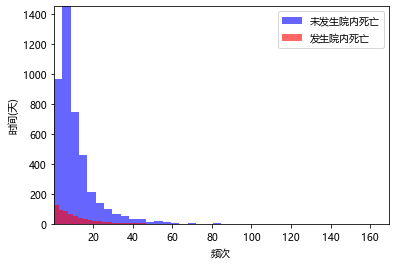

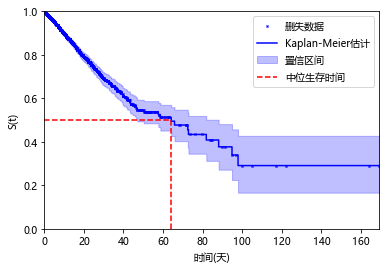

In [12]:

# 可视化绘图：整体生存函数与直方图
def all_hist_KM_plot(encodedat1):
    print("正在绘制生存时间直方图")

    fig, ax = plt.subplots()

    ax.hist(encodedat1.loc[encodedat1["event"] == 0, "duration"],color='b',alpha=0.6, bins=40, label='未发生院内死亡')
    ax.hist(encodedat1.loc[encodedat1["event"] == 1, "duration"],color='r',alpha=0.6, bins=40, label='发生院内死亡')
    ax.set_xlabel("频次")
    ax.set_ylabel("时间(天)")
    ax.legend(loc='upper right')
    ax.autoscale(tight=True)
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_total_survival_time_hist.svg"), dpi=600, format='svg')
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_total_survival_time_hist.pdf"), dpi=600)

    print("正在绘制生存时间KM估计-总体生存函数")
    kmf = KaplanMeierFitter()
    kmf.fit(encodedat1['duration'], event_observed=encodedat1['event'])
    fig, ax = plt.subplots()
    kmf.plot(show_censors=True, censor_styles={'ms': 2, 'marker': 'x'}, color='b')

    plt.hlines(0.5, ls='--', color="r", xmin=0, xmax=kmf.median_survival_time_)
    plt.vlines(kmf.median_survival_time_, ls='--', color="r", ymin=0, ymax=0.5, label='中位生存时间')
    
    ax.set_xlabel("时间(天)")
    ax.set_ylabel("S(t)")
    plt.legend(loc='upper right')
    plt.legend(['删失数据', 'Kaplan-Meier估计', '置信区间',"中位生存时间"])
    ax.autoscale(tight=True)
    
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_total_survival_time_fuction_km.svg"), dpi=600, format='svg')
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_total_survival_time_fuction_km.pdf"), dpi=600)

# 绘制整体生存曲线
all_hist_KM_plot(df_train)

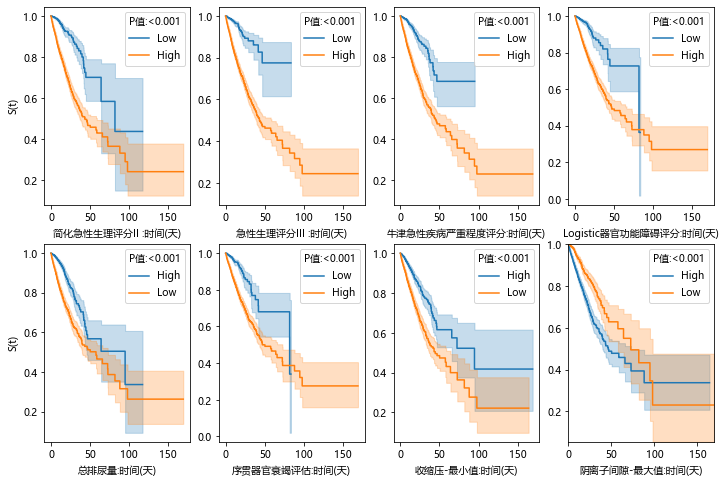

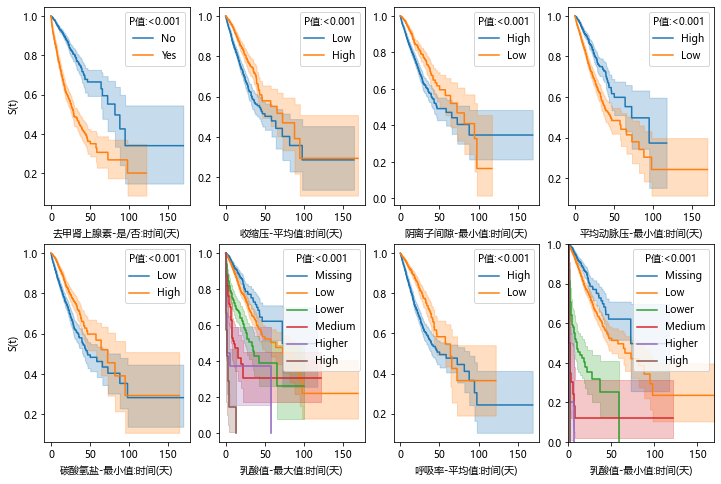

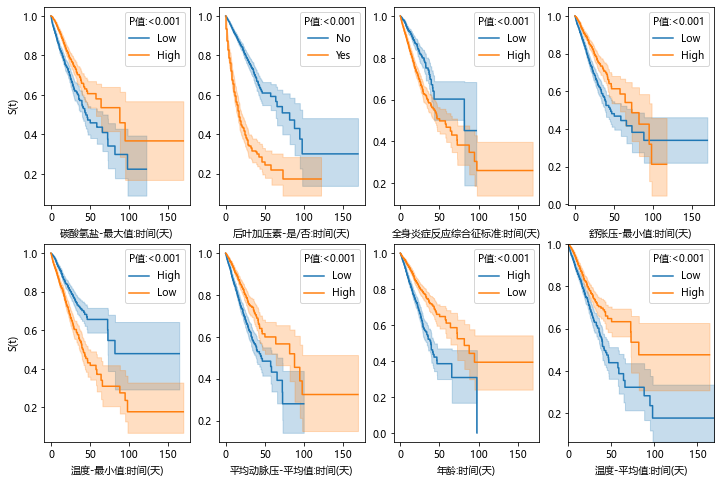

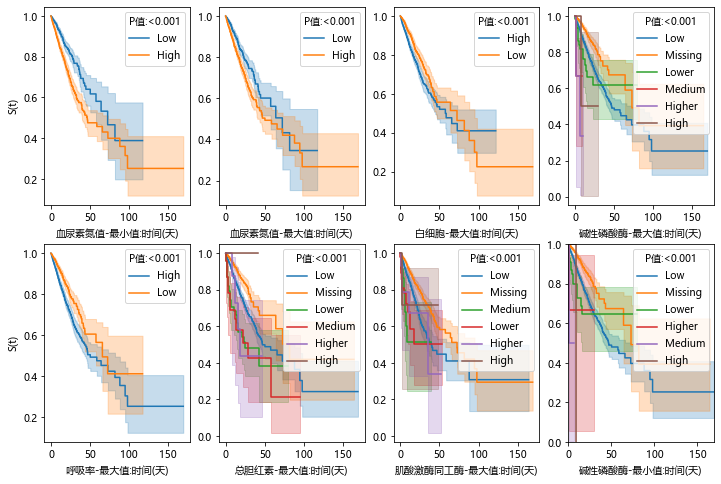

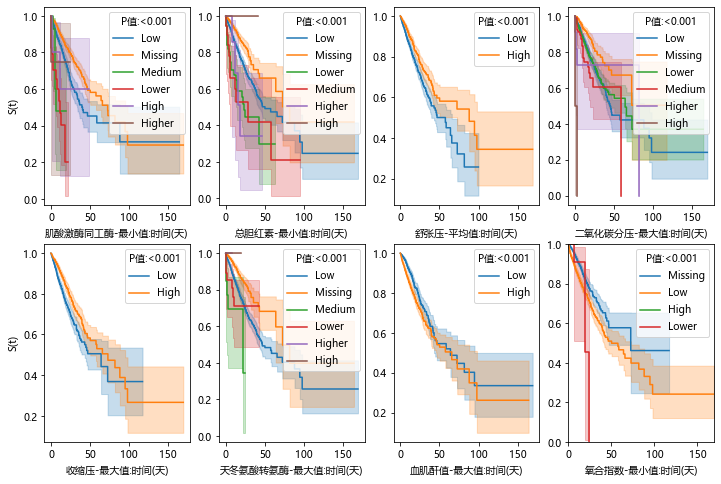

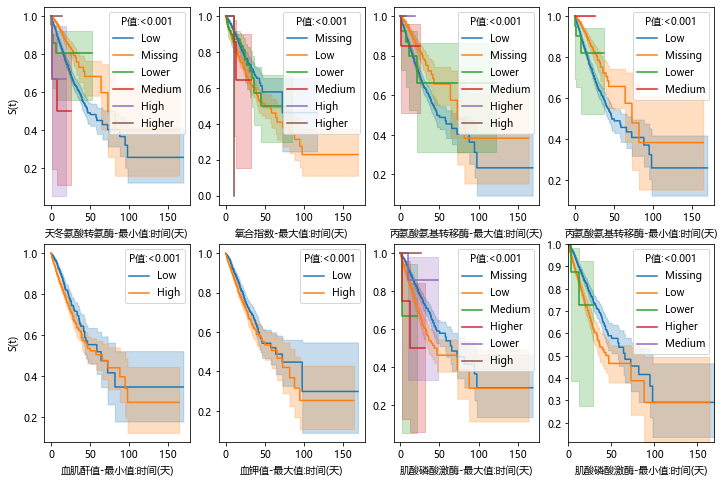

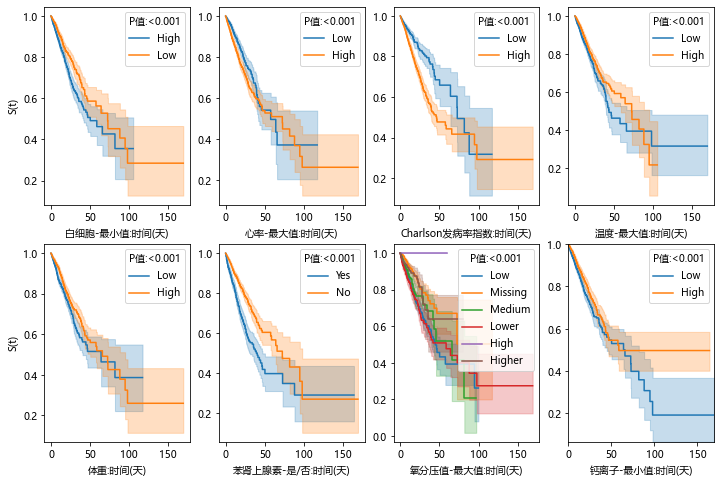

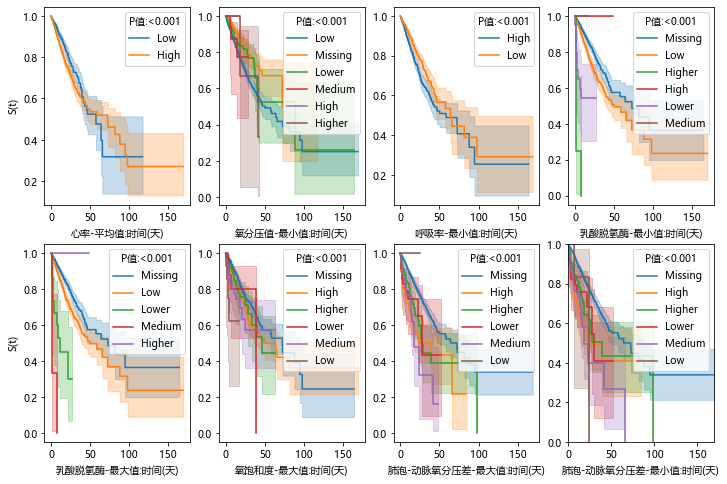

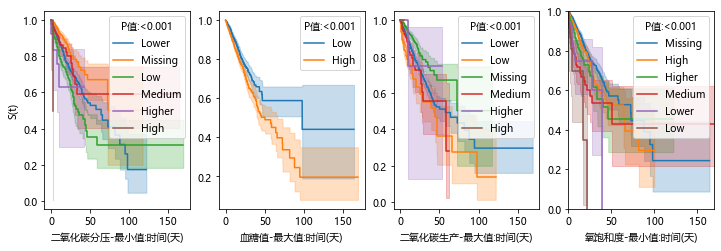

In [20]:
# 各变量的K-M曲线组图
def km_pairs_plot(dat, cols,dict_dat, type="standardize"):
    if type == "standardize":
        encodedat = dat.copy()
        for col in cols:
            encodedat[col] = dat[col].apply(lambda x: "Low" if x < dat[col].median() else "High")
    elif type == "onehot":
        encodedat = dat.copy()
        for col in cols:
            if set(encodedat[col].unique().tolist()) <= set(["Missing",0,1]):
                encodedat[col] = dat[col].map({0:"False",1:"Yes"})
            if col == "first_careunit" or col == "last_careunit":
                encodedat[col] = dat[col].map(MAPCODE2)
    else:
        encodedat = dat.copy()


    flag = 0
    f = 0
    for feature in cols:
        if flag % 8 == 0 :
            flag = 0
            fig  = plt.figure(figsize=(12,8))
            
        figax = plt.subplot(2,4,flag+1)
        for v in encodedat[feature].unique():
            df_tmp = encodedat.loc[encodedat[feature] == v]
            if len(df_tmp) == 0:
                        continue
            # KaplanMeier检验
            kmf = KaplanMeierFitter()
            kmf.fit(df_tmp["duration"], df_tmp["event"], label=v)
            # 绘制生存曲线
            kmf.plot_survival_function()
            
        logrank = multivariate_logrank_test(encodedat["duration"], encodedat[feature], encodedat["event"])
        
        if flag in [0,4]:
            plt.ylabel("S(t)")
        else:
            plt.ylabel("")
        xlable = dict_dat.loc[dict_dat["变量名"]==feature,"中文变量名"].to_list()[0]
        plt.xlabel("{}:时间(天)".format(xlable))

        plt.legend(loc="upper right",title="P值:{}".format(['<0.001' if logrank.p_value < 0.001 else '%.4F' % logrank.p_value][0]))

        flag += 1

        if flag % 8 == 0 or (f==8*(len(cols)//8) and flag == len(cols)%8):
            f += 8
            plt.autoscale(tight=True)
            plt.savefig(os.path.join(OUTPUT_FILE, "plot_{}_variables_group_km_{}.svg".format(type,f//8)), dpi=600, format='svg')
            plt.savefig(os.path.join(OUTPUT_FILE, "plot_{}_variables_group_km_{}.pdf".format(type,f//8)), dpi=600)


# 绘制各个变量的K-M曲线
dictdat = selec_val_info_tab3.drop_duplicates("变量名")
km_pairs_plot(df_train2,cols=selec_var[0:-2], dict_dat=dictdat, type="all")



### 建模-特征转换

In [21]:
# 特征转换
def feature_transfer(cols_standardize, cols_leave, cols_categorical, df_train, df_val, df_test):
    standardize = [([col], StandardScaler()) for col in cols_standardize]
    leave = [(col, None) for col in cols_leave]
    categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

    x_mapper_float = DataFrameMapper(standardize + leave)
    x_mapper_long = DataFrameMapper(categorical)

    x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
    x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

    x_train = x_fit_transform(df_train)
    x_val = x_transform(df_val)
    x_test = x_transform(df_test)
    x_train = np.concatenate((x_train[0], x_train[1]), axis=1).astype("float32")
    x_val = np.concatenate((x_val[0], x_val[1]), axis=1).astype("float32")
    x_test = np.concatenate((x_test[0], x_test[1]), axis=1).astype("float32")
    return x_train, x_val, x_test


x_train, x_val, x_test = feature_transfer(cols_standardize2, cols_leave2, cols_categorical2, df_train, df_val, df_test)



### 建模

### 建模-Cox比例风险模型

In [168]:
x_train = pd.DataFrame(x_train, index=df_train.index, columns=df_train.columns.drop(["duration","event"]))
x_val = pd.DataFrame(x_val, index=df_val.index, columns=df_val.columns.drop(["duration","event"]))
x_test = pd.DataFrame(x_test, index=df_test.index, columns=df_test.columns.drop(["duration","event"]))

_,y_train = sksurv.datasets.get_x_y(df_train,attr_labels=["event","duration"],pos_label=0)
_,y_val = sksurv.datasets.get_x_y(df_val,attr_labels=["event","duration"],pos_label=0)
_,y_test = sksurv.datasets.get_x_y(df_test,attr_labels=["event","duration"],pos_label=0)


In [169]:
# 绘制 惩罚Cox的系数变化图
def plot_coefficients(modeltype,coefs, n_highlight,best_alpha=None):
    _, ax = plt.subplots(figsize=(6.0, 4.0))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center" )
    if best_alpha:
        ax.axvline(best_alpha, c="grey", linestyle="--")
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.set_xlabel("alpha")
    ax.set_ylabel("系数")
    
#     plt.autoscale(tight=True)
#     plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_{}_coef_with_aplha.svg".format(modeltype)), dpi=600, format='svg')
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_{}_coef_with_aplha.pdf".format(modeltype)), dpi=600)


    return top_coefs

### 模型-CoxElastic

In [170]:
# 参数搜索寻找最佳alpha
coxnet_pipe = make_pipeline(
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=100)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(x_train, y_train)

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
coxnet_gcv = GridSearchCV(
        make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.9)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv)
coxnet_gcv.fit(x_train, y_train)

coxnet_gcv_cv_results = pd.DataFrame(coxnet_gcv.cv_results_)

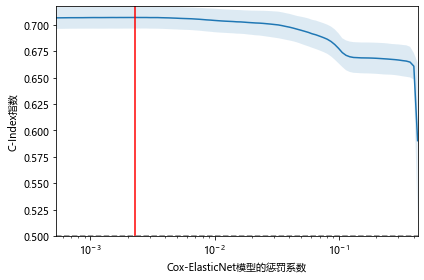

In [171]:
# alpha寻优过程
alphas = coxnet_gcv_cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = coxnet_gcv_cv_results.mean_test_score
std = coxnet_gcv_cv_results.std_test_score

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("C-Index指数")
ax.set_xlabel("Cox-ElasticNet模型的惩罚系数")
ax.axvline(coxnet_gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="r")
ax.axhline(0.5, color="grey", linestyle="--")


plt.autoscale(tight=True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FILE, "plot_elasticcox_alpha_optim.svg"), dpi=600, format='svg')
plt.savefig(os.path.join(OUTPUT_FILE, "plot_elasticcox_alpha_optim.pdf"), dpi=600)


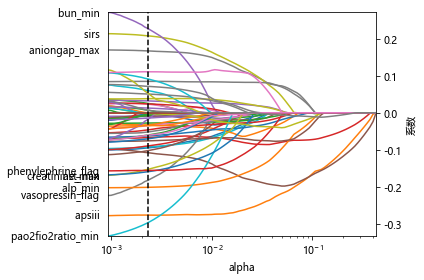

In [172]:
# 绘制 惩罚Cox的系数变化图
def plot_coefficients(modeltype,coefs, n_highlight,best_alpha=None):
    _, ax = plt.subplots(figsize=(6.0, 4.0))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:],'-',  label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center" )
    if best_alpha:
        ax.axvline(best_alpha, c="k", linestyle="--")
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.set_xlabel("alpha")
    ax.set_ylabel("系数")
    
    plt.autoscale(tight=True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_{}_coef_with_aplha.svg".format(modeltype)), dpi=600, format='svg')
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_{}_coef_with_aplha.pdf".format(modeltype)), dpi=600)


    return top_coefs

# Elastic Net Cox
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001)
cox_elastic_net.fit(x_train, y_train)

coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=x_train.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

elasticcox_top_coefs = plot_coefficients("elasticcox",
                                         coefficients_elastic_net, 
                                         n_highlight=10,
                                         best_alpha=coxnet_gcv.best_params_["coxnetsurvivalanalysis__alphas"][0])


important_elastic_coefs = pd.merge(pd.DataFrame(elasticcox_top_coefs),dictdat,left_index=True,right_on="变量名",how="left")
log_print("Elastic Net Cox模型的top 系数变量：",important_elastic_coefs["中文变量名"].values)

In [173]:
cox_net_model = make_pipeline(
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
cox_net_model.set_params(**coxnet_gcv.best_params_)
cox_net_model.fit(x_train, y_train)

Pipeline(steps=[('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.002296798736613155],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

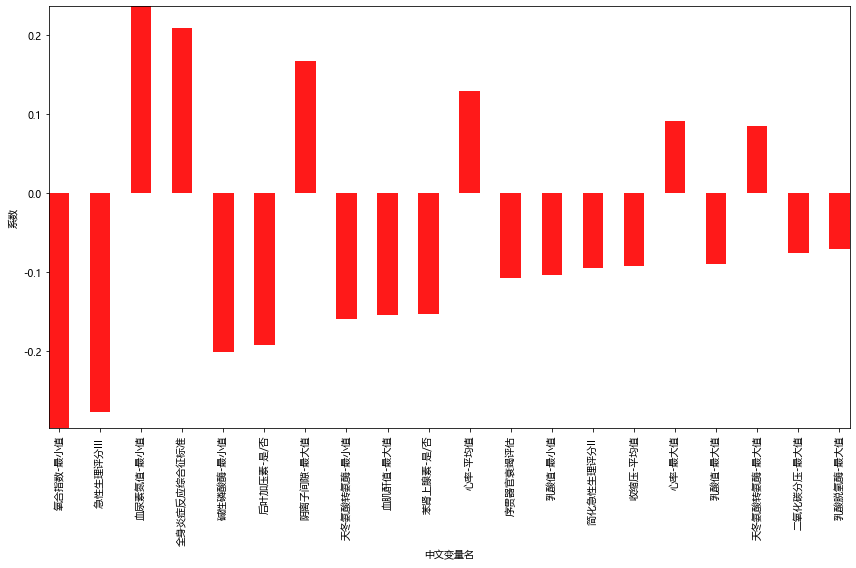

In [192]:
cox_net_model2 = coxnet_gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(cox_net_model2.coef_,index=x_train.columns,columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
log_print("Cox-ElasticNet选择的非零系数个数: ",non_zero)

non_zero_coefs = best_coefs.query("coefficient != 0")

non_zero_coefs2 = pd.merge(non_zero_coefs,dictdat,left_index=True,right_on="变量名",how="left")
non_zero_coefs2 = non_zero_coefs2[["中文变量名","coefficient"]].set_index("中文变量名")

coef_order = non_zero_coefs2.abs().sort_values("coefficient",ascending=False).head(20).index

log_print("危险因素",non_zero_coefs2.loc[non_zero_coefs2["coefficient"]>0].index)
log_print("保护因素",non_zero_coefs2.loc[non_zero_coefs2["coefficient"]<0].index)


_, ax = plt.subplots(figsize=(12, 8))
non_zero_coefs2.loc[coef_order].plot.bar(ax=ax, legend=False,color='r',alpha=0.9)
ax.set_ylabel("系数")

plt.autoscale(tight=True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FILE, "plot_elasticcox_coefs_imporant_top20.svg"), dpi=600, format='svg')
plt.savefig(os.path.join(OUTPUT_FILE, "plot_elasticcox_coefs_imporant_top20.pdf"), dpi=600)


In [24]:
# Ridge Cox模型

# alphas = 10. ** np.linspace(-4, 4, 50)
# coefficients = {}

# cox_ridge = CoxPHSurvivalAnalysis()
# for alpha in alphas:
#     cox_ridge.set_params(alpha=alpha)
#     cox_ridge.fit(x_train, y_train)
#     key = round(alpha, 5)
#     coefficients[key] = cox_ridge.coef_

# coefficients = (pd.DataFrame
#     .from_dict(coefficients)
#     .rename_axis(index="feature", columns="alpha")
#     .set_index(x_train.columns))

# ridgecox_top_coefs = plot_coefficients("ridgecox",coefficients, n_highlight=10)
# log_print("Ridge Cox模型的top 系数变量：",ridgecox_top_coefs)

In [25]:
# Lasso Cox模型
# cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
# cox_lasso.fit(x_train, y_train)

# coefficients_lasso = pd.DataFrame(
#     cox_lasso.coef_,
#     index=x_train.columns,
#     columns=np.round(cox_lasso.alphas_, 5)
# )

# lassocox_top_coefs = plot_coefficients("lassocox",coefficients_lasso, n_highlight=10)
# log_print("Lasso Cox模型的top 系数变量：",lassocox_top_coefs)

### 建模-Cox机器学习模型

In [32]:
%%time
# 耗时较久
# 随机生存森林模型

cox_rsf_model = RandomSurvivalForest(random_state=RANDOM_STATE)
cox_rsf_model.fit(x_train, y_train)


Wall time: 6min 1s


RandomSurvivalForest(random_state=123456)

In [72]:
# # 变量重要性
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(rsf, n_iter=15, random_state=RANDOM_STATE)
# perm.fit(x_test, y_test)
# eli5.show_weights(perm, feature_names=x_train.columns.tolist())

In [ ]:
# 生存支持向量机
# estimator = FastSurvivalSVM(random_state=RANDOM_STATE)
# def score_survival_model(model, X, y):
#     prediction = model.predict(X)
#     result = concordance_index_censored(y['event'], y['duration'], prediction)
#     return result[0]

# param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
# cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
# gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
#                    n_jobs=4, refit=False,
#                    cv=cv)

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
# gcv = gcv.fit(x_train, y_train)

# print(round(gcv.best_score_, 3), gcv.best_params_)

# def plot_performance(gcv):
#     n_splits = gcv.cv.n_splits
#     cv_scores = {"alpha": [], "test_score": [], "split": []}
#     order = []
#     for i, params in enumerate(gcv.cv_results_["params"]):
#         name = "%.5f" % params["alpha"]
#         order.append(name)
#         for j in range(n_splits):
#             vs = gcv.cv_results_["split%d_test_score" % j][i]
#             cv_scores["alpha"].append(name)
#             cv_scores["test_score"].append(vs)
#             cv_scores["split"].append(j)
#     df = pandas.DataFrame.from_dict(cv_scores)
#     _, ax = plt.subplots(figsize=(11, 6))
#     sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
#     _, xtext = plt.xticks()
#     for t in xtext:
#         t.set_rotation("vertical")
# plot_performance(gcv)

### 评估

### 建模-深度生存分析

In [109]:
x_train, x_val, x_test = feature_transfer(cols_standardize2, cols_leave2, cols_categorical2, df_train, df_val, df_test)

class CoxParameterModels():
    """An example of classifier"""

    def __init__(self, 
                 modelname="coxcc",
                 lr=0.3,
                 batch_size=256,
                 dropout=0.1, 
                 optimizer=tt.optim.Adam,
                 nlayers=3,
                 nodes=[16]):
        
        
        self.nlayers = nlayers
        self.nodes = nodes
        self.dropout = dropout
        self.optimizer = optimizer
        self.lr = lr
        self.batch_size =  batch_size
        self.modelname = modelname
        
    def fit(self,x_train,df_train):

        
        parameters = {"nodes": self.nodes ,
                      "nlayers":self.nlayers,
                      "dropout": self.dropout,
                      "optimizer": self.optimizer,
                     "lr":self.lr,
                     "batch_size": self.batch_size,
                     "modelname":self.modelname}
        

        num_nodes = parameters["nodes"] * parameters["nlayers"]
        dropout = parameters["dropout"]
        optimizer = parameters["optimizer"]
        lr = parameters["lr"]
        batch_size =  parameters["batch_size"]
        modelname = parameters["modelname"]
        
        
        global df_val
        global x_val

        # 构建网络
        in_features = x_train.shape[1]
#         num_nodes = [32, 32]
        batch_norm = True
#         dropout = 0.2
        output_bias = False
        # 构造模型
#         optimizer = tt.optim.Adam
        tolerance = 10
        modelname = modelname
        alpha = 0.2
        sigma = 0.1
        # 训练模型
        batch_size = batch_size
        epochs = 512
        callbacks = [tt.callbacks.EarlyStopping()]
        verbose = True
#         lr = 0.1
        num_durations = 20
        
        
        if str.lower(modelname) == "coxtime":
            labtrans = CoxTime.label_transform()
        elif str.lower(modelname) == "deephit":
            labtrans = DeepHitSingle.label_transform(num_durations)
        elif str.lower(modelname) == "logistichazard":
            labtrans = LogisticHazard.label_transform(num_durations)
        elif str.lower(modelname) == "pmf":
            labtrans = PMF.label_transform(num_durations)
        elif str.lower(modelname) == "mtlr":
            labtrans = MTLR.label_transform(num_durations)
        elif str.lower(modelname) == "pchazard":
            labtrans = PCHazard.label_transform(num_durations)
        else:
            labtrans = None

        # 目标变量转换
        get_target = lambda df: (df['duration'].values, df['event'].values)

        if labtrans:
            y_train = labtrans.fit_transform(*get_target(df_train))
            y_val = labtrans.transform(*get_target(df_val))
            out_features = labtrans.out_features
        else:
            y_train = get_target(df_train)
            y_val = get_target(df_val)
            out_features = 1

        val = tt.tuplefy(x_val, y_val)
        print(str.lower(modelname))
        
        if str.lower(modelname) == "coxtime":
            net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
            model = CoxTime(net, optimizer, labtrans=labtrans)
        elif str.lower(modelname) == "coxcc":
            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
                                          output_bias=output_bias)
            model = CoxCC(net, optimizer)
        elif str.lower(modelname) == "deepsurv" or (str.lower(modelname) =='coxph'):
            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
                                          output_bias=output_bias)
            model = CoxPH(net, optimizer)
        elif str.lower(modelname) == "deephit":
            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
                                          output_bias=output_bias)
            model = DeepHitSingle(net, optimizer, alpha=alpha, sigma=sigma, duration_index=labtrans.cuts)
        elif str.lower(modelname) == "logistichazard":
            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
                                          output_bias=output_bias)
            model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)
        elif str.lower(modelname) == "pmf":
            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
                                          output_bias=output_bias)
            model = PMF(net, optimizer, duration_index=labtrans.cuts)
        elif str.lower(modelname) == "mtlr":
            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
                                          output_bias=output_bias)
            model = MTLR(net, optimizer, duration_index=labtrans.cuts)
        elif str.lower(modelname) == "pchazard":
            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
                                          output_bias=output_bias)
            model = PCHazard(net, optimizer, duration_index=labtrans.cuts)
        else:
            print("请输入正确模型名称")
            net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
                                          output_bias=output_bias)
            model = PCHazard(net, optimizer, duration_index=labtrans.cuts)
        
        if lr:
            model.optimizer.set_lr(lr)
        else:
            lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=tolerance)
            model.optimizer.set_lr(lrfinder.get_best_lr())
        
        self.model = model
        
        self.log = self.model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val.repeat(10).cat())
        
 
        return self


    def score(self, x_val,df_val):
        
        
        if self.modelname in ["coxcc", "coxtime", "deepsurv"]:
            print("正在计算预测结果")
            _ = self.model.compute_baseline_hazards()
            surv = self.model.predict_surv_df(x_val)
        else:
            print("正在计算预测结果")
            surv = self.model.predict_surv_df(x_val)
        
        ev = EvalSurv(surv, np.array(df_val["duration"]), np.array(df_val["event"]), censor_surv='km')
        self.concordance_td = ev.concordance_td('antolini')
        
        return self.concordance_td

    
    def partial_log_likelihood(val):
        return self.model.partial_log_likelihood(*val)
    
    def compute_baseline_hazards():
        return self.model.compute_baseline_hazards()
    
    def predict_surv_df():
        return self.model.predict_surv_df()
    
        
    def get_params(self, deep=False):

        params = {"nlayers": self.nlayers ,
                  "nodes":self.nodes,
                  "dropout": self.dropout,
                  "optimizer": self.optimizer,
                 "lr":self.lr,
                 "batch_size":self.batch_size,
                 "modelname":self.modelname}

        return params

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [83]:
%%time
# 网格搜索

warnings.filterwarnings("default")

model = CoxParameterModels()

parameters = {"nlayers": [1,2,3] ,
              "nodes":[[16,32]],
              "dropout": [0.2,0.4,0.6],
              "optimizer": [tt.optim.Adam],#,tt.optim.OptimWrap
             "lr":[0.1,0.3],
             "batch_size":[128,256],
             "modelname":["coxcc","coxtime","deepsurv","logistichazard"]}

cv = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
gs = GridSearchCV(model, parameters, cv=cv)

gird_result = gs.fit(x_train,df_train)

print("Best: %f using %s" % (gird_result.best_score_, gird_result.best_params_))
log_print("超参数搜索范围：",parameters)


coxcc
0:	[0s / 0s],		train_loss: 0.5813,	val_loss: 0.8544
1:	[0s / 0s],		train_loss: 0.5583,	val_loss: 0.5306
2:	[0s / 0s],		train_loss: 0.4935,	val_loss: 0.5324
3:	[0s / 0s],		train_loss: 0.4671,	val_loss: 0.5151
4:	[0s / 0s],		train_loss: 0.4949,	val_loss: 0.5014
5:	[0s / 0s],		train_loss: 0.4373,	val_loss: 0.4900
6:	[0s / 0s],		train_loss: 0.4352,	val_loss: 0.5062
7:	[0s / 0s],		train_loss: 0.4184,	val_loss: 0.4948
8:	[0s / 0s],		train_loss: 0.3747,	val_loss: 0.5355
9:	[0s / 0s],		train_loss: 0.4385,	val_loss: 0.5199
10:	[0s / 0s],		train_loss: 0.4220,	val_loss: 0.4926
11:	[0s / 0s],		train_loss: 0.3945,	val_loss: 0.5259
12:	[0s / 0s],		train_loss: 0.4053,	val_loss: 0.5192
13:	[0s / 0s],		train_loss: 0.4212,	val_loss: 0.4794
14:	[0s / 0s],		train_loss: 0.3827,	val_loss: 0.5175
15:	[0s / 0s],		train_loss: 0.3708,	val_loss: 0.6073
16:	[0s / 0s],		train_loss: 0.4035,	val_loss: 0.4934
17:	[0s / 0s],		train_loss: 0.3959,	val_loss: 0.4835
18:	[0s / 0s],		train_loss: 0.4009,	val_loss: 0.51

18:	[0s / 1s],		train_loss: 0.3756,	val_loss: 0.5143
19:	[0s / 1s],		train_loss: 0.4310,	val_loss: 0.4764
20:	[0s / 1s],		train_loss: 0.4428,	val_loss: 0.4668
21:	[0s / 1s],		train_loss: 0.4158,	val_loss: 0.4763
22:	[0s / 1s],		train_loss: 0.4085,	val_loss: 0.4836
23:	[0s / 1s],		train_loss: 0.4131,	val_loss: 0.4638
24:	[0s / 1s],		train_loss: 0.3982,	val_loss: 0.4959
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.7232,	val_loss: 2.0733
1:	[0s / 0s],		train_loss: 0.5534,	val_loss: 2.7698
2:	[0s / 0s],		train_loss: 0.5124,	val_loss: 0.7915
3:	[0s / 0s],		train_loss: 0.4593,	val_loss: 0.7506
4:	[0s / 0s],		train_loss: 0.4353,	val_loss: 0.8060
5:	[0s / 0s],		train_loss: 0.4181,	val_loss: 0.6405
6:	[0s / 0s],		train_loss: 0.4146,	val_loss: 0.5209
7:	[0s / 0s],		train_loss: 0.4494,	val_loss: 0.5268
8:	[0s / 0s],		train_loss: 0.4364,	val_loss: 0.5166
9:	[0s / 0s],		train_loss: 0.4348,	val_loss: 0.4830
10:	[0s / 0s],		train_loss: 0.4303,	val_loss: 0.5439
11:	[0s / 0s],		train_loss: 0.4062,	val_l

4:	[0s / 0s],		train_loss: 0.4911,	val_loss: 0.6718
5:	[0s / 0s],		train_loss: 0.4959,	val_loss: 0.7037
6:	[0s / 0s],		train_loss: 0.4841,	val_loss: 0.5968
7:	[0s / 0s],		train_loss: 0.4547,	val_loss: 0.5733
8:	[0s / 0s],		train_loss: 0.4524,	val_loss: 0.6010
9:	[0s / 0s],		train_loss: 0.3989,	val_loss: 0.5493
10:	[0s / 0s],		train_loss: 0.4669,	val_loss: 0.5241
11:	[0s / 0s],		train_loss: 0.4251,	val_loss: 0.5003
12:	[0s / 0s],		train_loss: 0.4628,	val_loss: 0.4958
13:	[0s / 0s],		train_loss: 0.4021,	val_loss: 0.4774
14:	[0s / 1s],		train_loss: 0.4202,	val_loss: 0.5048
15:	[0s / 1s],		train_loss: 0.3784,	val_loss: 0.5174
16:	[0s / 1s],		train_loss: 0.3860,	val_loss: 0.5150
17:	[0s / 1s],		train_loss: 0.4057,	val_loss: 0.4811
18:	[0s / 1s],		train_loss: 0.4165,	val_loss: 0.5172
19:	[0s / 1s],		train_loss: 0.4343,	val_loss: 0.4984
20:	[0s / 1s],		train_loss: 0.3834,	val_loss: 0.5400
21:	[0s / 1s],		train_loss: 0.4189,	val_loss: 0.5147
22:	[0s / 1s],		train_loss: 0.4207,	val_loss: 0.4773

coxtime
0:	[0s / 0s],		train_loss: 0.8977,	val_loss: 0.6689
1:	[0s / 0s],		train_loss: 0.5454,	val_loss: 1.6163
2:	[0s / 0s],		train_loss: 0.8274,	val_loss: 0.7528
3:	[0s / 0s],		train_loss: 0.4963,	val_loss: 0.6608
4:	[0s / 0s],		train_loss: 0.5318,	val_loss: 0.6895
5:	[0s / 0s],		train_loss: 0.5179,	val_loss: 0.5677
6:	[0s / 0s],		train_loss: 0.8333,	val_loss: 0.5331
7:	[0s / 0s],		train_loss: 0.7668,	val_loss: 0.5948
8:	[0s / 0s],		train_loss: 0.4563,	val_loss: 0.5486
9:	[0s / 0s],		train_loss: 0.4249,	val_loss: 0.5811
10:	[0s / 0s],		train_loss: 0.5318,	val_loss: 0.5082
11:	[0s / 0s],		train_loss: 0.4467,	val_loss: 0.4932
12:	[0s / 0s],		train_loss: 0.4242,	val_loss: 0.5511
13:	[0s / 0s],		train_loss: 0.4888,	val_loss: 0.5204
14:	[0s / 0s],		train_loss: 0.6229,	val_loss: 0.5176
15:	[0s / 0s],		train_loss: 0.6346,	val_loss: 0.5867
16:	[0s / 0s],		train_loss: 0.5610,	val_loss: 0.6943
17:	[0s / 0s],		train_loss: 0.5326,	val_loss: 0.5864
18:	[0s / 0s],		train_loss: 0.5388,	val_loss: 0.

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 0.7441,	val_loss: 0.9669
1:	[0s / 0s],		train_loss: 0.5398,	val_loss: 1.8157
2:	[0s / 0s],		train_loss: 0.5593,	val_loss: 0.6807
3:	[0s / 0s],		train_loss: 0.5335,	val_loss: 0.6683
4:	[0s / 0s],		train_loss: 0.4785,	val_loss: 0.6623
5:	[0s / 0s],		train_loss: 0.4653,	val_loss: 0.5932
6:	[0s / 0s],		train_loss: 0.4782,	val_loss: 0.6228
7:	[0s / 0s],		train_loss: 0.4840,	val_loss: 0.5070
8:	[0s / 0s],		train_loss: 0.4537,	val_loss: 0.5455
9:	[0s / 0s],		train_loss: 0.4867,	val_loss: 0.5409
10:	[0s / 0s],		train_loss: 0.4289,	val_loss: 0.4983
11:	[0s / 0s],		train_loss: 0.4506,	val_loss: 0.4925
12:	[0s / 0s],		train_loss: 0.4290,	val_loss: 0.5011
13:	[0s / 0s],		train_loss: 0.4574,	val_loss: 0.4869
14:	[0s / 0s],		train_loss: 0.4423,	val_loss: 0.5127
15:	[0s / 0s],		train_loss: 0.4411,	val_loss: 0.4921
16:	[0s / 0s],		train_loss: 0.4203,	val_loss: 0.5168
17:	[0s / 0s],		train_loss: 0.4228,	val_loss: 0.4913
18:	[0s / 0s],		train_loss: 0.4838,	val_loss: 0.

10:	[0s / 0s],		train_loss: 0.4850,	val_loss: 0.5924
11:	[0s / 0s],		train_loss: 0.5166,	val_loss: 0.4948
12:	[0s / 0s],		train_loss: 0.4842,	val_loss: 0.5248
13:	[0s / 0s],		train_loss: 0.5183,	val_loss: 0.5260
14:	[0s / 0s],		train_loss: 0.4642,	val_loss: 0.5184
15:	[0s / 1s],		train_loss: 0.4911,	val_loss: 0.5146
16:	[0s / 1s],		train_loss: 0.4670,	val_loss: 0.4926
17:	[0s / 1s],		train_loss: 0.4629,	val_loss: 0.4765
18:	[0s / 1s],		train_loss: 0.4245,	val_loss: 0.5085
19:	[0s / 1s],		train_loss: 0.4661,	val_loss: 0.4907
20:	[0s / 1s],		train_loss: 0.4206,	val_loss: 0.4924
21:	[0s / 1s],		train_loss: 0.4393,	val_loss: 0.5293
22:	[0s / 1s],		train_loss: 0.4554,	val_loss: 0.5018
23:	[0s / 1s],		train_loss: 0.4206,	val_loss: 0.5119
24:	[0s / 1s],		train_loss: 0.4414,	val_loss: 0.5331
25:	[0s / 1s],		train_loss: 0.4408,	val_loss: 0.5007
26:	[0s / 1s],		train_loss: 0.4410,	val_loss: 0.5437
27:	[0s / 1s],		train_loss: 0.4507,	val_loss: 0.4893
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.

18:	[0s / 2s],		train_loss: 3.2255,	val_loss: 8.8501
19:	[0s / 2s],		train_loss: 3.1873,	val_loss: 5.6940
20:	[0s / 2s],		train_loss: 3.1698,	val_loss: 5.8012
21:	[0s / 2s],		train_loss: 3.2321,	val_loss: 5.7389
22:	[0s / 2s],		train_loss: 3.2147,	val_loss: 5.7140
23:	[0s / 2s],		train_loss: 3.1245,	val_loss: 5.6895
24:	[0s / 2s],		train_loss: 3.1697,	val_loss: 5.6140
25:	[0s / 2s],		train_loss: 3.2007,	val_loss: 81.2403
26:	[0s / 2s],		train_loss: 3.1700,	val_loss: 5.6222
27:	[0s / 2s],		train_loss: 3.1659,	val_loss: 34.5664
28:	[0s / 2s],		train_loss: 3.1254,	val_loss: 11.3286
29:	[0s / 3s],		train_loss: 3.1566,	val_loss: 5.7900
30:	[0s / 3s],		train_loss: 3.1617,	val_loss: 5.6319
31:	[0s / 3s],		train_loss: 3.1773,	val_loss: 5.6715
32:	[0s / 3s],		train_loss: 3.1209,	val_loss: 5.6247
33:	[0s / 3s],		train_loss: 3.1533,	val_loss: 5.6422
34:	[0s / 3s],		train_loss: 3.0398,	val_loss: 5.6977
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 3.7633,	val_loss: 5.8072
1:	[0s / 0s],		train_loss:

8:	[0s / 1s],		train_loss: 3.2347,	val_loss: 5.7028
9:	[0s / 1s],		train_loss: 3.2069,	val_loss: 5.8908
10:	[0s / 1s],		train_loss: 3.2192,	val_loss: 5.6223
11:	[0s / 1s],		train_loss: 3.2822,	val_loss: 5.7277
12:	[0s / 1s],		train_loss: 3.1418,	val_loss: 5.6490
13:	[0s / 2s],		train_loss: 3.1639,	val_loss: 5.6897
14:	[0s / 2s],		train_loss: 3.1985,	val_loss: 5.6602
15:	[0s / 2s],		train_loss: 3.2498,	val_loss: 5.7120
16:	[0s / 2s],		train_loss: 3.1906,	val_loss: 5.7723
17:	[0s / 2s],		train_loss: 3.0829,	val_loss: 5.6809
18:	[0s / 2s],		train_loss: 3.1702,	val_loss: 5.6987
19:	[0s / 2s],		train_loss: 3.1361,	val_loss: 6.6910
20:	[0s / 3s],		train_loss: 3.1689,	val_loss: 19.1183
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 3.7967,	val_loss: 6.1030
1:	[0s / 0s],		train_loss: 3.6334,	val_loss: 5.9702
2:	[0s / 0s],		train_loss: 3.5045,	val_loss: 5.9816
3:	[0s / 0s],		train_loss: 3.4652,	val_loss: 5.7021
4:	[0s / 1s],		train_loss: 3.3804,	val_loss: 5.8859
5:	[0s / 1s],		train_loss: 3.2817,

7:	[0s / 0s],		train_loss: 0.2986,	val_loss: 0.3200
8:	[0s / 0s],		train_loss: 0.2982,	val_loss: 0.3196
9:	[0s / 1s],		train_loss: 0.3036,	val_loss: 0.3126
10:	[0s / 1s],		train_loss: 0.2924,	val_loss: 0.3413
11:	[0s / 1s],		train_loss: 0.2971,	val_loss: 0.3125
12:	[0s / 1s],		train_loss: 0.2951,	val_loss: 0.3412
13:	[0s / 1s],		train_loss: 0.3009,	val_loss: 0.3236
14:	[0s / 1s],		train_loss: 0.2949,	val_loss: 0.3239
15:	[0s / 1s],		train_loss: 0.2914,	val_loss: 0.3244
16:	[0s / 1s],		train_loss: 0.2887,	val_loss: 0.3097
17:	[0s / 1s],		train_loss: 0.2970,	val_loss: 0.3380
18:	[0s / 1s],		train_loss: 0.2888,	val_loss: 0.3382
19:	[0s / 2s],		train_loss: 0.2956,	val_loss: 0.3357
20:	[0s / 2s],		train_loss: 0.3128,	val_loss: 0.3375
21:	[0s / 2s],		train_loss: 0.3012,	val_loss: 0.3251
22:	[0s / 2s],		train_loss: 0.2829,	val_loss: 0.3259
23:	[0s / 2s],		train_loss: 0.2845,	val_loss: 0.3358
24:	[0s / 2s],		train_loss: 0.3041,	val_loss: 0.3574
25:	[0s / 2s],		train_loss: 0.2913,	val_loss: 0.3

8:	[0s / 1s],		train_loss: 0.3284,	val_loss: 0.3221
9:	[0s / 1s],		train_loss: 0.3311,	val_loss: 0.3240
10:	[0s / 1s],		train_loss: 0.3171,	val_loss: 0.3234
11:	[0s / 1s],		train_loss: 0.3116,	val_loss: 0.3230
12:	[0s / 2s],		train_loss: 0.3225,	val_loss: 0.3067
13:	[0s / 2s],		train_loss: 0.3290,	val_loss: 0.3586
14:	[0s / 2s],		train_loss: 0.3294,	val_loss: 0.3261
15:	[0s / 2s],		train_loss: 0.3189,	val_loss: 0.3015
16:	[0s / 2s],		train_loss: 0.3189,	val_loss: 0.3195
17:	[0s / 2s],		train_loss: 0.3247,	val_loss: 0.3076
18:	[0s / 2s],		train_loss: 0.3174,	val_loss: 0.3118
19:	[0s / 3s],		train_loss: 0.3474,	val_loss: 0.3534
20:	[0s / 3s],		train_loss: 0.3229,	val_loss: 0.3277
21:	[0s / 3s],		train_loss: 0.3198,	val_loss: 0.3009
22:	[0s / 3s],		train_loss: 0.3171,	val_loss: 0.3165
23:	[0s / 3s],		train_loss: 0.3183,	val_loss: 0.3022
24:	[0s / 3s],		train_loss: 0.3087,	val_loss: 0.3101
25:	[0s / 3s],		train_loss: 0.3047,	val_loss: 0.3394
26:	[0s / 3s],		train_loss: 0.3158,	val_loss: 0.

12:	[0s / 2s],		train_loss: 0.3330,	val_loss: 0.3346
13:	[0s / 2s],		train_loss: 0.3386,	val_loss: 0.3304
14:	[0s / 3s],		train_loss: 0.3394,	val_loss: 0.3305
15:	[0s / 3s],		train_loss: 0.3333,	val_loss: 0.3064
16:	[0s / 3s],		train_loss: 0.3357,	val_loss: 0.3359
17:	[0s / 3s],		train_loss: 0.3302,	val_loss: 0.3635
18:	[0s / 4s],		train_loss: 0.3492,	val_loss: 0.3413
19:	[0s / 4s],		train_loss: 0.3440,	val_loss: 0.3292
20:	[0s / 4s],		train_loss: 0.3491,	val_loss: 0.3409
21:	[0s / 4s],		train_loss: 0.3470,	val_loss: 0.3369
22:	[0s / 4s],		train_loss: 0.3500,	val_loss: 0.3485
23:	[0s / 5s],		train_loss: 0.3462,	val_loss: 0.3444
24:	[0s / 5s],		train_loss: 0.3493,	val_loss: 0.3280
25:	[0s / 5s],		train_loss: 0.3447,	val_loss: 0.3199
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.6989,	val_loss: 0.4700
1:	[0s / 0s],		train_loss: 0.4374,	val_loss: 0.4228
2:	[0s / 0s],		train_loss: 0.4038,	val_loss: 0.4012
3:	[0s / 0s],		train_loss: 0.4021,	val_loss: 0.3769
4:	[0s / 1s],		train_loss:

28:	[0s / 1s],		train_loss: 0.6075,	val_loss: 0.5435
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 1.3893,	val_loss: 3.1881
1:	[0s / 0s],		train_loss: 0.8158,	val_loss: 2.2303
2:	[0s / 0s],		train_loss: 0.6823,	val_loss: 1.3302
3:	[0s / 0s],		train_loss: 0.6261,	val_loss: 0.6823
4:	[0s / 0s],		train_loss: 0.5609,	val_loss: 0.8646
5:	[0s / 0s],		train_loss: 0.5939,	val_loss: 0.6551
6:	[0s / 0s],		train_loss: 0.5308,	val_loss: 0.5805
7:	[0s / 0s],		train_loss: 0.4579,	val_loss: 0.5512
8:	[0s / 0s],		train_loss: 0.4861,	val_loss: 0.5135
9:	[0s / 0s],		train_loss: 0.5009,	val_loss: 0.4763
10:	[0s / 0s],		train_loss: 0.5134,	val_loss: 0.4843
11:	[0s / 0s],		train_loss: 0.4692,	val_loss: 0.4853
12:	[0s / 0s],		train_loss: 0.4886,	val_loss: 0.5042
13:	[0s / 0s],		train_loss: 0.4522,	val_loss: 0.4925
14:	[0s / 0s],		train_loss: 0.4799,	val_loss: 0.4910
15:	[0s / 0s],		train_loss: 0.4455,	val_loss: 0.4951
16:	[0s / 0s],		train_loss: 0.4177,	val_loss: 0.5318
17:	[0s / 0s],		train_loss: 0.4367,	val_l

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))


coxcc
0:	[0s / 0s],		train_loss: 1.5869,	val_loss: 11.1665
1:	[0s / 0s],		train_loss: 0.6981,	val_loss: 2.9753
2:	[0s / 0s],		train_loss: 0.6553,	val_loss: 2.5968
3:	[0s / 0s],		train_loss: 0.6353,	val_loss: 1.1274
4:	[0s / 0s],		train_loss: 0.6360,	val_loss: 0.7564
5:	[0s / 0s],		train_loss: 0.5925,	val_loss: 0.7891
6:	[0s / 0s],		train_loss: 0.5943,	val_loss: 0.6112
7:	[0s / 0s],		train_loss: 0.5440,	val_loss: 0.6507
8:	[0s / 0s],		train_loss: 0.5813,	val_loss: 0.4918
9:	[0s / 0s],		train_loss: 0.5224,	val_loss: 0.5100
10:	[0s / 0s],		train_loss: 0.5299,	val_loss: 0.5421
11:	[0s / 0s],		train_loss: 0.5519,	val_loss: 0.5039
12:	[0s / 0s],		train_loss: 0.5077,	val_loss: 0.5016
13:	[0s / 0s],		train_loss: 0.5109,	val_loss: 0.5014
14:	[0s / 0s],		train_loss: 0.4829,	val_loss: 0.4940
15:	[0s / 0s],		train_loss: 0.5017,	val_loss: 0.4980
16:	[0s / 0s],		train_loss: 0.4961,	val_loss: 0.5140
17:	[0s / 0s],		train_loss: 0.4900,	val_loss: 0.4944
18:	[0s / 1s],		train_loss: 0.4964,	val_loss: 0.5

7:	[0s / 0s],		train_loss: 0.5604,	val_loss: 0.7291
8:	[0s / 0s],		train_loss: 0.5706,	val_loss: 0.6323
9:	[0s / 0s],		train_loss: 0.6037,	val_loss: 0.5218
10:	[0s / 0s],		train_loss: 0.5545,	val_loss: 0.5347
11:	[0s / 0s],		train_loss: 0.5007,	val_loss: 0.4982
12:	[0s / 0s],		train_loss: 0.4951,	val_loss: 0.5621
13:	[0s / 0s],		train_loss: 0.5714,	val_loss: 0.4975
14:	[0s / 1s],		train_loss: 0.5437,	val_loss: 0.5264
15:	[0s / 1s],		train_loss: 0.5041,	val_loss: 0.5007
16:	[0s / 1s],		train_loss: 0.5591,	val_loss: 0.5055
17:	[0s / 1s],		train_loss: 0.5394,	val_loss: 0.5048
18:	[0s / 1s],		train_loss: 0.5080,	val_loss: 0.5055
19:	[0s / 1s],		train_loss: 0.5616,	val_loss: 0.5560
20:	[0s / 1s],		train_loss: 0.5579,	val_loss: 0.5245
21:	[0s / 1s],		train_loss: 0.5630,	val_loss: 0.5018
22:	[0s / 1s],		train_loss: 0.5412,	val_loss: 0.5051
23:	[0s / 1s],		train_loss: 0.4878,	val_loss: 0.5465
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 1.3479,	val_loss: 42.6334
1:	[0s / 0s],		train_loss: 0.8015,

20:	[0s / 1s],		train_loss: 0.6298,	val_loss: 0.5605
21:	[0s / 1s],		train_loss: 0.4829,	val_loss: 0.6186
22:	[0s / 1s],		train_loss: 0.5693,	val_loss: 0.5641
23:	[0s / 1s],		train_loss: 0.6713,	val_loss: 0.4836
24:	[0s / 1s],		train_loss: 0.5077,	val_loss: 0.5106
25:	[0s / 1s],		train_loss: 0.6201,	val_loss: 0.5001
26:	[0s / 1s],		train_loss: 0.6339,	val_loss: 0.6080
27:	[0s / 1s],		train_loss: 0.6371,	val_loss: 0.5256
28:	[0s / 1s],		train_loss: 0.8979,	val_loss: 0.5468
29:	[0s / 1s],		train_loss: 0.6545,	val_loss: 0.5315
30:	[0s / 1s],		train_loss: 0.7486,	val_loss: 0.5077
31:	[0s / 1s],		train_loss: 0.8212,	val_loss: 0.5933
32:	[0s / 1s],		train_loss: 1.0844,	val_loss: 0.9021
33:	[0s / 2s],		train_loss: 0.7983,	val_loss: 0.7056
正在计算预测结果


D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 1.0176,	val_loss: 2.3558
1:	[0s / 0s],		train_loss: 0.5780,	val_loss: 0.9661
2:	[0s / 0s],		train_loss: 0.5530,	val_loss: 0.9925
3:	[0s / 0s],		train_loss: 0.5556,	val_loss: 0.7125
4:	[0s / 0s],		train_loss: 0.5208,	val_loss: 0.5925
5:	[0s / 0s],		train_loss: 0.5832,	val_loss: 0.5090
6:	[0s / 0s],		train_loss: 0.5263,	val_loss: 0.6023
7:	[0s / 0s],		train_loss: 0.5978,	val_loss: 0.5660
8:	[0s / 0s],		train_loss: 0.5542,	val_loss: 0.6007
9:	[0s / 0s],		train_loss: 0.5470,	val_loss: 0.5354
10:	[0s / 0s],		train_loss: 0.5314,	val_loss: 0.4892
11:	[0s / 0s],		train_loss: 0.5343,	val_loss: 0.5048
12:	[0s / 0s],		train_loss: 0.4843,	val_loss: 0.5043
13:	[0s / 0s],		train_loss: 0.4999,	val_loss: 0.4860
14:	[0s / 0s],		train_loss: 0.5095,	val_loss: 0.5178
15:	[0s / 0s],		train_loss: 0.4826,	val_loss: 0.5328
16:	[0s / 0s],		train_loss: 0.4850,	val_loss: 0.5366
17:	[0s / 0s],		train_loss: 0.4673,	val_loss: 0.5943
18:	[0s / 0s],		train_loss: 0.5295,	val_loss: 0.

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:86: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((sub, t), batch_size, True, eval_, num_workers=num_workers)).flatten().sum()
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 1.3418,	val_loss: 13.6048
1:	[0s / 0s],		train_loss: 0.7551,	val_loss: 3.0040
2:	[0s / 0s],		train_loss: 0.6743,	val_loss: 1.4700
3:	[0s / 0s],		train_loss: 0.7289,	val_loss: 1.0032
4:	[0s / 0s],		train_loss: 0.6741,	val_loss: 1.4781
5:	[0s / 0s],		train_loss: 0.6758,	val_loss: 0.6145
6:	[0s / 0s],		train_loss: 0.5847,	val_loss: 1.0391
7:	[0s / 0s],		train_loss: 0.5270,	val_loss: 0.5774
8:	[0s / 0s],		train_loss: 0.5453,	val_loss: 0.5689
9:	[0s / 0s],		train_loss: 0.4990,	val_loss: 0.5139
10:	[0s / 0s],		train_loss: 0.5201,	val_loss: 0.5422
11:	[0s / 0s],		train_loss: 0.5181,	val_loss: 0.5195
12:	[0s / 0s],		train_loss: 0.4576,	val_loss: 0.5293
13:	[0s / 0s],		train_loss: 0.4836,	val_loss: 0.5252
14:	[0s / 0s],		train_loss: 0.5250,	val_loss: 0.5071
15:	[0s / 0s],		train_loss: 0.5371,	val_loss: 0.4977
16:	[0s / 0s],		train_loss: 0.5237,	val_loss: 0.5097
17:	[0s / 0s],		train_loss: 0.4931,	val_loss: 0.5761
18:	[0s / 0s],		train_loss: 0.5038,	val_loss: 0

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:86: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((sub, t), batch_size, True, eval_, num_workers=num_workers)).flatten().sum()
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 1.5618,	val_loss: 13.1972
1:	[0s / 0s],		train_loss: 0.7125,	val_loss: 5.4037
2:	[0s / 0s],		train_loss: 0.6596,	val_loss: 1.8092
3:	[0s / 0s],		train_loss: 0.6246,	val_loss: 1.5226
4:	[0s / 0s],		train_loss: 0.5867,	val_loss: 1.4169
5:	[0s / 0s],		train_loss: 0.5917,	val_loss: 0.8794
6:	[0s / 0s],		train_loss: 0.6222,	val_loss: 0.7070
7:	[0s / 0s],		train_loss: 0.6001,	val_loss: 0.5736
8:	[0s / 0s],		train_loss: 0.5662,	val_loss: 0.5329
9:	[0s / 0s],		train_loss: 0.4876,	val_loss: 0.5665
10:	[0s / 0s],		train_loss: 0.5497,	val_loss: 0.5447
11:	[0s / 0s],		train_loss: 0.5506,	val_loss: 0.4778
12:	[0s / 0s],		train_loss: 0.5195,	val_loss: 0.5446
13:	[0s / 0s],		train_loss: 0.5014,	val_loss: 0.5094
14:	[0s / 0s],		train_loss: 0.5130,	val_loss: 0.5089
15:	[0s / 0s],		train_loss: 0.4988,	val_loss: 0.5094
16:	[0s / 0s],		train_loss: 0.4872,	val_loss: 0.4746
17:	[0s / 0s],		train_loss: 0.5167,	val_loss: 0.4774
18:	[0s / 1s],		train_loss: 0.4211,	val_loss: 0

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:86: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((sub, t), batch_size, True, eval_, num_workers=num_workers)).flatten().sum()
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 1.5779,	val_loss: 9.0755
1:	[0s / 0s],		train_loss: 0.8525,	val_loss: 11.8509
2:	[0s / 0s],		train_loss: 0.7820,	val_loss: 6.5030
3:	[0s / 0s],		train_loss: 0.7451,	val_loss: 2.6034
4:	[0s / 0s],		train_loss: 0.7103,	val_loss: 0.6201
5:	[0s / 0s],		train_loss: 0.7376,	val_loss: 0.6514
6:	[0s / 0s],		train_loss: 0.6990,	val_loss: 1.0082
7:	[0s / 0s],		train_loss: 0.7078,	val_loss: 0.6736
8:	[0s / 0s],		train_loss: 0.5946,	val_loss: 0.8735
9:	[0s / 0s],		train_loss: 0.6134,	val_loss: 0.5328
10:	[0s / 0s],		train_loss: 0.5831,	val_loss: 0.5800
11:	[0s / 0s],		train_loss: 0.5729,	val_loss: 0.5298
12:	[0s / 0s],		train_loss: 0.5748,	val_loss: 0.5338
13:	[0s / 0s],		train_loss: 0.5573,	val_loss: 0.5576
14:	[0s / 0s],		train_loss: 0.5600,	val_loss: 0.5130
15:	[0s / 0s],		train_loss: 0.5206,	val_loss: 0.5222
16:	[0s / 0s],		train_loss: 0.5124,	val_loss: 0.5422
17:	[0s / 1s],		train_loss: 0.5653,	val_loss: 0.5596
18:	[0s / 1s],		train_loss: 0.5053,	val_loss: 0

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


0:	[0s / 0s],		train_loss: 4.5634,	val_loss: 6.0304
1:	[0s / 0s],		train_loss: 3.5587,	val_loss: 5.7601
2:	[0s / 0s],		train_loss: 3.5798,	val_loss: 6.0023
3:	[0s / 0s],		train_loss: 3.3973,	val_loss: 5.7081
4:	[0s / 0s],		train_loss: 3.3844,	val_loss: 5.7202
5:	[0s / 0s],		train_loss: 3.5300,	val_loss: 5.6600
6:	[0s / 0s],		train_loss: 3.5771,	val_loss: 6.1664
7:	[0s / 0s],		train_loss: 3.5586,	val_loss: 5.6943
8:	[0s / 0s],		train_loss: 3.4425,	val_loss: 5.7253
9:	[0s / 0s],		train_loss: 3.5534,	val_loss: 5.9346
10:	[0s / 1s],		train_loss: 3.5848,	val_loss: 5.9643
11:	[0s / 1s],		train_loss: 3.6188,	val_loss: 5.7447
12:	[0s / 1s],		train_loss: 3.4595,	val_loss: 5.7233
13:	[0s / 1s],		train_loss: 3.3342,	val_loss: 5.7235
14:	[0s / 1s],		train_loss: 3.4034,	val_loss: 5.8262
15:	[0s / 1s],		train_loss: 3.5702,	val_loss: 5.7391
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 4.4425,	val_loss: 6.0885


D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


1:	[0s / 0s],		train_loss: 4.0092,	val_loss: 6.1272
2:	[0s / 0s],		train_loss: 3.8217,	val_loss: 6.3451
3:	[0s / 0s],		train_loss: 3.7729,	val_loss: 5.8367
4:	[0s / 0s],		train_loss: 3.5679,	val_loss: 5.8539
5:	[0s / 0s],		train_loss: 3.4179,	val_loss: 5.7312
6:	[0s / 0s],		train_loss: 3.4822,	val_loss: 5.8003
7:	[0s / 0s],		train_loss: 4.4772,	val_loss: 6.1285
8:	[0s / 0s],		train_loss: 4.1590,	val_loss: 5.7526
9:	[0s / 1s],		train_loss: 7.6419,	val_loss: 10.6237
10:	[0s / 1s],		train_loss: 9.4407,	val_loss: 6.5775
11:	[0s / 1s],		train_loss: 9.3269,	val_loss: 6.7982
12:	[0s / 1s],		train_loss: 22.5082,	val_loss: 14.9378
13:	[0s / 1s],		train_loss: 29.4035,	val_loss: 14.5526
14:	[0s / 1s],		train_loss: 17.4362,	val_loss: 7.2027
15:	[0s / 1s],		train_loss: 14.7240,	val_loss: 5.8788
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.0522,	val_loss: 6.2044
1:	[0s / 0s],		train_loss: 3.9750,	val_loss: 5.9797
2:	[0s / 0s],		train_loss: 3.6188,	val_loss: 5.9098
3:	[0s / 0s],		train_loss: 3.5864

19:	[0s / 3s],		train_loss: 18.1385,	val_loss: 6.1133
20:	[0s / 3s],		train_loss: 8.2996,	val_loss: 6.1105
21:	[0s / 3s],		train_loss: 6.4058,	val_loss: 6.2896
22:	[0s / 4s],		train_loss: 5.1473,	val_loss: 6.2181
23:	[0s / 4s],		train_loss: 8.3108,	val_loss: 6.1408
24:	[0s / 4s],		train_loss: 11.8928,	val_loss: 6.2224
25:	[0s / 4s],		train_loss: 24.5009,	val_loss: 6.1658
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.2302,	val_loss: 6.1136
1:	[0s / 0s],		train_loss: 4.0526,	val_loss: 6.2949
2:	[0s / 0s],		train_loss: 3.9703,	val_loss: 6.1838
3:	[0s / 0s],		train_loss: 5.1605,	val_loss: 8.3757
4:	[0s / 0s],		train_loss: 6.5847,	val_loss: 7.3946
5:	[0s / 1s],		train_loss: 13.4860,	val_loss: 6.3200
6:	[0s / 1s],		train_loss: 7.2748,	val_loss: 6.8386
7:	[0s / 1s],		train_loss: 5.4027,	val_loss: 6.2539
8:	[0s / 1s],		train_loss: 4.7644,	val_loss: 11.5197
9:	[0s / 1s],		train_loss: 5.8211,	val_loss: 6.4547
10:	[0s / 1s],		train_loss: 4.4982,	val_loss: 6.3894
正在计算预测结果
deepsurv
0:	[0s / 0s],		

15:	[0s / 2s],		train_loss: 0.7062,	val_loss: 0.5792
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.7996,	val_loss: 0.9609
1:	[0s / 0s],		train_loss: 0.5268,	val_loss: 0.4518
2:	[0s / 0s],		train_loss: 0.4905,	val_loss: 0.4775
3:	[0s / 0s],		train_loss: 0.4654,	val_loss: 0.4362
4:	[0s / 0s],		train_loss: 0.5304,	val_loss: 6.6453
5:	[0s / 0s],		train_loss: 0.5107,	val_loss: 0.3986
6:	[0s / 0s],		train_loss: 0.4844,	val_loss: 13.6814
7:	[0s / 1s],		train_loss: 0.6298,	val_loss: 0.4882
8:	[0s / 1s],		train_loss: 0.5616,	val_loss: 0.4330
9:	[0s / 1s],		train_loss: 0.5686,	val_loss: 0.5101
10:	[0s / 1s],		train_loss: 0.6085,	val_loss: 1.1581
11:	[0s / 1s],		train_loss: 0.5373,	val_loss: 1.0675
12:	[0s / 1s],		train_loss: 0.5228,	val_loss: 0.7072
13:	[0s / 1s],		train_loss: 0.5267,	val_loss: 0.4873
14:	[0s / 2s],		train_loss: 0.8406,	val_loss: 0.6141
15:	[0s / 2s],		train_loss: 1.2857,	val_loss: 0.8635
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.6944,	val_loss: 0.5986
1:	[0s /

13:	[0s / 0s],		train_loss: 0.4094,	val_loss: 0.4978
14:	[0s / 0s],		train_loss: 0.4342,	val_loss: 0.5040
15:	[0s / 0s],		train_loss: 0.4354,	val_loss: 0.4832
16:	[0s / 0s],		train_loss: 0.4485,	val_loss: 0.4974
17:	[0s / 0s],		train_loss: 0.4442,	val_loss: 0.4853
18:	[0s / 0s],		train_loss: 0.4278,	val_loss: 0.5008
19:	[0s / 1s],		train_loss: 0.4249,	val_loss: 0.4951
20:	[0s / 1s],		train_loss: 0.4060,	val_loss: 0.5131
21:	[0s / 1s],		train_loss: 0.4467,	val_loss: 0.4726
22:	[0s / 1s],		train_loss: 0.4259,	val_loss: 0.4625
23:	[0s / 1s],		train_loss: 0.4168,	val_loss: 0.5102
24:	[0s / 1s],		train_loss: 0.4337,	val_loss: 0.4810
25:	[0s / 1s],		train_loss: 0.4201,	val_loss: 0.4804
26:	[0s / 1s],		train_loss: 0.4326,	val_loss: 0.4912
27:	[0s / 1s],		train_loss: 0.4063,	val_loss: 0.5131
28:	[0s / 1s],		train_loss: 0.3862,	val_loss: 0.4790
29:	[0s / 1s],		train_loss: 0.3950,	val_loss: 0.4918
30:	[0s / 1s],		train_loss: 0.3732,	val_loss: 0.5239
31:	[0s / 1s],		train_loss: 0.3991,	val_loss: 

22:	[0s / 1s],		train_loss: 0.4344,	val_loss: 0.4743
23:	[0s / 1s],		train_loss: 0.4406,	val_loss: 0.4844
24:	[0s / 1s],		train_loss: 0.4454,	val_loss: 0.5010
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.7741,	val_loss: 0.7173
1:	[0s / 0s],		train_loss: 0.6045,	val_loss: 1.1968
2:	[0s / 0s],		train_loss: 0.6895,	val_loss: 0.9901
3:	[0s / 0s],		train_loss: 0.7305,	val_loss: 0.6205
4:	[0s / 0s],		train_loss: 0.6024,	val_loss: 0.8044
5:	[0s / 0s],		train_loss: 0.6153,	val_loss: 0.6439
6:	[0s / 0s],		train_loss: 0.5335,	val_loss: 0.5234
7:	[0s / 0s],		train_loss: 0.6475,	val_loss: 0.5373
8:	[0s / 0s],		train_loss: 0.5440,	val_loss: 0.5668
9:	[0s / 0s],		train_loss: 0.5409,	val_loss: 0.5322
10:	[0s / 0s],		train_loss: 0.6015,	val_loss: 0.5403
11:	[0s / 0s],		train_loss: 0.5939,	val_loss: 0.5302
12:	[0s / 0s],		train_loss: 0.7774,	val_loss: 0.5418
13:	[0s / 0s],		train_loss: 0.5827,	val_loss: 0.5275
14:	[0s / 0s],		train_loss: 0.8335,	val_loss: 0.5159
15:	[0s / 0s],		train_loss: 0.5603,	val_l

7:	[0s / 0s],		train_loss: 0.7668,	val_loss: 0.6769
8:	[0s / 0s],		train_loss: 0.7810,	val_loss: 0.6613
9:	[0s / 0s],		train_loss: 0.7002,	val_loss: 0.6472
10:	[0s / 0s],		train_loss: 0.7088,	val_loss: 0.6458
11:	[0s / 0s],		train_loss: 0.7538,	val_loss: 0.6464
12:	[0s / 0s],		train_loss: 0.7204,	val_loss: 0.6656
13:	[0s / 0s],		train_loss: 0.6887,	val_loss: 0.6615
14:	[0s / 0s],		train_loss: 0.8855,	val_loss: 0.6652
15:	[0s / 0s],		train_loss: 0.7514,	val_loss: 0.6781
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.7963,	val_loss: 0.7831
1:	[0s / 0s],		train_loss: 0.7756,	val_loss: 0.6236
2:	[0s / 0s],		train_loss: 0.7225,	val_loss: 0.8488
3:	[0s / 0s],		train_loss: 0.7126,	val_loss: 0.6692
4:	[0s / 0s],		train_loss: 0.7034,	val_loss: 0.6078
5:	[0s / 0s],		train_loss: 0.6947,	val_loss: 0.5895
6:	[0s / 0s],		train_loss: 0.6965,	val_loss: 0.5952
7:	[0s / 0s],		train_loss: 0.6975,	val_loss: 0.6140
8:	[0s / 0s],		train_loss: 0.6624,	val_loss: 0.5501
9:	[0s / 0s],		train_loss: 0.6216,	val_loss

3:	[0s / 0s],		train_loss: 0.5147,	val_loss: 0.4800
4:	[0s / 0s],		train_loss: 0.5091,	val_loss: 0.5050
5:	[0s / 0s],		train_loss: 0.5049,	val_loss: 0.4972
6:	[0s / 0s],		train_loss: 0.5009,	val_loss: 0.4837
7:	[0s / 0s],		train_loss: 0.5029,	val_loss: 0.4769
8:	[0s / 0s],		train_loss: 0.4828,	val_loss: 0.4803
9:	[0s / 0s],		train_loss: 0.4691,	val_loss: 0.4723
10:	[0s / 0s],		train_loss: 0.4288,	val_loss: 0.4678
11:	[0s / 0s],		train_loss: 0.4473,	val_loss: 0.4667
12:	[0s / 0s],		train_loss: 0.4551,	val_loss: 0.4987
13:	[0s / 0s],		train_loss: 0.4661,	val_loss: 0.4640
14:	[0s / 0s],		train_loss: 0.4439,	val_loss: 0.4653
15:	[0s / 0s],		train_loss: 0.4555,	val_loss: 0.4567
16:	[0s / 0s],		train_loss: 0.4957,	val_loss: 0.4755
17:	[0s / 0s],		train_loss: 0.4722,	val_loss: 0.4894
18:	[0s / 0s],		train_loss: 0.4764,	val_loss: 0.4862
19:	[0s / 0s],		train_loss: 0.4679,	val_loss: 0.4575
20:	[0s / 1s],		train_loss: 0.3956,	val_loss: 0.4884
21:	[0s / 1s],		train_loss: 0.4483,	val_loss: 0.4828


11:	[0s / 0s],		train_loss: 0.5136,	val_loss: 0.4601
12:	[0s / 0s],		train_loss: 0.5302,	val_loss: 0.4921
13:	[0s / 0s],		train_loss: 0.4889,	val_loss: 0.4972
14:	[0s / 0s],		train_loss: 0.4594,	val_loss: 0.5328
15:	[0s / 0s],		train_loss: 0.5551,	val_loss: 0.4828
16:	[0s / 0s],		train_loss: 0.4527,	val_loss: 0.4740
17:	[0s / 1s],		train_loss: 0.5215,	val_loss: 0.4998
18:	[0s / 1s],		train_loss: 0.4455,	val_loss: 0.4654
19:	[0s / 1s],		train_loss: 0.4868,	val_loss: 0.4695
20:	[0s / 1s],		train_loss: 0.4614,	val_loss: 0.4808
21:	[0s / 1s],		train_loss: 0.5584,	val_loss: 0.4900
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.8225,	val_loss: 1.8921
1:	[0s / 0s],		train_loss: 0.6798,	val_loss: 0.8508
2:	[0s / 0s],		train_loss: 0.6499,	val_loss: 1.0224
3:	[0s / 0s],		train_loss: 0.5871,	val_loss: 0.6728
4:	[0s / 0s],		train_loss: 0.5976,	val_loss: 0.6152
5:	[0s / 0s],		train_loss: 0.5439,	val_loss: 0.5648
6:	[0s / 0s],		train_loss: 0.4973,	val_loss: 0.5719
7:	[0s / 0s],		train_loss: 0.5431,	v

25:	[0s / 1s],		train_loss: 0.5043,	val_loss: 0.5045
26:	[0s / 1s],		train_loss: 0.4813,	val_loss: 0.4877
27:	[0s / 1s],		train_loss: 0.5451,	val_loss: 0.5087
28:	[0s / 1s],		train_loss: 0.4733,	val_loss: 0.4883
29:	[0s / 1s],		train_loss: 0.4636,	val_loss: 0.5083
30:	[0s / 1s],		train_loss: 0.5556,	val_loss: 0.5162
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.8696,	val_loss: 1.4901
1:	[0s / 0s],		train_loss: 0.7372,	val_loss: 1.0825
2:	[0s / 0s],		train_loss: 0.7513,	val_loss: 1.0289
3:	[0s / 0s],		train_loss: 0.6798,	val_loss: 0.7190
4:	[0s / 0s],		train_loss: 0.6837,	val_loss: 0.5606
5:	[0s / 0s],		train_loss: 0.6598,	val_loss: 0.5777
6:	[0s / 0s],		train_loss: 0.6294,	val_loss: 0.5512
7:	[0s / 0s],		train_loss: 0.6068,	val_loss: 0.5522
8:	[0s / 0s],		train_loss: 0.6052,	val_loss: 0.5091
9:	[0s / 0s],		train_loss: 0.6112,	val_loss: 0.4976
10:	[0s / 0s],		train_loss: 0.5702,	val_loss: 0.4906
11:	[0s / 0s],		train_loss: 0.5402,	val_loss: 0.5299
12:	[0s / 0s],		train_loss: 0.5822,	val

14:	[0s / 2s],		train_loss: 3.3420,	val_loss: 5.7318
15:	[0s / 2s],		train_loss: 3.2998,	val_loss: 5.7441
16:	[0s / 2s],		train_loss: 3.3267,	val_loss: 5.7118
17:	[0s / 2s],		train_loss: 3.3406,	val_loss: 5.7299
18:	[0s / 2s],		train_loss: 3.3799,	val_loss: 5.7423
19:	[0s / 3s],		train_loss: 3.3790,	val_loss: 5.7038
20:	[0s / 3s],		train_loss: 3.3962,	val_loss: 5.7364
21:	[0s / 3s],		train_loss: 3.4086,	val_loss: 5.6954
22:	[0s / 3s],		train_loss: 3.3384,	val_loss: 5.6837
23:	[0s / 3s],		train_loss: 3.3278,	val_loss: 5.7243
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 3.9958,	val_loss: 6.0571
1:	[0s / 0s],		train_loss: 3.5940,	val_loss: 5.7495
2:	[0s / 0s],		train_loss: 3.5338,	val_loss: 5.7631
3:	[0s / 0s],		train_loss: 3.4602,	val_loss: 5.8445
4:	[0s / 0s],		train_loss: 3.4575,	val_loss: 5.6973
5:	[0s / 1s],		train_loss: 3.3353,	val_loss: 5.7326
6:	[0s / 1s],		train_loss: 3.3097,	val_loss: 5.6430
7:	[0s / 1s],		train_loss: 3.3516,	val_loss: 5.6819
8:	[0s / 1s],		train_loss: 3.3610,	v

33:	[0s / 6s],		train_loss: 3.3191,	val_loss: 5.7325
34:	[0s / 6s],		train_loss: 3.3552,	val_loss: 5.7346
35:	[0s / 6s],		train_loss: 3.3895,	val_loss: 5.7352
36:	[0s / 6s],		train_loss: 3.3439,	val_loss: 5.6339
37:	[0s / 6s],		train_loss: 3.3207,	val_loss: 5.7156
38:	[0s / 7s],		train_loss: 3.2459,	val_loss: 5.6670
39:	[0s / 7s],		train_loss: 3.2086,	val_loss: 5.9362
40:	[0s / 7s],		train_loss: 3.3348,	val_loss: 5.6571
41:	[0s / 7s],		train_loss: 3.3861,	val_loss: 5.7316
42:	[0s / 7s],		train_loss: 3.3038,	val_loss: 5.7034
43:	[0s / 8s],		train_loss: 3.2531,	val_loss: 5.6766
44:	[0s / 8s],		train_loss: 3.2945,	val_loss: 5.6996
45:	[0s / 8s],		train_loss: 3.2867,	val_loss: 5.6360
46:	[0s / 8s],		train_loss: 3.3035,	val_loss: 5.6529
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 4.0791,	val_loss: 6.1760
1:	[0s / 0s],		train_loss: 3.7842,	val_loss: 6.0309
2:	[0s / 0s],		train_loss: 3.6740,	val_loss: 6.0565
3:	[0s / 0s],		train_loss: 3.6252,	val_loss: 5.9624
4:	[0s / 1s],		train_loss: 3.647

10:	[0s / 1s],		train_loss: 0.3390,	val_loss: 0.3386
11:	[0s / 1s],		train_loss: 0.3417,	val_loss: 0.3638
12:	[0s / 1s],		train_loss: 0.3377,	val_loss: 0.3798
13:	[0s / 1s],		train_loss: 0.3446,	val_loss: 0.3363
14:	[0s / 1s],		train_loss: 0.3571,	val_loss: 0.3541
15:	[0s / 1s],		train_loss: 0.3456,	val_loss: 0.3229
16:	[0s / 1s],		train_loss: 0.3302,	val_loss: 0.3228
17:	[0s / 1s],		train_loss: 0.3354,	val_loss: 0.3620
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.6508,	val_loss: 0.4527
1:	[0s / 0s],		train_loss: 0.4214,	val_loss: 0.3984
2:	[0s / 0s],		train_loss: 0.4010,	val_loss: 0.3907
3:	[0s / 0s],		train_loss: 0.4006,	val_loss: 0.3876
4:	[0s / 0s],		train_loss: 0.3879,	val_loss: 0.3755
5:	[0s / 0s],		train_loss: 0.3872,	val_loss: 0.4070
6:	[0s / 0s],		train_loss: 0.3846,	val_loss: 0.3864
7:	[0s / 0s],		train_loss: 0.3845,	val_loss: 0.3845
8:	[0s / 0s],		train_loss: 0.3894,	val_loss: 0.3937
9:	[0s / 0s],		train_loss: 0.3830,	val_loss: 0.3889
10:	[0s / 1s],		train_loss: 0.41

14:	[0s / 2s],		train_loss: 0.4008,	val_loss: 0.4165
15:	[0s / 2s],		train_loss: 0.3971,	val_loss: 0.3763
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.5761,	val_loss: 0.4327
1:	[0s / 0s],		train_loss: 0.4097,	val_loss: 0.3785
2:	[0s / 0s],		train_loss: 0.3660,	val_loss: 0.3447
3:	[0s / 0s],		train_loss: 0.3516,	val_loss: 0.3488
4:	[0s / 0s],		train_loss: 0.3545,	val_loss: 0.3663
5:	[0s / 0s],		train_loss: 0.3664,	val_loss: 0.3719
6:	[0s / 1s],		train_loss: 0.3625,	val_loss: 0.3361
7:	[0s / 1s],		train_loss: 0.3443,	val_loss: 0.3352
8:	[0s / 1s],		train_loss: 0.3423,	val_loss: 0.3222
9:	[0s / 1s],		train_loss: 0.3503,	val_loss: 0.3294
10:	[0s / 1s],		train_loss: 0.3409,	val_loss: 0.3208
11:	[0s / 1s],		train_loss: 0.3350,	val_loss: 0.3321
12:	[0s / 1s],		train_loss: 0.3367,	val_loss: 0.3244
13:	[0s / 2s],		train_loss: 0.3368,	val_loss: 0.3255
14:	[0s / 2s],		train_loss: 0.3370,	val_loss: 0.3205
15:	[0s / 2s],		train_loss: 0.3436,	val_loss: 0.3260
16:	[0s / 2s],		train_loss: 0.34

16:	[0s / 3s],		train_loss: 0.3457,	val_loss: 0.3469
17:	[0s / 3s],		train_loss: 0.3396,	val_loss: 0.3204
18:	[0s / 3s],		train_loss: 0.3477,	val_loss: 0.3327
19:	[0s / 3s],		train_loss: 0.3409,	val_loss: 0.3417
20:	[0s / 4s],		train_loss: 0.3367,	val_loss: 0.3512
21:	[0s / 4s],		train_loss: 0.3445,	val_loss: 0.3475
22:	[0s / 4s],		train_loss: 0.3407,	val_loss: 0.3262
23:	[0s / 4s],		train_loss: 0.3379,	val_loss: 0.3467
24:	[0s / 4s],		train_loss: 0.3527,	val_loss: 0.3296
25:	[0s / 5s],		train_loss: 0.3648,	val_loss: 0.3255
26:	[0s / 5s],		train_loss: 0.3574,	val_loss: 0.3240
27:	[0s / 5s],		train_loss: 0.3425,	val_loss: 0.3458
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 1.1151,	val_loss: 2.2350
1:	[0s / 0s],		train_loss: 0.7613,	val_loss: 0.5013
2:	[0s / 0s],		train_loss: 0.5908,	val_loss: 0.7620
3:	[0s / 0s],		train_loss: 0.6992,	val_loss: 0.6327
4:	[0s / 0s],		train_loss: 0.6219,	val_loss: 0.5551
5:	[0s / 0s],		train_loss: 0.5719,	val_loss: 0.5014
6:	[0s / 0s],		train_loss: 0.5534,	va

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


0:	[0s / 0s],		train_loss: 0.8654,	val_loss: 2.6997
1:	[0s / 0s],		train_loss: 0.8704,	val_loss: 0.7183
2:	[0s / 0s],		train_loss: 0.6608,	val_loss: 0.7033
3:	[0s / 0s],		train_loss: 0.6232,	val_loss: 0.7665
4:	[0s / 0s],		train_loss: 0.5436,	val_loss: 0.5857
5:	[0s / 0s],		train_loss: 0.6296,	val_loss: 0.5705
6:	[0s / 0s],		train_loss: 0.5313,	val_loss: 0.5885
7:	[0s / 0s],		train_loss: 0.6352,	val_loss: 0.5858
8:	[0s / 0s],		train_loss: 0.5901,	val_loss: 0.5480
9:	[0s / 0s],		train_loss: 0.5664,	val_loss: 0.5173
10:	[0s / 0s],		train_loss: 0.5708,	val_loss: 0.5773
11:	[0s / 0s],		train_loss: 0.6198,	val_loss: 0.5094
12:	[0s / 0s],		train_loss: 0.5403,	val_loss: 0.5483
13:	[0s / 0s],		train_loss: 0.5531,	val_loss: 0.4918
14:	[0s / 0s],		train_loss: 0.4830,	val_loss: 0.5434
15:	[0s / 0s],		train_loss: 0.5356,	val_loss: 0.5203
16:	[0s / 0s],		train_loss: 0.5331,	val_loss: 0.5209
17:	[0s / 0s],		train_loss: 0.5744,	val_loss: 0.4922
18:	[0s / 0s],		train_loss: 0.5047,	val_loss: 0.5341
19:

28:	[0s / 1s],		train_loss: 1.0643,	val_loss: 0.6909
29:	[0s / 1s],		train_loss: 2.0421,	val_loss: 0.8418
30:	[0s / 1s],		train_loss: 1.8915,	val_loss: 1.0865
31:	[0s / 1s],		train_loss: 1.7339,	val_loss: 1.7884
32:	[0s / 1s],		train_loss: 1.4735,	val_loss: 0.9846
33:	[0s / 1s],		train_loss: 2.4448,	val_loss: 0.6831
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 1.2206,	val_loss: 9.4067
1:	[0s / 0s],		train_loss: 0.9318,	val_loss: 1.5512
2:	[0s / 0s],		train_loss: 0.8591,	val_loss: 1.4378
3:	[0s / 0s],		train_loss: 0.7692,	val_loss: 1.3040
4:	[0s / 0s],		train_loss: 0.7449,	val_loss: 0.6122
5:	[0s / 0s],		train_loss: 0.8043,	val_loss: 0.5492
6:	[0s / 0s],		train_loss: 0.6853,	val_loss: 0.5546
7:	[0s / 0s],		train_loss: 0.6371,	val_loss: 0.5446
8:	[0s / 0s],		train_loss: 0.6900,	val_loss: 0.5264
9:	[0s / 0s],		train_loss: 0.6188,	val_loss: 0.5200
10:	[0s / 0s],		train_loss: 0.6201,	val_loss: 0.5052
11:	[0s / 0s],		train_loss: 0.6159,	val_loss: 0.5106
12:	[0s / 0s],		train_loss: 0.6194,	val_l

43:	[0s / 2s],		train_loss: 0.6682,	val_loss: 0.5315
44:	[0s / 2s],		train_loss: 0.6221,	val_loss: 0.5208
45:	[0s / 2s],		train_loss: 0.6325,	val_loss: 0.5053
46:	[0s / 2s],		train_loss: 0.6094,	val_loss: 0.5162
47:	[0s / 3s],		train_loss: 0.5589,	val_loss: 0.5285
48:	[0s / 3s],		train_loss: 0.6023,	val_loss: 0.5196
49:	[0s / 3s],		train_loss: 0.5836,	val_loss: 0.5351
50:	[0s / 3s],		train_loss: 0.5512,	val_loss: 0.4913
51:	[0s / 3s],		train_loss: 0.5450,	val_loss: 0.4828
52:	[0s / 3s],		train_loss: 0.5738,	val_loss: 0.4994
53:	[0s / 3s],		train_loss: 0.5324,	val_loss: 0.4803
54:	[0s / 3s],		train_loss: 0.5350,	val_loss: 0.4659
55:	[0s / 3s],		train_loss: 0.5642,	val_loss: 0.4677
56:	[0s / 3s],		train_loss: 0.5244,	val_loss: 0.4690
57:	[0s / 3s],		train_loss: 0.5570,	val_loss: 0.4603
58:	[0s / 3s],		train_loss: 0.5455,	val_loss: 0.4560
59:	[0s / 3s],		train_loss: 0.4944,	val_loss: 0.4682
60:	[0s / 3s],		train_loss: 0.5346,	val_loss: 0.4563
61:	[0s / 3s],		train_loss: 0.5277,	val_loss: 

32:	[0s / 1s],		train_loss: 0.5251,	val_loss: 0.5083
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.8518,	val_loss: 1.5061
1:	[0s / 0s],		train_loss: 0.7579,	val_loss: 1.7643
2:	[0s / 0s],		train_loss: 0.6148,	val_loss: 1.2180
3:	[0s / 0s],		train_loss: 0.5751,	val_loss: 0.5231
4:	[0s / 0s],		train_loss: 0.5780,	val_loss: 0.6933
5:	[0s / 0s],		train_loss: 0.5449,	val_loss: 0.5754
6:	[0s / 0s],		train_loss: 0.5254,	val_loss: 0.6462
7:	[0s / 0s],		train_loss: 0.5377,	val_loss: 0.4810
8:	[0s / 0s],		train_loss: 0.5272,	val_loss: 0.5470
9:	[0s / 0s],		train_loss: 0.5356,	val_loss: 0.4810
10:	[0s / 0s],		train_loss: 0.4960,	val_loss: 0.5832
11:	[0s / 0s],		train_loss: 0.5429,	val_loss: 0.4808
12:	[0s / 0s],		train_loss: 0.4694,	val_loss: 0.5077
13:	[0s / 0s],		train_loss: 0.4375,	val_loss: 0.5002
14:	[0s / 0s],		train_loss: 0.5065,	val_loss: 0.4807
15:	[0s / 0s],		train_loss: 0.4778,	val_loss: 0.5128
16:	[0s / 0s],		train_loss: 0.4741,	val_loss: 0.4784
17:	[0s / 1s],		train_loss: 0.4762,	val

31:	[0s / 1s],		train_loss: 0.4746,	val_loss: 0.4920
32:	[0s / 1s],		train_loss: 0.5230,	val_loss: 0.4861
33:	[0s / 1s],		train_loss: 0.5010,	val_loss: 0.4721
34:	[0s / 1s],		train_loss: 0.5247,	val_loss: 0.4872
35:	[0s / 1s],		train_loss: 0.4753,	val_loss: 0.4647
36:	[0s / 1s],		train_loss: 0.4913,	val_loss: 0.4665
37:	[0s / 1s],		train_loss: 0.4782,	val_loss: 0.4640
38:	[0s / 1s],		train_loss: 0.5182,	val_loss: 0.4888
39:	[0s / 1s],		train_loss: 0.4702,	val_loss: 0.4878
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 1.1980,	val_loss: 11.0276
1:	[0s / 0s],		train_loss: 0.7931,	val_loss: 2.8046
2:	[0s / 0s],		train_loss: 0.8035,	val_loss: 1.4709
3:	[0s / 0s],		train_loss: 0.7406,	val_loss: 1.0167
4:	[0s / 0s],		train_loss: 0.7027,	val_loss: 2.6167
5:	[0s / 0s],		train_loss: 0.7150,	val_loss: 0.6457
6:	[0s / 0s],		train_loss: 0.6981,	val_loss: 1.0078
7:	[0s / 0s],		train_loss: 0.7087,	val_loss: 0.5528
8:	[0s / 0s],		train_loss: 0.6501,	val_loss: 0.6448
9:	[0s / 0s],		train_loss: 0.6830,	va

22:	[0s / 1s],		train_loss: 0.6924,	val_loss: 0.4724
23:	[0s / 1s],		train_loss: 0.6534,	val_loss: 0.4813
24:	[0s / 1s],		train_loss: 0.5922,	val_loss: 0.4948
25:	[0s / 1s],		train_loss: 0.6466,	val_loss: 0.4831
26:	[0s / 1s],		train_loss: 0.5974,	val_loss: 0.5090
27:	[0s / 1s],		train_loss: 0.6388,	val_loss: 0.5043
28:	[0s / 1s],		train_loss: 0.5735,	val_loss: 0.5717
29:	[0s / 1s],		train_loss: 0.5773,	val_loss: 0.4948
30:	[0s / 1s],		train_loss: 0.5910,	val_loss: 0.4858
31:	[0s / 2s],		train_loss: 0.5339,	val_loss: 0.5034
32:	[0s / 2s],		train_loss: 0.5714,	val_loss: 0.5018
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 1.2672,	val_loss: 17.6303
1:	[0s / 0s],		train_loss: 0.8603,	val_loss: 1.3835
2:	[0s / 0s],		train_loss: 0.8575,	val_loss: 0.6544
3:	[0s / 0s],		train_loss: 0.8359,	val_loss: 0.6812
4:	[0s / 0s],		train_loss: 0.7605,	val_loss: 0.6672
5:	[0s / 0s],		train_loss: 0.8800,	val_loss: 0.6709
6:	[0s / 0s],		train_loss: 0.7426,	val_loss: 0.6409
7:	[0s / 0s],		train_loss: 0.7447,	

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 1.2667,	val_loss: 11.5496
1:	[0s / 0s],		train_loss: 1.0360,	val_loss: 9.4710
2:	[0s / 0s],		train_loss: 1.5963,	val_loss: 17.1703
3:	[0s / 0s],		train_loss: 1.0883,	val_loss: 3.3994
4:	[0s / 0s],		train_loss: 1.3095,	val_loss: 1.1654
5:	[0s / 0s],		train_loss: 1.3156,	val_loss: 0.7281
6:	[0s / 0s],		train_loss: 1.5372,	val_loss: 1.2925
7:	[0s / 0s],		train_loss: 1.0468,	val_loss: 0.7895
8:	[0s / 0s],		train_loss: 1.2829,	val_loss: 0.9430
9:	[0s / 1s],		train_loss: 0.9706,	val_loss: 1.4667
10:	[0s / 1s],		train_loss: 1.5668,	val_loss: 1.0802
11:	[0s / 1s],		train_loss: 1.3025,	val_loss: 1.0057
12:	[0s / 1s],		train_loss: 1.0259,	val_loss: 0.9527
13:	[0s / 1s],		train_loss: 1.0674,	val_loss: 1.4446
14:	[0s / 1s],		train_loss: 1.0967,	val_loss: 0.8397
15:	[0s / 1s],		train_loss: 1.1590,	val_loss: 0.8093
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 1.2542,	val_loss: 38.0563
1:	[0s / 0s],		train_loss: 1.0207,	val_loss: 3.8914
2:	[0s / 0s],		train_loss: 0.8

4:	[0s / 0s],		train_loss: 3.5316,	val_loss: 8.6629
5:	[0s / 0s],		train_loss: 3.6295,	val_loss: 5.8875
6:	[0s / 0s],		train_loss: 3.5856,	val_loss: 5.8362
7:	[0s / 0s],		train_loss: 3.5634,	val_loss: 5.7876
8:	[0s / 0s],		train_loss: 3.5534,	val_loss: 5.7595
9:	[0s / 0s],		train_loss: 3.6295,	val_loss: 5.8523
10:	[0s / 0s],		train_loss: 3.7139,	val_loss: 5.7436
11:	[0s / 0s],		train_loss: 3.7076,	val_loss: 5.7143
12:	[0s / 0s],		train_loss: 3.5740,	val_loss: 5.7822
13:	[0s / 1s],		train_loss: 3.4563,	val_loss: 5.7702
14:	[0s / 1s],		train_loss: 3.6288,	val_loss: 5.7927
15:	[0s / 1s],		train_loss: 3.6263,	val_loss: 5.6599
16:	[0s / 1s],		train_loss: 3.5731,	val_loss: 5.7666
17:	[0s / 1s],		train_loss: 3.4642,	val_loss: 5.6776
18:	[0s / 1s],		train_loss: 3.6042,	val_loss: 5.6533
19:	[0s / 1s],		train_loss: 3.6264,	val_loss: 5.6891
20:	[0s / 1s],		train_loss: 3.7263,	val_loss: 5.6201
21:	[0s / 1s],		train_loss: 3.6909,	val_loss: 5.7139
22:	[0s / 1s],		train_loss: 3.5659,	val_loss: 5.7041

正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.2606,	val_loss: 6.3139
1:	[0s / 0s],		train_loss: 4.3442,	val_loss: 6.1843
2:	[0s / 0s],		train_loss: 4.0214,	val_loss: 6.2535
3:	[0s / 0s],		train_loss: 4.0389,	val_loss: 6.3059
4:	[0s / 0s],		train_loss: 3.8821,	val_loss: 6.2689
5:	[0s / 0s],		train_loss: 3.8446,	val_loss: 6.2263
6:	[0s / 1s],		train_loss: 4.0222,	val_loss: 6.1173
7:	[0s / 1s],		train_loss: 3.9631,	val_loss: 6.1758
8:	[0s / 1s],		train_loss: 4.3136,	val_loss: 6.2440
9:	[0s / 1s],		train_loss: 6.5206,	val_loss: 9.6487
10:	[0s / 1s],		train_loss: 9.4068,	val_loss: 6.9387
11:	[0s / 1s],		train_loss: 13.0600,	val_loss: 6.3389
12:	[0s / 1s],		train_loss: 28.5807,	val_loss: 6.5110
13:	[0s / 2s],		train_loss: 17.7611,	val_loss: 6.3746
14:	[0s / 2s],		train_loss: 10.5385,	val_loss: 6.1853
15:	[0s / 2s],		train_loss: 17.7627,	val_loss: 6.1565
16:	[0s / 2s],		train_loss: 28.1869,	val_loss: 6.2567
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.7864,	val_loss: 6.3994
1:	[0s / 0s],		

5:	[0s / 0s],		train_loss: 0.4515,	val_loss: 0.4666
6:	[0s / 0s],		train_loss: 0.5266,	val_loss: 0.5972
7:	[0s / 0s],		train_loss: 0.6029,	val_loss: 0.6164
8:	[0s / 0s],		train_loss: 0.4896,	val_loss: 0.4820
9:	[0s / 0s],		train_loss: 0.4547,	val_loss: 0.3873
10:	[0s / 0s],		train_loss: 0.4208,	val_loss: 0.4377
11:	[0s / 0s],		train_loss: 0.4778,	val_loss: 0.3935
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.8083,	val_loss: 0.5794
1:	[0s / 0s],		train_loss: 0.5202,	val_loss: 0.4079
2:	[0s / 0s],		train_loss: 0.4553,	val_loss: 0.4203
3:	[0s / 0s],		train_loss: 0.4465,	val_loss: 0.4599
4:	[0s / 0s],		train_loss: 0.5338,	val_loss: 0.4781
5:	[0s / 0s],		train_loss: 0.4730,	val_loss: 0.4644
6:	[0s / 0s],		train_loss: 0.4715,	val_loss: 0.4398
7:	[0s / 0s],		train_loss: 0.4747,	val_loss: 0.4553
8:	[0s / 1s],		train_loss: 0.5400,	val_loss: 0.4425
9:	[0s / 1s],		train_loss: 0.6476,	val_loss: 0.4413
10:	[0s / 1s],		train_loss: 0.6147,	val_loss: 0.4148
11:	[0s / 1s],		train_loss: 1.0064,	v

18:	[0s / 2s],		train_loss: 0.7569,	val_loss: 0.4930
19:	[0s / 2s],		train_loss: 0.7811,	val_loss: 0.5791
20:	[0s / 2s],		train_loss: 1.1420,	val_loss: 0.8162
21:	[0s / 3s],		train_loss: 0.9197,	val_loss: 0.6280
22:	[0s / 3s],		train_loss: 1.2020,	val_loss: 1.1304
23:	[0s / 3s],		train_loss: 1.1714,	val_loss: 0.8710
24:	[0s / 3s],		train_loss: 1.5190,	val_loss: 0.9182
25:	[0s / 3s],		train_loss: 1.6200,	val_loss: 3.2324
26:	[0s / 3s],		train_loss: 1.9840,	val_loss: 1.0782
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.8154,	val_loss: 0.5348
1:	[0s / 0s],		train_loss: 0.5644,	val_loss: 0.4249
2:	[0s / 0s],		train_loss: 0.5271,	val_loss: 0.4696
3:	[0s / 0s],		train_loss: 0.4690,	val_loss: 0.4214
4:	[0s / 0s],		train_loss: 0.4970,	val_loss: 0.4367
5:	[0s / 0s],		train_loss: 0.5336,	val_loss: 0.4460
6:	[0s / 1s],		train_loss: 0.7509,	val_loss: 0.4686
7:	[0s / 1s],		train_loss: 0.9202,	val_loss: 0.4346
8:	[0s / 1s],		train_loss: 0.9715,	val_loss: 0.4677
9:	[0s / 1s],		train_loss: 0.81

20:	[0s / 1s],		train_loss: 0.4672,	val_loss: 0.4917
21:	[0s / 1s],		train_loss: 0.4401,	val_loss: 0.4871
22:	[0s / 1s],		train_loss: 0.4710,	val_loss: 0.4655
23:	[0s / 1s],		train_loss: 0.4788,	val_loss: 0.4799
24:	[0s / 1s],		train_loss: 0.4886,	val_loss: 0.4816
25:	[0s / 1s],		train_loss: 0.4889,	val_loss: 0.4696
26:	[0s / 1s],		train_loss: 0.5109,	val_loss: 0.4744
27:	[0s / 1s],		train_loss: 0.5064,	val_loss: 0.4686
28:	[0s / 1s],		train_loss: 0.4992,	val_loss: 0.4755
29:	[0s / 1s],		train_loss: 0.4947,	val_loss: 0.4667
30:	[0s / 1s],		train_loss: 0.4546,	val_loss: 0.4760
31:	[0s / 1s],		train_loss: 0.5017,	val_loss: 0.4524
32:	[0s / 1s],		train_loss: 0.4550,	val_loss: 0.4722
33:	[0s / 1s],		train_loss: 0.4592,	val_loss: 0.4870
34:	[0s / 1s],		train_loss: 0.4849,	val_loss: 0.4648
35:	[0s / 1s],		train_loss: 0.4737,	val_loss: 0.4977
36:	[0s / 1s],		train_loss: 0.4499,	val_loss: 0.4745
37:	[0s / 2s],		train_loss: 0.4851,	val_loss: 0.4693
38:	[0s / 2s],		train_loss: 0.4604,	val_loss: 

5:	[0s / 0s],		train_loss: 0.6795,	val_loss: 0.6107
6:	[0s / 0s],		train_loss: 0.7002,	val_loss: 0.6039
7:	[0s / 0s],		train_loss: 0.6831,	val_loss: 0.5922
8:	[0s / 0s],		train_loss: 0.6689,	val_loss: 0.5889
9:	[0s / 0s],		train_loss: 0.6754,	val_loss: 0.5861
10:	[0s / 0s],		train_loss: 0.6472,	val_loss: 0.5746
11:	[0s / 0s],		train_loss: 0.6519,	val_loss: 0.5718
12:	[0s / 0s],		train_loss: 0.6047,	val_loss: 0.5659
13:	[0s / 0s],		train_loss: 0.6555,	val_loss: 0.5708
14:	[0s / 0s],		train_loss: 0.6247,	val_loss: 0.5681
15:	[0s / 0s],		train_loss: 0.6235,	val_loss: 0.5465
16:	[0s / 0s],		train_loss: 0.6010,	val_loss: 0.5353
17:	[0s / 1s],		train_loss: 0.6374,	val_loss: 0.5593
18:	[0s / 1s],		train_loss: 0.6471,	val_loss: 0.5378
19:	[0s / 1s],		train_loss: 0.6053,	val_loss: 0.5082
20:	[0s / 1s],		train_loss: 0.5559,	val_loss: 0.5096
21:	[0s / 1s],		train_loss: 0.5851,	val_loss: 0.4821
22:	[0s / 1s],		train_loss: 0.5840,	val_loss: 0.5102
23:	[0s / 1s],		train_loss: 0.5850,	val_loss: 0.501

coxtime
0:	[0s / 0s],		train_loss: 0.7747,	val_loss: 1.1711
1:	[0s / 0s],		train_loss: 0.8009,	val_loss: 0.5370
2:	[0s / 0s],		train_loss: 0.7586,	val_loss: 0.5748
3:	[0s / 0s],		train_loss: 0.8131,	val_loss: 0.5117
4:	[0s / 0s],		train_loss: 0.8738,	val_loss: 0.5002
5:	[0s / 0s],		train_loss: 0.7222,	val_loss: 0.5327
6:	[0s / 0s],		train_loss: 0.6002,	val_loss: 0.5104
7:	[0s / 0s],		train_loss: 0.7181,	val_loss: 0.5017
8:	[0s / 0s],		train_loss: 0.6678,	val_loss: 0.4858
9:	[0s / 0s],		train_loss: 0.6352,	val_loss: 0.4910
10:	[0s / 0s],		train_loss: 0.6066,	val_loss: 0.4846
11:	[0s / 0s],		train_loss: 0.7516,	val_loss: 0.4809
12:	[0s / 0s],		train_loss: 0.6238,	val_loss: 0.5136
13:	[0s / 0s],		train_loss: 0.8561,	val_loss: 0.5539
14:	[0s / 1s],		train_loss: 0.6323,	val_loss: 0.6251
15:	[0s / 1s],		train_loss: 0.5856,	val_loss: 0.5026
16:	[0s / 1s],		train_loss: 0.6606,	val_loss: 0.4777
17:	[0s / 1s],		train_loss: 0.6509,	val_loss: 0.4927
18:	[0s / 1s],		train_loss: 0.5540,	val_loss: 0.

coxtime
0:	[0s / 0s],		train_loss: 0.7929,	val_loss: 1.5904
1:	[0s / 0s],		train_loss: 0.8271,	val_loss: 0.7407
2:	[0s / 0s],		train_loss: 1.0477,	val_loss: 0.6657
3:	[0s / 0s],		train_loss: 0.7218,	val_loss: 0.6555
4:	[0s / 0s],		train_loss: 1.0033,	val_loss: 0.6615
5:	[0s / 0s],		train_loss: 0.9130,	val_loss: 0.6453
6:	[0s / 0s],		train_loss: 0.7932,	val_loss: 0.6158
7:	[0s / 0s],		train_loss: 0.8541,	val_loss: 0.6546
8:	[0s / 0s],		train_loss: 0.8690,	val_loss: 0.6625
9:	[0s / 0s],		train_loss: 0.7723,	val_loss: 0.6756
10:	[0s / 0s],		train_loss: 0.7667,	val_loss: 0.6723
11:	[0s / 0s],		train_loss: 0.7320,	val_loss: 0.6638
12:	[0s / 0s],		train_loss: 0.6976,	val_loss: 0.6642
13:	[0s / 0s],		train_loss: 0.7326,	val_loss: 0.6722
14:	[0s / 0s],		train_loss: 0.6923,	val_loss: 0.6770
15:	[0s / 0s],		train_loss: 0.8282,	val_loss: 0.6745
16:	[0s / 1s],		train_loss: 0.6872,	val_loss: 0.6724
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.8924,	val_loss: 0.6053
1:	[0s / 0s],		train_loss: 0.760

60:	[0s / 4s],		train_loss: 0.5654,	val_loss: 0.5245
61:	[0s / 4s],		train_loss: 0.6089,	val_loss: 0.5133
62:	[0s / 4s],		train_loss: 0.5584,	val_loss: 0.5117
63:	[0s / 4s],		train_loss: 0.5725,	val_loss: 0.5304
64:	[0s / 4s],		train_loss: 0.5852,	val_loss: 0.5582
65:	[0s / 4s],		train_loss: 0.5788,	val_loss: 0.5231
66:	[0s / 4s],		train_loss: 0.5437,	val_loss: 0.5094
67:	[0s / 4s],		train_loss: 0.5928,	val_loss: 0.5117
68:	[0s / 4s],		train_loss: 0.5459,	val_loss: 0.5055
69:	[0s / 4s],		train_loss: 0.5832,	val_loss: 0.4998
70:	[0s / 4s],		train_loss: 0.5591,	val_loss: 0.4944
71:	[0s / 4s],		train_loss: 0.5655,	val_loss: 0.4963
72:	[0s / 4s],		train_loss: 0.6003,	val_loss: 0.5152
73:	[0s / 4s],		train_loss: 0.5813,	val_loss: 0.5008
74:	[0s / 4s],		train_loss: 0.5831,	val_loss: 0.5054
75:	[0s / 4s],		train_loss: 0.5916,	val_loss: 0.5059
76:	[0s / 5s],		train_loss: 0.5521,	val_loss: 0.4850
77:	[0s / 5s],		train_loss: 0.5382,	val_loss: 0.4965
78:	[0s / 5s],		train_loss: 0.5293,	val_loss: 

6:	[0s / 0s],		train_loss: 3.4456,	val_loss: 5.7018
7:	[0s / 0s],		train_loss: 3.5646,	val_loss: 5.7157
8:	[0s / 0s],		train_loss: 3.5194,	val_loss: 5.7684
9:	[0s / 0s],		train_loss: 3.3918,	val_loss: 5.6871
10:	[0s / 0s],		train_loss: 3.3550,	val_loss: 5.7694
11:	[0s / 0s],		train_loss: 3.4150,	val_loss: 5.7538
12:	[0s / 0s],		train_loss: 3.3762,	val_loss: 5.6547
13:	[0s / 1s],		train_loss: 3.3435,	val_loss: 5.6901
14:	[0s / 1s],		train_loss: 3.3220,	val_loss: 5.6916
15:	[0s / 1s],		train_loss: 3.3680,	val_loss: 5.6489
16:	[0s / 1s],		train_loss: 3.3495,	val_loss: 5.6620
17:	[0s / 1s],		train_loss: 3.3031,	val_loss: 5.6636
18:	[0s / 1s],		train_loss: 3.3617,	val_loss: 5.6385
19:	[0s / 1s],		train_loss: 3.4009,	val_loss: 5.6560
20:	[0s / 1s],		train_loss: 3.3920,	val_loss: 5.6589
21:	[0s / 1s],		train_loss: 3.3496,	val_loss: 5.6563
22:	[0s / 1s],		train_loss: 3.3226,	val_loss: 5.6495
23:	[0s / 1s],		train_loss: 3.3436,	val_loss: 5.6674
24:	[0s / 1s],		train_loss: 3.3002,	val_loss: 5.62

16:	[0s / 1s],		train_loss: 3.6775,	val_loss: 5.7718
17:	[0s / 2s],		train_loss: 3.6004,	val_loss: 5.7048
18:	[0s / 2s],		train_loss: 3.5428,	val_loss: 5.7359
19:	[0s / 2s],		train_loss: 3.4968,	val_loss: 5.7505
20:	[0s / 2s],		train_loss: 3.5456,	val_loss: 5.6832
21:	[0s / 2s],		train_loss: 3.5839,	val_loss: 5.8533
22:	[0s / 2s],		train_loss: 3.5087,	val_loss: 5.6853
23:	[0s / 2s],		train_loss: 3.5210,	val_loss: 5.7494
24:	[0s / 2s],		train_loss: 3.5632,	val_loss: 5.8099
25:	[0s / 2s],		train_loss: 3.4267,	val_loss: 5.6867
26:	[0s / 3s],		train_loss: 3.5385,	val_loss: 5.7597
27:	[0s / 3s],		train_loss: 3.4828,	val_loss: 5.7197
28:	[0s / 3s],		train_loss: 3.4548,	val_loss: 5.6710
29:	[0s / 3s],		train_loss: 3.4799,	val_loss: 5.6774
30:	[0s / 3s],		train_loss: 3.5273,	val_loss: 5.8039
31:	[0s / 3s],		train_loss: 3.5158,	val_loss: 5.7046
32:	[0s / 3s],		train_loss: 3.5817,	val_loss: 5.7403
33:	[0s / 3s],		train_loss: 3.5613,	val_loss: 5.8085
34:	[0s / 3s],		train_loss: 3.4010,	val_loss: 

32:	[0s / 4s],		train_loss: 3.7092,	val_loss: 5.8183
33:	[0s / 4s],		train_loss: 3.6845,	val_loss: 5.8612
34:	[0s / 5s],		train_loss: 3.6567,	val_loss: 5.9377
35:	[0s / 5s],		train_loss: 3.7103,	val_loss: 6.1062
36:	[0s / 5s],		train_loss: 3.6723,	val_loss: 5.8457
37:	[0s / 5s],		train_loss: 3.6609,	val_loss: 5.8366
38:	[0s / 5s],		train_loss: 3.6073,	val_loss: 5.7853
39:	[0s / 5s],		train_loss: 3.6389,	val_loss: 6.1102
40:	[0s / 5s],		train_loss: 3.6867,	val_loss: 5.8433
41:	[0s / 6s],		train_loss: 3.6036,	val_loss: 5.8185
42:	[0s / 6s],		train_loss: 3.6729,	val_loss: 5.8626
43:	[0s / 6s],		train_loss: 3.6937,	val_loss: 5.9061
44:	[0s / 6s],		train_loss: 3.6354,	val_loss: 5.8102
45:	[0s / 6s],		train_loss: 3.6004,	val_loss: 5.8534
46:	[0s / 6s],		train_loss: 3.6523,	val_loss: 5.8703
47:	[0s / 6s],		train_loss: 3.5955,	val_loss: 5.8195
48:	[0s / 6s],		train_loss: 3.5837,	val_loss: 5.8895
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 4.2756,	val_loss: 6.3490
1:	[0s / 0s],		train_loss: 3.

3:	[0s / 0s],		train_loss: 0.3809,	val_loss: 0.3350
4:	[0s / 0s],		train_loss: 0.3770,	val_loss: 0.3291
5:	[0s / 0s],		train_loss: 0.3775,	val_loss: 0.3545
6:	[0s / 0s],		train_loss: 0.3767,	val_loss: 0.3421
7:	[0s / 0s],		train_loss: 0.3690,	val_loss: 0.3211
8:	[0s / 0s],		train_loss: 0.3631,	val_loss: 0.3235
9:	[0s / 0s],		train_loss: 0.3620,	val_loss: 0.3300
10:	[0s / 0s],		train_loss: 0.3690,	val_loss: 0.3199
11:	[0s / 0s],		train_loss: 0.3647,	val_loss: 0.3738
12:	[0s / 1s],		train_loss: 0.3632,	val_loss: 0.3229
13:	[0s / 1s],		train_loss: 0.3544,	val_loss: 0.3270
14:	[0s / 1s],		train_loss: 0.3516,	val_loss: 0.3188
15:	[0s / 1s],		train_loss: 0.3674,	val_loss: 0.3437
16:	[0s / 1s],		train_loss: 0.3690,	val_loss: 0.3327
17:	[0s / 1s],		train_loss: 0.3613,	val_loss: 0.3278
18:	[0s / 1s],		train_loss: 0.3741,	val_loss: 0.3180
19:	[0s / 1s],		train_loss: 0.3667,	val_loss: 0.3110
20:	[0s / 1s],		train_loss: 0.3682,	val_loss: 0.3278
21:	[0s / 1s],		train_loss: 0.3509,	val_loss: 0.3232


27:	[0s / 2s],		train_loss: 0.3878,	val_loss: 0.3445
28:	[0s / 2s],		train_loss: 0.3712,	val_loss: 0.3359
29:	[0s / 3s],		train_loss: 0.3652,	val_loss: 0.3235
30:	[0s / 3s],		train_loss: 0.3707,	val_loss: 0.3347
31:	[0s / 3s],		train_loss: 0.3609,	val_loss: 0.3381
32:	[0s / 3s],		train_loss: 0.3569,	val_loss: 0.3281
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.6704,	val_loss: 0.4049
1:	[0s / 0s],		train_loss: 0.4250,	val_loss: 0.3782
2:	[0s / 0s],		train_loss: 0.4127,	val_loss: 0.3936
3:	[0s / 0s],		train_loss: 0.3970,	val_loss: 0.3879
4:	[0s / 0s],		train_loss: 0.4027,	val_loss: 0.3954
5:	[0s / 0s],		train_loss: 0.4043,	val_loss: 0.3919
6:	[0s / 0s],		train_loss: 0.4074,	val_loss: 0.3849
7:	[0s / 0s],		train_loss: 0.4072,	val_loss: 0.3986
8:	[0s / 0s],		train_loss: 0.4054,	val_loss: 0.3631
9:	[0s / 1s],		train_loss: 0.4000,	val_loss: 0.3719
10:	[0s / 1s],		train_loss: 0.3984,	val_loss: 0.3772
11:	[0s / 1s],		train_loss: 0.3888,	val_loss: 0.3668
12:	[0s / 1s],		train_loss: 0.39

6:	[0s / 1s],		train_loss: 0.4107,	val_loss: 0.3978
7:	[0s / 1s],		train_loss: 0.4085,	val_loss: 0.3838
8:	[0s / 1s],		train_loss: 0.3996,	val_loss: 0.3963
9:	[0s / 1s],		train_loss: 0.4140,	val_loss: 0.3903
10:	[0s / 1s],		train_loss: 0.4214,	val_loss: 0.3854
11:	[0s / 2s],		train_loss: 0.4047,	val_loss: 0.3903
12:	[0s / 2s],		train_loss: 0.3988,	val_loss: 0.3856
13:	[0s / 2s],		train_loss: 0.4122,	val_loss: 0.3974
14:	[0s / 2s],		train_loss: 0.4007,	val_loss: 0.4006
15:	[0s / 2s],		train_loss: 0.4194,	val_loss: 0.3885
16:	[0s / 2s],		train_loss: 0.4044,	val_loss: 0.3959
17:	[0s / 2s],		train_loss: 0.4054,	val_loss: 0.3922
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.6542,	val_loss: 0.4122
1:	[0s / 0s],		train_loss: 0.4339,	val_loss: 0.3977
2:	[0s / 0s],		train_loss: 0.4160,	val_loss: 0.3854
3:	[0s / 0s],		train_loss: 0.4039,	val_loss: 0.3867
4:	[0s / 0s],		train_loss: 0.4170,	val_loss: 0.3841
5:	[0s / 0s],		train_loss: 0.4150,	val_loss: 0.3950
6:	[0s / 1s],		train_loss: 0.406

10:	[0s / 0s],		train_loss: 0.7468,	val_loss: 0.5547
11:	[0s / 0s],		train_loss: 0.6643,	val_loss: 0.5050
12:	[0s / 0s],		train_loss: 0.6643,	val_loss: 0.5281
13:	[0s / 0s],		train_loss: 0.6191,	val_loss: 0.5016
14:	[0s / 0s],		train_loss: 0.5843,	val_loss: 0.5096
15:	[0s / 0s],		train_loss: 0.6549,	val_loss: 0.5221
16:	[0s / 0s],		train_loss: 0.6129,	val_loss: 0.5060
17:	[0s / 0s],		train_loss: 0.5988,	val_loss: 0.4995
18:	[0s / 0s],		train_loss: 0.6364,	val_loss: 0.5032
19:	[0s / 0s],		train_loss: 0.6060,	val_loss: 0.4761
20:	[0s / 0s],		train_loss: 0.5948,	val_loss: 0.5067
21:	[0s / 0s],		train_loss: 0.5900,	val_loss: 0.4851
22:	[0s / 0s],		train_loss: 0.6140,	val_loss: 0.5065
23:	[0s / 0s],		train_loss: 0.6034,	val_loss: 0.4863
24:	[0s / 0s],		train_loss: 0.6042,	val_loss: 0.4863
25:	[0s / 0s],		train_loss: 0.5512,	val_loss: 0.4778
26:	[0s / 0s],		train_loss: 0.5486,	val_loss: 0.4835
27:	[0s / 0s],		train_loss: 0.5601,	val_loss: 0.4901
28:	[0s / 1s],		train_loss: 0.5917,	val_loss: 

14:	[0s / 0s],		train_loss: 0.7211,	val_loss: 0.5858
15:	[0s / 0s],		train_loss: 0.7423,	val_loss: 0.6028
16:	[0s / 0s],		train_loss: 0.6890,	val_loss: 0.5965
17:	[0s / 0s],		train_loss: 0.6877,	val_loss: 0.5424
18:	[0s / 0s],		train_loss: 0.6595,	val_loss: 0.5675
19:	[0s / 0s],		train_loss: 0.6461,	val_loss: 0.5343
20:	[0s / 0s],		train_loss: 0.6461,	val_loss: 0.5240
21:	[0s / 0s],		train_loss: 0.6555,	val_loss: 0.5455
22:	[0s / 1s],		train_loss: 0.7005,	val_loss: 0.5480
23:	[0s / 1s],		train_loss: 0.6664,	val_loss: 0.5398
24:	[0s / 1s],		train_loss: 0.6961,	val_loss: 0.5429
25:	[0s / 1s],		train_loss: 0.6572,	val_loss: 0.5364
26:	[0s / 1s],		train_loss: 0.6450,	val_loss: 0.5284
27:	[0s / 1s],		train_loss: 0.6571,	val_loss: 0.5195
28:	[0s / 1s],		train_loss: 0.6213,	val_loss: 0.5308
29:	[0s / 1s],		train_loss: 0.6327,	val_loss: 0.5097
30:	[0s / 1s],		train_loss: 0.6538,	val_loss: 0.5110
31:	[0s / 1s],		train_loss: 0.6927,	val_loss: 0.5257
32:	[0s / 1s],		train_loss: 0.6354,	val_loss: 

0:	[0s / 0s],		train_loss: 1.1967,	val_loss: 11.5851
1:	[0s / 0s],		train_loss: 0.8802,	val_loss: 14.7986
2:	[0s / 0s],		train_loss: 0.9531,	val_loss: 3.4880
3:	[0s / 0s],		train_loss: 0.9200,	val_loss: 0.6847
4:	[0s / 0s],		train_loss: 0.9424,	val_loss: 0.7050
5:	[0s / 0s],		train_loss: 0.9272,	val_loss: 0.7032
6:	[0s / 0s],		train_loss: 0.8286,	val_loss: 0.6930
7:	[0s / 0s],		train_loss: 0.8113,	val_loss: 0.6923
8:	[0s / 0s],		train_loss: 0.7664,	val_loss: 0.6941
9:	[0s / 0s],		train_loss: 0.7584,	val_loss: 0.6921
10:	[0s / 0s],		train_loss: 0.7586,	val_loss: 0.6934
11:	[0s / 0s],		train_loss: 0.7359,	val_loss: 0.6924
12:	[0s / 0s],		train_loss: 0.7659,	val_loss: 0.6945
13:	[0s / 0s],		train_loss: 0.7444,	val_loss: 0.6946
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 1.3456,	val_loss: 2.2505
1:	[0s / 0s],		train_loss: 0.8776,	val_loss: 0.8333
2:	[0s / 0s],		train_loss: 0.6795,	val_loss: 0.7029
3:	[0s / 0s],		train_loss: 0.8224,	val_loss: 0.4986
4:	[0s / 0s],		train_loss: 0.6863,	val_lo

17:	[0s / 0s],		train_loss: 0.5648,	val_loss: 0.4826
18:	[0s / 0s],		train_loss: 0.5360,	val_loss: 0.4796
19:	[0s / 0s],		train_loss: 0.5629,	val_loss: 0.4689
20:	[0s / 1s],		train_loss: 0.5129,	val_loss: 0.4833
21:	[0s / 1s],		train_loss: 0.5718,	val_loss: 0.4703
22:	[0s / 1s],		train_loss: 0.4882,	val_loss: 0.4691
23:	[0s / 1s],		train_loss: 0.5643,	val_loss: 0.4778
24:	[0s / 1s],		train_loss: 0.5000,	val_loss: 0.4776
25:	[0s / 1s],		train_loss: 0.5255,	val_loss: 0.4839
26:	[0s / 1s],		train_loss: 0.5418,	val_loss: 0.4864
27:	[0s / 1s],		train_loss: 0.4905,	val_loss: 0.4482
28:	[0s / 1s],		train_loss: 0.5401,	val_loss: 0.4686
29:	[0s / 1s],		train_loss: 0.4926,	val_loss: 0.4782
30:	[0s / 1s],		train_loss: 0.4754,	val_loss: 0.4644
31:	[0s / 1s],		train_loss: 0.4739,	val_loss: 0.4631
32:	[0s / 1s],		train_loss: 0.5348,	val_loss: 0.4934
33:	[0s / 1s],		train_loss: 0.5149,	val_loss: 0.4989
34:	[0s / 1s],		train_loss: 0.5006,	val_loss: 0.6410
35:	[0s / 1s],		train_loss: 0.5375,	val_loss: 

10:	[0s / 0s],		train_loss: 0.7239,	val_loss: 0.6901
11:	[0s / 0s],		train_loss: 0.7246,	val_loss: 0.6780
12:	[0s / 0s],		train_loss: 0.7129,	val_loss: 0.6484
13:	[0s / 0s],		train_loss: 0.7684,	val_loss: 0.6814
14:	[0s / 0s],		train_loss: 0.7573,	val_loss: 0.6794
15:	[0s / 0s],		train_loss: 0.7187,	val_loss: 0.6610
16:	[0s / 0s],		train_loss: 0.7091,	val_loss: 0.6209
17:	[0s / 1s],		train_loss: 0.7113,	val_loss: 0.6637
18:	[0s / 1s],		train_loss: 0.7070,	val_loss: 0.6186
19:	[0s / 1s],		train_loss: 0.7067,	val_loss: 0.6600
20:	[0s / 1s],		train_loss: 0.7277,	val_loss: 0.6190
21:	[0s / 1s],		train_loss: 0.6870,	val_loss: 0.6502
22:	[0s / 1s],		train_loss: 0.7303,	val_loss: 0.6308
23:	[0s / 1s],		train_loss: 0.7160,	val_loss: 0.6287
24:	[0s / 1s],		train_loss: 0.6625,	val_loss: 0.5517
25:	[0s / 1s],		train_loss: 0.7142,	val_loss: 0.6141
26:	[0s / 1s],		train_loss: 0.7670,	val_loss: 0.6846
27:	[0s / 1s],		train_loss: 0.6859,	val_loss: 0.5853
28:	[0s / 1s],		train_loss: 0.7527,	val_loss: 

5:	[0s / 0s],		train_loss: 4.4340,	val_loss: 6.2037
6:	[0s / 0s],		train_loss: 4.0736,	val_loss: 5.8974
7:	[0s / 0s],		train_loss: 4.1105,	val_loss: 6.0428
8:	[0s / 0s],		train_loss: 5.8873,	val_loss: 6.9904
9:	[0s / 0s],		train_loss: 15.6613,	val_loss: 6.9950
10:	[0s / 1s],		train_loss: 27.7897,	val_loss: 6.9113
11:	[0s / 1s],		train_loss: 20.5179,	val_loss: 7.6635
12:	[0s / 1s],		train_loss: 22.5588,	val_loss: 8.3489
13:	[0s / 1s],		train_loss: 19.3108,	val_loss: 7.2965
14:	[0s / 1s],		train_loss: 14.8384,	val_loss: 7.0342
15:	[0s / 1s],		train_loss: 10.6095,	val_loss: 6.9269
16:	[0s / 1s],		train_loss: 9.9172,	val_loss: 7.2845
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.6021,	val_loss: 6.9862
1:	[0s / 0s],		train_loss: 4.5642,	val_loss: 6.2873
2:	[0s / 0s],		train_loss: 3.9778,	val_loss: 5.9368
3:	[0s / 0s],		train_loss: 3.8755,	val_loss: 5.9693
4:	[0s / 0s],		train_loss: 3.8060,	val_loss: 5.8634
5:	[0s / 0s],		train_loss: 3.6953,	val_loss: 5.8578
6:	[0s / 0s],		train_loss: 4.328

2:	[0s / 0s],		train_loss: 4.1669,	val_loss: 6.3220
3:	[0s / 0s],		train_loss: 3.9738,	val_loss: 6.3244
4:	[0s / 0s],		train_loss: 3.8848,	val_loss: 6.3063
5:	[0s / 0s],		train_loss: 3.8799,	val_loss: 6.2949
6:	[0s / 1s],		train_loss: 3.9311,	val_loss: 6.3027
7:	[0s / 1s],		train_loss: 3.9126,	val_loss: 6.2892
8:	[0s / 1s],		train_loss: 3.9729,	val_loss: 6.2810
9:	[0s / 1s],		train_loss: 3.9958,	val_loss: 6.1872
10:	[0s / 1s],		train_loss: 3.9591,	val_loss: 6.2164
11:	[0s / 1s],		train_loss: 3.9201,	val_loss: 6.2471
12:	[0s / 2s],		train_loss: 3.8527,	val_loss: 6.0756
13:	[0s / 2s],		train_loss: 4.1306,	val_loss: 6.1653
14:	[0s / 2s],		train_loss: 5.0396,	val_loss: 9.3473
15:	[0s / 2s],		train_loss: 18.1527,	val_loss: 10.7640
16:	[0s / 2s],		train_loss: 37.5624,	val_loss: 8.9357
17:	[0s / 2s],		train_loss: 62.9123,	val_loss: 17.3692
18:	[0s / 2s],		train_loss: 50.9033,	val_loss: 71.2786
19:	[0s / 3s],		train_loss: 15.7549,	val_loss: 8.1485
20:	[0s / 3s],		train_loss: 8.2282,	val_loss: 

5:	[0s / 0s],		train_loss: 0.6051,	val_loss: 0.4019
6:	[0s / 0s],		train_loss: 0.5214,	val_loss: 0.4432
7:	[0s / 0s],		train_loss: 0.4990,	val_loss: 0.4322
8:	[0s / 0s],		train_loss: 0.5895,	val_loss: 0.9553
9:	[0s / 1s],		train_loss: 0.7881,	val_loss: 0.5858
10:	[0s / 1s],		train_loss: 0.7109,	val_loss: 0.7968
11:	[0s / 1s],		train_loss: 0.7650,	val_loss: 0.5518
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 1.0429,	val_loss: 0.4908
1:	[0s / 0s],		train_loss: 0.6240,	val_loss: 0.4654
2:	[0s / 0s],		train_loss: 0.5676,	val_loss: 0.5126
3:	[0s / 0s],		train_loss: 0.5872,	val_loss: 0.4449
4:	[0s / 0s],		train_loss: 0.5983,	val_loss: 0.5149
5:	[0s / 0s],		train_loss: 0.6567,	val_loss: 0.4660
6:	[0s / 0s],		train_loss: 0.5832,	val_loss: 0.4815
7:	[0s / 0s],		train_loss: 0.6391,	val_loss: 0.7105
8:	[0s / 1s],		train_loss: 0.5973,	val_loss: 0.8788
9:	[0s / 1s],		train_loss: 0.6055,	val_loss: 1.0135
10:	[0s / 1s],		train_loss: 0.6142,	val_loss: 0.4678
11:	[0s / 1s],		train_loss: 0.6395,	v

0:	[0s / 0s],		train_loss: 0.8497,	val_loss: 0.3961
1:	[0s / 0s],		train_loss: 0.5915,	val_loss: 0.3988
2:	[0s / 0s],		train_loss: 0.6123,	val_loss: 0.4432
3:	[0s / 0s],		train_loss: 0.6194,	val_loss: 0.4026
4:	[0s / 1s],		train_loss: 0.7485,	val_loss: 0.4248
5:	[0s / 1s],		train_loss: 0.8212,	val_loss: 0.4820
6:	[0s / 1s],		train_loss: 1.0994,	val_loss: 0.4803
7:	[0s / 1s],		train_loss: 0.8330,	val_loss: 0.5400
8:	[0s / 1s],		train_loss: 0.7740,	val_loss: 0.4365
9:	[0s / 1s],		train_loss: 0.6977,	val_loss: 0.4867
10:	[0s / 2s],		train_loss: 0.7048,	val_loss: 0.5489
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.9062,	val_loss: 0.5180
1:	[0s / 0s],		train_loss: 0.5939,	val_loss: 0.4625
2:	[0s / 0s],		train_loss: 0.5694,	val_loss: 0.5809
3:	[0s / 0s],		train_loss: 0.5911,	val_loss: 0.4702
4:	[0s / 1s],		train_loss: 0.5625,	val_loss: 0.4568
5:	[0s / 1s],		train_loss: 0.8145,	val_loss: 0.4940
6:	[0s / 1s],		train_loss: 0.7380,	val_loss: 0.5313
7:	[0s / 1s],		train_loss: 0.6348,	val_

30:	[0s / 1s],		train_loss: 0.4208,	val_loss: 0.4895
31:	[0s / 1s],		train_loss: 0.3480,	val_loss: 0.4741
32:	[0s / 1s],		train_loss: 0.3759,	val_loss: 0.4878
33:	[0s / 1s],		train_loss: 0.3665,	val_loss: 0.5351
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.7535,	val_loss: 1.0993
1:	[0s / 0s],		train_loss: 0.5427,	val_loss: 0.6488
2:	[0s / 0s],		train_loss: 0.4543,	val_loss: 0.6591
3:	[0s / 0s],		train_loss: 0.4305,	val_loss: 0.5871
4:	[0s / 0s],		train_loss: 0.4340,	val_loss: 0.5975
5:	[0s / 0s],		train_loss: 0.4510,	val_loss: 0.6014
6:	[0s / 0s],		train_loss: 0.4259,	val_loss: 0.5479
7:	[0s / 0s],		train_loss: 0.4111,	val_loss: 0.5480
8:	[0s / 0s],		train_loss: 0.3712,	val_loss: 0.6009
9:	[0s / 0s],		train_loss: 0.4470,	val_loss: 0.5415
10:	[0s / 0s],		train_loss: 0.4047,	val_loss: 0.5297
11:	[0s / 0s],		train_loss: 0.3647,	val_loss: 0.5448
12:	[0s / 0s],		train_loss: 0.3701,	val_loss: 0.5177
13:	[0s / 0s],		train_loss: 0.3727,	val_loss: 0.5214
14:	[0s / 0s],		train_loss: 0.4256,	val_l

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


coxcc
0:	[0s / 0s],		train_loss: 0.7836,	val_loss: 1.2686
1:	[0s / 0s],		train_loss: 0.6037,	val_loss: 1.0475
2:	[0s / 0s],		train_loss: 0.5405,	val_loss: 0.8358
3:	[0s / 0s],		train_loss: 0.5001,	val_loss: 0.8350
4:	[0s / 0s],		train_loss: 0.5024,	val_loss: 0.7322
5:	[0s / 0s],		train_loss: 0.4999,	val_loss: 0.6237
6:	[0s / 0s],		train_loss: 0.5072,	val_loss: 0.5464
7:	[0s / 0s],		train_loss: 0.4701,	val_loss: 0.5842
8:	[0s / 0s],		train_loss: 0.4915,	val_loss: 0.6439
9:	[0s / 0s],		train_loss: 0.4594,	val_loss: 0.6503
10:	[0s / 0s],		train_loss: 0.4795,	val_loss: 0.5551
11:	[0s / 0s],		train_loss: 0.4426,	val_loss: 0.5363
12:	[0s / 0s],		train_loss: 0.4528,	val_loss: 0.5508
13:	[0s / 0s],		train_loss: 0.4656,	val_loss: 0.5215
14:	[0s / 0s],		train_loss: 0.4674,	val_loss: 0.5087
15:	[0s / 0s],		train_loss: 0.4541,	val_loss: 0.5400
16:	[0s / 0s],		train_loss: 0.4482,	val_loss: 0.5833
17:	[0s / 0s],		train_loss: 0.4924,	val_loss: 0.5363
18:	[0s / 0s],		train_loss: 0.4380,	val_loss: 0.50

37:	[0s / 2s],		train_loss: 0.4099,	val_loss: 0.4797
38:	[0s / 2s],		train_loss: 0.4412,	val_loss: 0.4598
39:	[0s / 2s],		train_loss: 0.4035,	val_loss: 0.4791
40:	[0s / 2s],		train_loss: 0.3803,	val_loss: 0.5086
41:	[0s / 2s],		train_loss: 0.4105,	val_loss: 0.5075
42:	[0s / 2s],		train_loss: 0.4084,	val_loss: 0.5077
43:	[0s / 2s],		train_loss: 0.4046,	val_loss: 0.4831
44:	[0s / 2s],		train_loss: 0.4162,	val_loss: 0.5164
45:	[0s / 2s],		train_loss: 0.3888,	val_loss: 0.5405
46:	[0s / 2s],		train_loss: 0.4038,	val_loss: 0.5722
47:	[0s / 2s],		train_loss: 0.4225,	val_loss: 0.5301
48:	[0s / 2s],		train_loss: 0.3914,	val_loss: 0.4974
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.7482,	val_loss: 2.0084
1:	[0s / 0s],		train_loss: 0.7488,	val_loss: 1.5513
2:	[0s / 0s],		train_loss: 0.4937,	val_loss: 2.8663
3:	[0s / 0s],		train_loss: 0.9906,	val_loss: 2.1128
4:	[0s / 0s],		train_loss: 0.6501,	val_loss: 2.2187
5:	[0s / 0s],		train_loss: 1.0784,	val_loss: 2.1950
6:	[0s / 0s],		train_loss: 0.6872,	va

coxtime
0:	[0s / 0s],		train_loss: 0.7709,	val_loss: 1.5062
1:	[0s / 0s],		train_loss: 0.5739,	val_loss: 0.6262
2:	[0s / 0s],		train_loss: 0.5212,	val_loss: 0.5680
3:	[0s / 0s],		train_loss: 0.4920,	val_loss: 0.6130
4:	[0s / 0s],		train_loss: 0.4474,	val_loss: 0.6162
5:	[0s / 0s],		train_loss: 0.4242,	val_loss: 0.5257
6:	[0s / 0s],		train_loss: 0.4459,	val_loss: 0.4921
7:	[0s / 0s],		train_loss: 0.4128,	val_loss: 0.4809
8:	[0s / 0s],		train_loss: 0.4048,	val_loss: 0.5239
9:	[0s / 0s],		train_loss: 0.4126,	val_loss: 0.5702
10:	[0s / 0s],		train_loss: 0.3870,	val_loss: 0.5188
11:	[0s / 0s],		train_loss: 0.4431,	val_loss: 0.4789
12:	[0s / 0s],		train_loss: 0.4080,	val_loss: 0.4612
13:	[0s / 0s],		train_loss: 0.4022,	val_loss: 0.4785
14:	[0s / 0s],		train_loss: 0.3985,	val_loss: 0.4840
15:	[0s / 0s],		train_loss: 0.4053,	val_loss: 0.4860
16:	[0s / 0s],		train_loss: 0.3782,	val_loss: 0.5039
17:	[0s / 0s],		train_loss: 0.3606,	val_loss: 0.5518
18:	[0s / 0s],		train_loss: 0.3789,	val_loss: 0.

38:	[0s / 1s],		train_loss: 0.3991,	val_loss: 0.4720
39:	[0s / 1s],		train_loss: 0.3683,	val_loss: 0.5083
40:	[0s / 1s],		train_loss: 0.3592,	val_loss: 0.5179
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.9228,	val_loss: 0.7528
1:	[0s / 0s],		train_loss: 0.6904,	val_loss: 1.2043
2:	[0s / 0s],		train_loss: 0.5413,	val_loss: 1.3246
3:	[0s / 0s],		train_loss: 0.5821,	val_loss: 1.1210
4:	[0s / 0s],		train_loss: 0.5158,	val_loss: 0.8830
5:	[0s / 0s],		train_loss: 0.4821,	val_loss: 0.9553
6:	[0s / 0s],		train_loss: 0.4423,	val_loss: 1.0865
7:	[0s / 0s],		train_loss: 0.4463,	val_loss: 1.0423
8:	[0s / 0s],		train_loss: 0.5114,	val_loss: 0.7061
9:	[0s / 0s],		train_loss: 0.5139,	val_loss: 0.4994
10:	[0s / 0s],		train_loss: 0.4597,	val_loss: 0.5136
11:	[0s / 0s],		train_loss: 0.4494,	val_loss: 0.5418
12:	[0s / 0s],		train_loss: 0.4137,	val_loss: 0.6220
13:	[0s / 0s],		train_loss: 0.4646,	val_loss: 0.6565
14:	[0s / 0s],		train_loss: 0.4266,	val_loss: 0.6097
15:	[0s / 0s],		train_loss: 0.4288,	val

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:86: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((sub, t), batch_size, True, eval_, num_workers=num_workers)).flatten().sum()
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 0.9157,	val_loss: 0.6624
1:	[0s / 0s],		train_loss: 0.7079,	val_loss: 1.0317
2:	[0s / 0s],		train_loss: 0.6128,	val_loss: 1.1150
3:	[0s / 0s],		train_loss: 0.5727,	val_loss: 1.1667
4:	[0s / 0s],		train_loss: 0.5648,	val_loss: 0.7652
5:	[0s / 0s],		train_loss: 0.5171,	val_loss: 0.8089
6:	[0s / 0s],		train_loss: 0.5214,	val_loss: 1.0572
7:	[0s / 0s],		train_loss: 0.4812,	val_loss: 0.9021
8:	[0s / 0s],		train_loss: 0.4900,	val_loss: 0.6984
9:	[0s / 0s],		train_loss: 0.5102,	val_loss: 0.5784
10:	[0s / 0s],		train_loss: 0.4864,	val_loss: 0.5440
11:	[0s / 0s],		train_loss: 0.4787,	val_loss: 0.5191
12:	[0s / 0s],		train_loss: 0.4706,	val_loss: 0.5412
13:	[0s / 0s],		train_loss: 0.4685,	val_loss: 0.5169
14:	[0s / 0s],		train_loss: 0.4390,	val_loss: 0.5005
15:	[0s / 0s],		train_loss: 0.4452,	val_loss: 0.5010
16:	[0s / 0s],		train_loss: 0.4558,	val_loss: 0.5270
17:	[0s / 0s],		train_loss: 0.4707,	val_loss: 0.4942
18:	[0s / 0s],		train_loss: 0.3937,	val_loss: 0.

25:	[0s / 1s],		train_loss: 0.4081,	val_loss: 0.5056
26:	[0s / 1s],		train_loss: 0.3898,	val_loss: 0.5055
27:	[0s / 1s],		train_loss: 0.3777,	val_loss: 0.5384
28:	[0s / 1s],		train_loss: 0.3731,	val_loss: 0.5085
29:	[0s / 1s],		train_loss: 0.3861,	val_loss: 0.5298
30:	[0s / 1s],		train_loss: 0.4221,	val_loss: 0.5267
31:	[0s / 1s],		train_loss: 0.4002,	val_loss: 0.4917
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.9140,	val_loss: 0.7187
1:	[0s / 0s],		train_loss: 0.7213,	val_loss: 1.7111
2:	[0s / 0s],		train_loss: 1.0638,	val_loss: 2.6078
3:	[0s / 0s],		train_loss: 0.7003,	val_loss: 2.2168
4:	[0s / 0s],		train_loss: 1.0335,	val_loss: 1.2508
5:	[0s / 0s],		train_loss: 0.5332,	val_loss: 1.2082
6:	[0s / 0s],		train_loss: 0.5590,	val_loss: 0.7767
7:	[0s / 0s],		train_loss: 0.8637,	val_loss: 0.6488
8:	[0s / 0s],		train_loss: 0.4727,	val_loss: 0.5926
9:	[0s / 0s],		train_loss: 0.6088,	val_loss: 0.5984
10:	[0s / 0s],		train_loss: 1.0476,	val_loss: 0.5559
11:	[0s / 0s],		train_loss: 0.5799,	val

23:	[0s / 1s],		train_loss: 3.5792,	val_loss: 5.5962
24:	[0s / 1s],		train_loss: 3.6164,	val_loss: 5.6361
25:	[0s / 1s],		train_loss: 3.5406,	val_loss: 5.5766
26:	[0s / 1s],		train_loss: 3.6729,	val_loss: 5.6463
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 4.4036,	val_loss: 5.9255
1:	[0s / 0s],		train_loss: 3.9741,	val_loss: 5.7779
2:	[0s / 0s],		train_loss: 3.9661,	val_loss: 5.7231
3:	[0s / 0s],		train_loss: 3.8725,	val_loss: 5.6033
4:	[0s / 0s],		train_loss: 3.8649,	val_loss: 5.6372
5:	[0s / 0s],		train_loss: 3.8618,	val_loss: 5.6696
6:	[0s / 0s],		train_loss: 3.7340,	val_loss: 5.7722
7:	[0s / 0s],		train_loss: 3.8510,	val_loss: 5.5999
8:	[0s / 0s],		train_loss: 3.8853,	val_loss: 5.5746
9:	[0s / 0s],		train_loss: 3.8237,	val_loss: 5.6431
10:	[0s / 0s],		train_loss: 3.7997,	val_loss: 5.6115
11:	[0s / 0s],		train_loss: 3.7293,	val_loss: 5.6164
12:	[0s / 0s],		train_loss: 3.7454,	val_loss: 5.6686
13:	[0s / 0s],		train_loss: 3.7476,	val_loss: 5.6485
14:	[0s / 0s],		train_loss: 3.7722,	va

28:	[0s / 2s],		train_loss: 3.7206,	val_loss: 5.7095
29:	[0s / 2s],		train_loss: 3.8152,	val_loss: 5.6983
30:	[0s / 2s],		train_loss: 3.8090,	val_loss: 5.6786
31:	[0s / 2s],		train_loss: 3.7381,	val_loss: 5.6861
32:	[0s / 2s],		train_loss: 3.6724,	val_loss: 5.6691
33:	[0s / 2s],		train_loss: 3.7526,	val_loss: 5.6528
34:	[0s / 2s],		train_loss: 3.7603,	val_loss: 5.7154
35:	[0s / 2s],		train_loss: 3.7722,	val_loss: 5.6331
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 4.4604,	val_loss: 6.3838
1:	[0s / 0s],		train_loss: 4.2180,	val_loss: 5.9485
2:	[0s / 0s],		train_loss: 4.0418,	val_loss: 5.6908
3:	[0s / 0s],		train_loss: 3.9524,	val_loss: 5.7362
4:	[0s / 0s],		train_loss: 3.8725,	val_loss: 5.6886
5:	[0s / 0s],		train_loss: 3.8588,	val_loss: 5.6816
6:	[0s / 0s],		train_loss: 3.8512,	val_loss: 5.6668
7:	[0s / 0s],		train_loss: 3.9021,	val_loss: 5.6224
8:	[0s / 0s],		train_loss: 3.7857,	val_loss: 5.7872
9:	[0s / 0s],		train_loss: 3.8296,	val_loss: 5.6211
10:	[0s / 0s],		train_loss: 3.7687,	va

11:	[0s / 1s],		train_loss: 3.8586,	val_loss: 5.7038
12:	[0s / 1s],		train_loss: 3.8192,	val_loss: 5.7626
13:	[0s / 1s],		train_loss: 3.9658,	val_loss: 5.8596
14:	[0s / 1s],		train_loss: 3.9374,	val_loss: 5.6477
15:	[0s / 1s],		train_loss: 3.8280,	val_loss: 5.7110
16:	[0s / 1s],		train_loss: 3.8157,	val_loss: 5.6259
17:	[0s / 1s],		train_loss: 3.8285,	val_loss: 5.7223
18:	[0s / 1s],		train_loss: 3.7868,	val_loss: 5.6105
19:	[0s / 1s],		train_loss: 3.8290,	val_loss: 5.6503
20:	[0s / 1s],		train_loss: 3.7794,	val_loss: 5.6464
21:	[0s / 2s],		train_loss: 3.7811,	val_loss: 5.6640
22:	[0s / 2s],		train_loss: 3.7236,	val_loss: 5.6897
23:	[0s / 2s],		train_loss: 3.7766,	val_loss: 5.7113
24:	[0s / 2s],		train_loss: 3.8170,	val_loss: 5.7150
25:	[0s / 2s],		train_loss: 3.7977,	val_loss: 5.6627
26:	[0s / 2s],		train_loss: 3.7573,	val_loss: 5.6973
27:	[0s / 2s],		train_loss: 3.8446,	val_loss: 5.6991
28:	[0s / 2s],		train_loss: 3.7751,	val_loss: 5.6614
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_l

30:	[0s / 1s],		train_loss: 0.2697,	val_loss: 0.3203
31:	[0s / 1s],		train_loss: 0.2771,	val_loss: 0.3160
32:	[0s / 1s],		train_loss: 0.2675,	val_loss: 0.3119
33:	[0s / 1s],		train_loss: 0.2632,	val_loss: 0.3238
34:	[0s / 1s],		train_loss: 0.2625,	val_loss: 0.3076
35:	[0s / 2s],		train_loss: 0.2623,	val_loss: 0.3089
36:	[0s / 2s],		train_loss: 0.2638,	val_loss: 0.3070
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.6159,	val_loss: 0.5192
1:	[0s / 0s],		train_loss: 0.3609,	val_loss: 0.3640
2:	[0s / 0s],		train_loss: 0.3477,	val_loss: 0.3220
3:	[0s / 0s],		train_loss: 0.3154,	val_loss: 0.3203
4:	[0s / 0s],		train_loss: 0.3041,	val_loss: 0.3161
5:	[0s / 0s],		train_loss: 0.3030,	val_loss: 0.3097
6:	[0s / 0s],		train_loss: 0.3032,	val_loss: 0.3158
7:	[0s / 0s],		train_loss: 0.2996,	val_loss: 0.3133
8:	[0s / 0s],		train_loss: 0.2901,	val_loss: 0.3366
9:	[0s / 0s],		train_loss: 0.2943,	val_loss: 0.3165
10:	[0s / 0s],		train_loss: 0.2867,	val_loss: 0.3253
11:	[0s / 0s],		train_loss: 0.29

0:	[0s / 0s],		train_loss: 0.6569,	val_loss: 0.4327
1:	[0s / 0s],		train_loss: 0.3796,	val_loss: 0.4050
2:	[0s / 0s],		train_loss: 0.3528,	val_loss: 0.3475
3:	[0s / 0s],		train_loss: 0.3388,	val_loss: 0.3720
4:	[0s / 0s],		train_loss: 0.3293,	val_loss: 0.3592
5:	[0s / 0s],		train_loss: 0.3083,	val_loss: 0.3407
6:	[0s / 0s],		train_loss: 0.3161,	val_loss: 0.3169
7:	[0s / 0s],		train_loss: 0.3198,	val_loss: 0.3318
8:	[0s / 0s],		train_loss: 0.3179,	val_loss: 0.3297
9:	[0s / 0s],		train_loss: 0.3149,	val_loss: 0.3357
10:	[0s / 1s],		train_loss: 0.3047,	val_loss: 0.3110
11:	[0s / 1s],		train_loss: 0.3030,	val_loss: 0.3139
12:	[0s / 1s],		train_loss: 0.3082,	val_loss: 0.3186
13:	[0s / 1s],		train_loss: 0.2969,	val_loss: 0.3136
14:	[0s / 1s],		train_loss: 0.3047,	val_loss: 0.3303
15:	[0s / 1s],		train_loss: 0.2914,	val_loss: 0.3091
16:	[0s / 1s],		train_loss: 0.2869,	val_loss: 0.3210
17:	[0s / 1s],		train_loss: 0.2975,	val_loss: 0.3099
18:	[0s / 1s],		train_loss: 0.2958,	val_loss: 0.3027
19:

25:	[0s / 0s],		train_loss: 0.4033,	val_loss: 0.5083
26:	[0s / 0s],		train_loss: 0.4357,	val_loss: 0.4774
27:	[0s / 0s],		train_loss: 0.4270,	val_loss: 0.4802
28:	[0s / 0s],		train_loss: 0.4059,	val_loss: 0.5047
29:	[0s / 0s],		train_loss: 0.4355,	val_loss: 0.5075
30:	[0s / 0s],		train_loss: 0.4304,	val_loss: 0.4675
31:	[0s / 0s],		train_loss: 0.4361,	val_loss: 0.4612
32:	[0s / 0s],		train_loss: 0.4373,	val_loss: 0.4709
33:	[0s / 0s],		train_loss: 0.3777,	val_loss: 0.5250
34:	[0s / 0s],		train_loss: 0.4437,	val_loss: 0.5508
35:	[0s / 1s],		train_loss: 0.4680,	val_loss: 0.4881
36:	[0s / 1s],		train_loss: 0.4454,	val_loss: 0.4972
37:	[0s / 1s],		train_loss: 0.4162,	val_loss: 0.5147
38:	[0s / 1s],		train_loss: 0.4202,	val_loss: 0.5301
39:	[0s / 1s],		train_loss: 0.4725,	val_loss: 0.4791
40:	[0s / 1s],		train_loss: 0.4549,	val_loss: 0.4807
41:	[0s / 1s],		train_loss: 0.4222,	val_loss: 0.4976
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.9969,	val_loss: 5.8989
1:	[0s / 0s],		train_loss: 1.110

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


3:	[0s / 0s],		train_loss: 0.7432,	val_loss: 0.8624
4:	[0s / 0s],		train_loss: 0.6504,	val_loss: 0.8195
5:	[0s / 0s],		train_loss: 0.5490,	val_loss: 0.6590
6:	[0s / 0s],		train_loss: 0.5281,	val_loss: 0.6817
7:	[0s / 0s],		train_loss: 0.4994,	val_loss: 0.6753
8:	[0s / 0s],		train_loss: 0.5706,	val_loss: 0.7196
9:	[0s / 0s],		train_loss: 0.4691,	val_loss: 0.6139
10:	[0s / 0s],		train_loss: 0.5313,	val_loss: 0.5646
11:	[0s / 0s],		train_loss: 0.4852,	val_loss: 0.5356
12:	[0s / 0s],		train_loss: 0.5305,	val_loss: 0.5839
13:	[0s / 0s],		train_loss: 0.4956,	val_loss: 0.6497
14:	[0s / 0s],		train_loss: 0.4814,	val_loss: 0.6860
15:	[0s / 0s],		train_loss: 0.4992,	val_loss: 0.5828
16:	[0s / 0s],		train_loss: 0.4939,	val_loss: 0.5900
17:	[0s / 0s],		train_loss: 0.4724,	val_loss: 0.6475
18:	[0s / 0s],		train_loss: 0.4885,	val_loss: 0.6386
19:	[0s / 0s],		train_loss: 0.4425,	val_loss: 0.6558
20:	[0s / 0s],		train_loss: 0.4556,	val_loss: 0.6117
21:	[0s / 0s],		train_loss: 0.4415,	val_loss: 0.5415


20:	[0s / 0s],		train_loss: 0.9813,	val_loss: 0.6432
21:	[0s / 0s],		train_loss: 1.8644,	val_loss: 0.8256
22:	[0s / 0s],		train_loss: 1.2040,	val_loss: 11.1818
23:	[0s / 0s],		train_loss: 1.1803,	val_loss: 7.6143
24:	[0s / 0s],		train_loss: 1.6778,	val_loss: 0.6034
25:	[0s / 0s],		train_loss: 0.6604,	val_loss: 0.6026
26:	[0s / 0s],		train_loss: 0.8328,	val_loss: 0.5637
27:	[0s / 0s],		train_loss: 0.8937,	val_loss: 0.5545
28:	[0s / 0s],		train_loss: 0.9382,	val_loss: 2.4978
29:	[0s / 1s],		train_loss: 0.7098,	val_loss: 6.9256
30:	[0s / 1s],		train_loss: 1.2284,	val_loss: 0.6351
31:	[0s / 1s],		train_loss: 0.8817,	val_loss: 0.6751
32:	[0s / 1s],		train_loss: 1.0324,	val_loss: 87.7148
33:	[0s / 1s],		train_loss: 0.8533,	val_loss: 11.7798
34:	[0s / 1s],		train_loss: 0.8946,	val_loss: 0.5613
35:	[0s / 1s],		train_loss: 0.6859,	val_loss: 136.2634
36:	[0s / 1s],		train_loss: 2.0666,	val_loss: 577.3177
37:	[0s / 1s],		train_loss: 1.3891,	val_loss: 46.5336
正在计算预测结果
coxcc
0:	[0s / 0s],		train_lo

13:	[0s / 0s],		train_loss: 0.5755,	val_loss: 0.5411
14:	[0s / 0s],		train_loss: 0.5355,	val_loss: 0.7032
15:	[0s / 0s],		train_loss: 0.5558,	val_loss: 0.6161
16:	[0s / 0s],		train_loss: 0.4764,	val_loss: 0.5489
17:	[0s / 0s],		train_loss: 0.5075,	val_loss: 0.5103
18:	[0s / 0s],		train_loss: 0.5080,	val_loss: 0.5184
19:	[0s / 0s],		train_loss: 0.5229,	val_loss: 0.5187
20:	[0s / 0s],		train_loss: 0.4917,	val_loss: 0.5266
21:	[0s / 0s],		train_loss: 0.4954,	val_loss: 0.4686
22:	[0s / 0s],		train_loss: 0.4583,	val_loss: 0.5043
23:	[0s / 0s],		train_loss: 0.4943,	val_loss: 0.5241
24:	[0s / 0s],		train_loss: 0.5292,	val_loss: 0.4755
25:	[0s / 0s],		train_loss: 0.4299,	val_loss: 0.4847
26:	[0s / 1s],		train_loss: 0.4760,	val_loss: 0.5168
27:	[0s / 1s],		train_loss: 0.4706,	val_loss: 0.4978
28:	[0s / 1s],		train_loss: 0.5006,	val_loss: 0.4702
29:	[0s / 1s],		train_loss: 0.4690,	val_loss: 0.4776
30:	[0s / 1s],		train_loss: 0.4664,	val_loss: 0.5504
31:	[0s / 1s],		train_loss: 0.4905,	val_loss: 

32:	[0s / 1s],		train_loss: 0.4215,	val_loss: 0.5113
33:	[0s / 1s],		train_loss: 0.4083,	val_loss: 0.4734
34:	[0s / 1s],		train_loss: 0.3934,	val_loss: 0.4896
35:	[0s / 1s],		train_loss: 0.3761,	val_loss: 0.4737
36:	[0s / 1s],		train_loss: 0.3941,	val_loss: 0.4858
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.9374,	val_loss: 2.6629
1:	[0s / 0s],		train_loss: 1.0814,	val_loss: 1.5537
2:	[0s / 0s],		train_loss: 0.6620,	val_loss: 0.5766
3:	[0s / 0s],		train_loss: 0.6361,	val_loss: 0.8300
4:	[0s / 0s],		train_loss: 0.5441,	val_loss: 0.7399
5:	[0s / 0s],		train_loss: 0.6227,	val_loss: 0.5520
6:	[0s / 0s],		train_loss: 0.5608,	val_loss: 0.4787
7:	[0s / 0s],		train_loss: 0.4922,	val_loss: 0.5843
8:	[0s / 0s],		train_loss: 0.4551,	val_loss: 0.6148
9:	[0s / 0s],		train_loss: 0.5233,	val_loss: 0.5333
10:	[0s / 0s],		train_loss: 0.4629,	val_loss: 0.4834
11:	[0s / 0s],		train_loss: 0.4613,	val_loss: 0.5081
12:	[0s / 0s],		train_loss: 0.4510,	val_loss: 0.5809
13:	[0s / 0s],		train_loss: 0.4517,	val

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:86: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((sub, t), batch_size, True, eval_, num_workers=num_workers)).flatten().sum()
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 0.6854,	val_loss: 11.4737
1:	[0s / 0s],		train_loss: 1.3829,	val_loss: 0.8643
2:	[0s / 0s],		train_loss: 0.4734,	val_loss: 1.1188
3:	[0s / 0s],		train_loss: 0.8767,	val_loss: 0.9781
4:	[0s / 0s],		train_loss: 1.5110,	val_loss: 0.8911
5:	[0s / 0s],		train_loss: 1.6819,	val_loss: 1.0680
6:	[0s / 0s],		train_loss: 0.6865,	val_loss: 0.8831
7:	[0s / 0s],		train_loss: 0.6658,	val_loss: 1.3154
8:	[0s / 0s],		train_loss: 0.7655,	val_loss: 1.2331
9:	[0s / 0s],		train_loss: 0.6846,	val_loss: 0.8270
10:	[0s / 0s],		train_loss: 1.7805,	val_loss: 0.9074
11:	[0s / 0s],		train_loss: 0.9261,	val_loss: 0.7426
12:	[0s / 0s],		train_loss: 1.0079,	val_loss: 0.6273
13:	[0s / 0s],		train_loss: 0.8507,	val_loss: 0.5440
14:	[0s / 0s],		train_loss: 0.4931,	val_loss: 0.5361
15:	[0s / 0s],		train_loss: 0.7339,	val_loss: 0.5904
16:	[0s / 0s],		train_loss: 1.0319,	val_loss: 0.5942
17:	[0s / 0s],		train_loss: 0.6733,	val_loss: 0.5785
18:	[0s / 0s],		train_loss: 0.6920,	val_loss: 0

25:	[0s / 1s],		train_loss: 0.4565,	val_loss: 0.4945
26:	[0s / 1s],		train_loss: 0.3919,	val_loss: 0.4935
27:	[0s / 1s],		train_loss: 0.4412,	val_loss: 0.5140
28:	[0s / 1s],		train_loss: 0.4167,	val_loss: 0.4888
29:	[0s / 1s],		train_loss: 0.4222,	val_loss: 0.5214
30:	[0s / 1s],		train_loss: 0.4168,	val_loss: 0.4823
31:	[0s / 1s],		train_loss: 0.4012,	val_loss: 0.4862
32:	[0s / 1s],		train_loss: 0.3974,	val_loss: 0.4751
33:	[0s / 1s],		train_loss: 0.4398,	val_loss: 0.4742
34:	[0s / 1s],		train_loss: 0.4150,	val_loss: 0.4544
35:	[0s / 1s],		train_loss: 0.4388,	val_loss: 0.4917
36:	[0s / 1s],		train_loss: 0.4133,	val_loss: 0.5088
37:	[0s / 1s],		train_loss: 0.3997,	val_loss: 0.4643
38:	[0s / 1s],		train_loss: 0.3943,	val_loss: 0.4765
39:	[0s / 1s],		train_loss: 0.3881,	val_loss: 0.4981
40:	[0s / 1s],		train_loss: 0.4137,	val_loss: 0.4774
41:	[0s / 1s],		train_loss: 0.4252,	val_loss: 0.4618
42:	[0s / 1s],		train_loss: 0.4177,	val_loss: 0.4537
43:	[0s / 1s],		train_loss: 0.3814,	val_loss: 

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 1.2935,	val_loss: 97.3976
1:	[0s / 0s],		train_loss: 1.3223,	val_loss: 4.3136
2:	[0s / 0s],		train_loss: 0.6867,	val_loss: 5.0434
3:	[0s / 0s],		train_loss: 0.7641,	val_loss: 3.1811
4:	[0s / 0s],		train_loss: 0.6401,	val_loss: 0.9632
5:	[0s / 0s],		train_loss: 0.7017,	val_loss: 0.9806
6:	[0s / 0s],		train_loss: 0.6132,	val_loss: 1.2636
7:	[0s / 0s],		train_loss: 0.5665,	val_loss: 1.0295
8:	[0s / 0s],		train_loss: 0.5633,	val_loss: 0.9793
9:	[0s / 0s],		train_loss: 0.5556,	val_loss: 0.7217
10:	[0s / 0s],		train_loss: 0.5761,	val_loss: 0.6037
11:	[0s / 0s],		train_loss: 0.5068,	val_loss: 0.7802
12:	[0s / 0s],		train_loss: 0.5919,	val_loss: 0.5604
13:	[0s / 0s],		train_loss: 0.5212,	val_loss: 0.5816
14:	[0s / 0s],		train_loss: 0.4994,	val_loss: 0.6194
15:	[0s / 0s],		train_loss: 0.5298,	val_loss: 0.5314
16:	[0s / 0s],		train_loss: 0.5311,	val_loss: 0.4978
17:	[0s / 0s],		train_loss: 0.5157,	val_loss: 0.5737
18:	[0s / 0s],		train_loss: 0.4734,	val_loss: 0

8:	[0s / 0s],		train_loss: 0.6954,	val_loss: 0.8334
9:	[0s / 0s],		train_loss: 0.7075,	val_loss: 1.2052
10:	[0s / 0s],		train_loss: 0.6808,	val_loss: 0.6191
11:	[0s / 0s],		train_loss: 0.7164,	val_loss: 0.9385
12:	[0s / 0s],		train_loss: 0.6294,	val_loss: 1.0377
13:	[0s / 0s],		train_loss: 0.5852,	val_loss: 0.8755
14:	[0s / 0s],		train_loss: 0.6188,	val_loss: 0.9834
15:	[0s / 0s],		train_loss: 0.5893,	val_loss: 0.6549
16:	[0s / 0s],		train_loss: 0.5587,	val_loss: 0.5454
17:	[0s / 0s],		train_loss: 0.5523,	val_loss: 0.6303
18:	[0s / 0s],		train_loss: 0.5377,	val_loss: 0.7676
19:	[0s / 0s],		train_loss: 0.6366,	val_loss: 0.5601
20:	[0s / 1s],		train_loss: 0.5284,	val_loss: 0.5101
21:	[0s / 1s],		train_loss: 0.5185,	val_loss: 0.5598
22:	[0s / 1s],		train_loss: 0.5183,	val_loss: 0.5720
23:	[0s / 1s],		train_loss: 0.5231,	val_loss: 0.5679
24:	[0s / 1s],		train_loss: 0.5012,	val_loss: 0.5291
25:	[0s / 1s],		train_loss: 0.5060,	val_loss: 0.5184
26:	[0s / 1s],		train_loss: 0.5066,	val_loss: 0.

35:	[0s / 1s],		train_loss: 0.5007,	val_loss: 0.4956
36:	[0s / 1s],		train_loss: 0.4851,	val_loss: 0.4903
37:	[0s / 1s],		train_loss: 0.5220,	val_loss: 0.4906
38:	[0s / 2s],		train_loss: 0.4929,	val_loss: 0.4833
39:	[0s / 2s],		train_loss: 0.4752,	val_loss: 0.4843
40:	[0s / 2s],		train_loss: 0.5072,	val_loss: 0.4849
41:	[0s / 2s],		train_loss: 0.4780,	val_loss: 0.4975
42:	[0s / 2s],		train_loss: 0.5284,	val_loss: 0.4967
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 7.4772,	val_loss: 6.8725
1:	[0s / 0s],		train_loss: 4.7266,	val_loss: 6.7573
2:	[0s / 0s],		train_loss: 4.3658,	val_loss: 5.8595
3:	[0s / 0s],		train_loss: 4.1198,	val_loss: 5.7907
4:	[0s / 0s],		train_loss: 4.0743,	val_loss: 5.7344
5:	[0s / 0s],		train_loss: 3.9153,	val_loss: 10.5674
6:	[0s / 0s],		train_loss: 3.9313,	val_loss: 5.7015
7:	[0s / 0s],		train_loss: 3.8107,	val_loss: 5.6819
8:	[0s / 0s],		train_loss: 3.8796,	val_loss: 5.8541
9:	[0s / 0s],		train_loss: 3.8266,	val_loss: 5.7766
10:	[0s / 0s],		train_loss: 3.8215,	v

20:	[0s / 1s],		train_loss: 6.0913,	val_loss: 71.4746
21:	[0s / 1s],		train_loss: 5.4232,	val_loss: 6.2091
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.6802,	val_loss: 7.4762
1:	[0s / 0s],		train_loss: 4.8067,	val_loss: 5.9556
2:	[0s / 0s],		train_loss: 4.3726,	val_loss: 5.8888
3:	[0s / 0s],		train_loss: 4.2295,	val_loss: 5.8171
4:	[0s / 0s],		train_loss: 4.1824,	val_loss: 6.6325
5:	[0s / 0s],		train_loss: 4.2041,	val_loss: 5.7981
6:	[0s / 0s],		train_loss: 4.2178,	val_loss: 5.7914
7:	[0s / 0s],		train_loss: 3.9496,	val_loss: 5.6748
8:	[0s / 0s],		train_loss: 3.9557,	val_loss: 5.7659
9:	[0s / 1s],		train_loss: 3.9966,	val_loss: 5.7788
10:	[0s / 1s],		train_loss: 3.9562,	val_loss: 5.7344
11:	[0s / 1s],		train_loss: 3.8809,	val_loss: 5.9179
12:	[0s / 1s],		train_loss: 3.9809,	val_loss: 5.7705
13:	[0s / 1s],		train_loss: 3.9477,	val_loss: 5.7299
14:	[0s / 1s],		train_loss: 3.8343,	val_loss: 5.6571
15:	[0s / 1s],		train_loss: 3.9083,	val_loss: 5.7913
16:	[0s / 1s],		train_loss: 4.0431,	v

27:	[0s / 3s],		train_loss: 3.9687,	val_loss: 5.7659
28:	[0s / 3s],		train_loss: 4.0526,	val_loss: 5.8805
29:	[0s / 3s],		train_loss: 3.9629,	val_loss: 5.8039
30:	[0s / 3s],		train_loss: 3.9859,	val_loss: 5.7134
31:	[0s / 3s],		train_loss: 4.0857,	val_loss: 5.7697
32:	[0s / 3s],		train_loss: 5.2604,	val_loss: 6.6431
33:	[0s / 4s],		train_loss: 7.0247,	val_loss: 6.0282
34:	[0s / 4s],		train_loss: 12.4673,	val_loss: 100.2230
35:	[0s / 4s],		train_loss: 24.0321,	val_loss: 12.9839
36:	[0s / 4s],		train_loss: 45.1038,	val_loss: 45.1990
37:	[0s / 4s],		train_loss: 86.9984,	val_loss: 18.6972
38:	[0s / 4s],		train_loss: 80.6422,	val_loss: 6.2378
39:	[0s / 4s],		train_loss: 46.6087,	val_loss: 62.9894
40:	[0s / 4s],		train_loss: 23.0947,	val_loss: 6.2694
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.5544,	val_loss: 126.1510
1:	[0s / 0s],		train_loss: 5.1345,	val_loss: 8.6433
2:	[0s / 0s],		train_loss: 4.7261,	val_loss: 6.3264
3:	[0s / 0s],		train_loss: 4.6349,	val_loss: 6.3435
4:	[0s / 0s],		tr

18:	[0s / 1s],		train_loss: 0.4579,	val_loss: 0.5108
19:	[0s / 1s],		train_loss: 0.4493,	val_loss: 0.3607
20:	[0s / 1s],		train_loss: 0.4269,	val_loss: 0.3634
21:	[0s / 1s],		train_loss: 0.4278,	val_loss: 0.3747
22:	[0s / 1s],		train_loss: 0.3915,	val_loss: 0.4287
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.8314,	val_loss: 0.7616
1:	[0s / 0s],		train_loss: 0.5317,	val_loss: 0.4388
2:	[0s / 0s],		train_loss: 0.4470,	val_loss: 0.4605
3:	[0s / 0s],		train_loss: 0.4316,	val_loss: 0.4128
4:	[0s / 0s],		train_loss: 0.4176,	val_loss: 0.4270
5:	[0s / 0s],		train_loss: 0.4319,	val_loss: 0.4017
6:	[0s / 0s],		train_loss: 0.4225,	val_loss: 0.4312
7:	[0s / 0s],		train_loss: 0.4243,	val_loss: 0.3888
8:	[0s / 0s],		train_loss: 0.3985,	val_loss: 0.4080
9:	[0s / 0s],		train_loss: 0.4104,	val_loss: 0.4226
10:	[0s / 0s],		train_loss: 0.4022,	val_loss: 0.4319
11:	[0s / 0s],		train_loss: 0.4216,	val_loss: 0.4669
12:	[0s / 0s],		train_loss: 0.4183,	val_loss: 0.4313
13:	[0s / 0s],		train_loss: 0.40

4:	[0s / 0s],		train_loss: 0.3665,	val_loss: 0.3539
5:	[0s / 0s],		train_loss: 0.3646,	val_loss: 0.3612
6:	[0s / 0s],		train_loss: 0.3599,	val_loss: 0.3559
7:	[0s / 0s],		train_loss: 0.3725,	val_loss: 0.3537
8:	[0s / 0s],		train_loss: 0.3518,	val_loss: 0.3821
9:	[0s / 1s],		train_loss: 0.3509,	val_loss: 0.3300
10:	[0s / 1s],		train_loss: 0.3392,	val_loss: 0.3541
11:	[0s / 1s],		train_loss: 0.3516,	val_loss: 0.3290
12:	[0s / 1s],		train_loss: 0.3490,	val_loss: 0.3414
13:	[0s / 1s],		train_loss: 0.3356,	val_loss: 0.3180
14:	[0s / 1s],		train_loss: 0.3279,	val_loss: 0.3758
15:	[0s / 1s],		train_loss: 0.3284,	val_loss: 0.3406
16:	[0s / 1s],		train_loss: 0.3318,	val_loss: 0.3201
17:	[0s / 1s],		train_loss: 0.3196,	val_loss: 0.3188
18:	[0s / 1s],		train_loss: 0.3372,	val_loss: 0.3314
19:	[0s / 1s],		train_loss: 0.3419,	val_loss: 0.3245
20:	[0s / 2s],		train_loss: 0.3440,	val_loss: 0.3351
21:	[0s / 2s],		train_loss: 0.3375,	val_loss: 0.3827
22:	[0s / 2s],		train_loss: 0.3578,	val_loss: 0.4643

29:	[0s / 1s],		train_loss: 0.4355,	val_loss: 0.4849
30:	[0s / 1s],		train_loss: 0.4075,	val_loss: 0.4704
31:	[0s / 1s],		train_loss: 0.4201,	val_loss: 0.4914
32:	[0s / 1s],		train_loss: 0.4476,	val_loss: 0.4969
33:	[0s / 1s],		train_loss: 0.4278,	val_loss: 0.4784
34:	[0s / 1s],		train_loss: 0.4189,	val_loss: 0.4750
35:	[0s / 1s],		train_loss: 0.4309,	val_loss: 0.4686
36:	[0s / 1s],		train_loss: 0.4088,	val_loss: 0.4739
37:	[0s / 1s],		train_loss: 0.3912,	val_loss: 0.4692
38:	[0s / 1s],		train_loss: 0.4266,	val_loss: 0.4716
39:	[0s / 1s],		train_loss: 0.4334,	val_loss: 0.4753
40:	[0s / 2s],		train_loss: 0.4210,	val_loss: 0.4761
41:	[0s / 2s],		train_loss: 0.4097,	val_loss: 0.4878
42:	[0s / 2s],		train_loss: 0.4299,	val_loss: 0.4847
43:	[0s / 2s],		train_loss: 0.4003,	val_loss: 0.4767
44:	[0s / 2s],		train_loss: 0.4280,	val_loss: 0.4698
45:	[0s / 2s],		train_loss: 0.4234,	val_loss: 0.4741
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.8322,	val_loss: 0.5723
1:	[0s / 0s],		train_loss: 0.559

27:	[0s / 1s],		train_loss: 0.4210,	val_loss: 0.4606
28:	[0s / 1s],		train_loss: 0.4404,	val_loss: 0.4812
29:	[0s / 1s],		train_loss: 0.4348,	val_loss: 0.4781
30:	[0s / 1s],		train_loss: 0.4438,	val_loss: 0.5016
31:	[0s / 1s],		train_loss: 0.4451,	val_loss: 0.4784
32:	[0s / 1s],		train_loss: 0.4449,	val_loss: 0.4765
33:	[0s / 1s],		train_loss: 0.4651,	val_loss: 0.4724
34:	[0s / 1s],		train_loss: 0.4452,	val_loss: 0.4687
35:	[0s / 1s],		train_loss: 0.4279,	val_loss: 0.4692
36:	[0s / 1s],		train_loss: 0.4857,	val_loss: 0.4612
37:	[0s / 1s],		train_loss: 0.4939,	val_loss: 0.4690
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.8797,	val_loss: 0.6480
1:	[0s / 0s],		train_loss: 0.7016,	val_loss: 1.0623
2:	[0s / 0s],		train_loss: 0.7078,	val_loss: 1.5065
3:	[0s / 0s],		train_loss: 0.5921,	val_loss: 1.2791
4:	[0s / 0s],		train_loss: 0.5516,	val_loss: 1.1851
5:	[0s / 0s],		train_loss: 0.5603,	val_loss: 1.1359
6:	[0s / 0s],		train_loss: 0.5453,	val_loss: 0.9516
7:	[0s / 0s],		train_loss: 0.5737,	val

27:	[0s / 1s],		train_loss: 0.5435,	val_loss: 0.5370
28:	[0s / 1s],		train_loss: 0.5238,	val_loss: 0.5050
29:	[0s / 1s],		train_loss: 0.5268,	val_loss: 0.5118
30:	[0s / 1s],		train_loss: 0.5027,	val_loss: 0.5204
31:	[0s / 1s],		train_loss: 0.5110,	val_loss: 0.5127
32:	[0s / 1s],		train_loss: 0.5253,	val_loss: 0.5041
33:	[0s / 1s],		train_loss: 0.5287,	val_loss: 0.4927
34:	[0s / 1s],		train_loss: 0.5062,	val_loss: 0.5015
35:	[0s / 1s],		train_loss: 0.5006,	val_loss: 0.4983
36:	[0s / 1s],		train_loss: 0.5018,	val_loss: 0.5221
37:	[0s / 1s],		train_loss: 0.5223,	val_loss: 0.4931
38:	[0s / 1s],		train_loss: 0.5120,	val_loss: 0.4931
39:	[0s / 1s],		train_loss: 0.4912,	val_loss: 0.4967
40:	[0s / 1s],		train_loss: 0.4908,	val_loss: 0.4905
41:	[0s / 1s],		train_loss: 0.5057,	val_loss: 0.5164
42:	[0s / 2s],		train_loss: 0.5186,	val_loss: 0.5048
43:	[0s / 2s],		train_loss: 0.4648,	val_loss: 0.4859
44:	[0s / 2s],		train_loss: 0.4814,	val_loss: 0.5002
45:	[0s / 2s],		train_loss: 0.4974,	val_loss: 

40:	[0s / 2s],		train_loss: 0.5291,	val_loss: 0.4919
41:	[0s / 2s],		train_loss: 0.5239,	val_loss: 0.4874
42:	[0s / 2s],		train_loss: 0.4995,	val_loss: 0.4962
43:	[0s / 2s],		train_loss: 0.4947,	val_loss: 0.4883
44:	[0s / 2s],		train_loss: 0.4886,	val_loss: 0.5221
45:	[0s / 2s],		train_loss: 0.4902,	val_loss: 0.4955
46:	[0s / 2s],		train_loss: 0.4870,	val_loss: 0.4830
47:	[0s / 2s],		train_loss: 0.5266,	val_loss: 0.5038
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.8847,	val_loss: 0.7905
1:	[0s / 0s],		train_loss: 0.8539,	val_loss: 1.9100
2:	[0s / 0s],		train_loss: 0.7075,	val_loss: 0.7330
3:	[0s / 0s],		train_loss: 0.7278,	val_loss: 0.6317
4:	[0s / 0s],		train_loss: 0.6841,	val_loss: 0.6808
5:	[0s / 0s],		train_loss: 0.7035,	val_loss: 0.6319
6:	[0s / 0s],		train_loss: 0.6793,	val_loss: 0.5591
7:	[0s / 0s],		train_loss: 0.6543,	val_loss: 0.5762
8:	[0s / 0s],		train_loss: 0.6518,	val_loss: 0.5616
9:	[0s / 0s],		train_loss: 0.6354,	val_loss: 0.5854
10:	[0s / 0s],		train_loss: 0.6408,	val_l

26:	[0s / 1s],		train_loss: 0.5331,	val_loss: 0.5215
27:	[0s / 1s],		train_loss: 0.8121,	val_loss: 0.5267
28:	[0s / 1s],		train_loss: 0.4136,	val_loss: 0.5027
29:	[0s / 1s],		train_loss: 0.7103,	val_loss: 0.5250
30:	[0s / 1s],		train_loss: 0.4402,	val_loss: 0.5459
31:	[0s / 1s],		train_loss: 0.6704,	val_loss: 0.5468
32:	[0s / 1s],		train_loss: 0.6535,	val_loss: 0.5860
33:	[0s / 1s],		train_loss: 0.4201,	val_loss: 0.5880
34:	[0s / 1s],		train_loss: 0.5116,	val_loss: 0.5662
35:	[0s / 1s],		train_loss: 0.4415,	val_loss: 0.5769
36:	[0s / 1s],		train_loss: 1.0639,	val_loss: 0.5423
37:	[0s / 1s],		train_loss: 0.5196,	val_loss: 0.5139
38:	[0s / 1s],		train_loss: 0.8446,	val_loss: 0.5424
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.7346,	val_loss: 0.9447
1:	[0s / 0s],		train_loss: 0.6139,	val_loss: 0.9679
2:	[0s / 0s],		train_loss: 0.5608,	val_loss: 0.7115
3:	[0s / 0s],		train_loss: 0.5138,	val_loss: 0.7615
4:	[0s / 0s],		train_loss: 0.5483,	val_loss: 0.6708
5:	[0s / 0s],		train_loss: 0.5064,

15:	[0s / 0s],		train_loss: 0.8276,	val_loss: 0.6640
16:	[0s / 0s],		train_loss: 1.0827,	val_loss: 0.6390
17:	[0s / 1s],		train_loss: 0.6002,	val_loss: 0.6802
18:	[0s / 1s],		train_loss: 0.7751,	val_loss: 0.9547
19:	[0s / 1s],		train_loss: 0.6518,	val_loss: 0.7302
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.7862,	val_loss: 1.2442
1:	[0s / 0s],		train_loss: 0.7358,	val_loss: 1.6621
2:	[0s / 0s],		train_loss: 0.6381,	val_loss: 1.2757
3:	[0s / 0s],		train_loss: 0.6253,	val_loss: 1.3180
4:	[0s / 0s],		train_loss: 0.6171,	val_loss: 0.8569
5:	[0s / 0s],		train_loss: 0.5970,	val_loss: 0.6495
6:	[0s / 0s],		train_loss: 0.5528,	val_loss: 0.7895
7:	[0s / 0s],		train_loss: 0.5998,	val_loss: 0.6851
8:	[0s / 0s],		train_loss: 0.5206,	val_loss: 0.6328
9:	[0s / 0s],		train_loss: 0.5404,	val_loss: 0.6074
10:	[0s / 0s],		train_loss: 0.5263,	val_loss: 0.5671
11:	[0s / 0s],		train_loss: 0.5214,	val_loss: 0.5570
12:	[0s / 0s],		train_loss: 0.5186,	val_loss: 0.5244
13:	[0s / 0s],		train_loss: 0.5156,	val

正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.8717,	val_loss: 0.6173
1:	[0s / 0s],		train_loss: 0.7478,	val_loss: 0.9181
2:	[0s / 0s],		train_loss: 0.7137,	val_loss: 1.4688
3:	[0s / 0s],		train_loss: 0.6772,	val_loss: 1.3209
4:	[0s / 0s],		train_loss: 0.6358,	val_loss: 1.1618
5:	[0s / 0s],		train_loss: 0.6388,	val_loss: 1.0117
6:	[0s / 0s],		train_loss: 0.6166,	val_loss: 0.8552
7:	[0s / 0s],		train_loss: 0.6337,	val_loss: 0.7527
8:	[0s / 0s],		train_loss: 0.6274,	val_loss: 0.6123
9:	[0s / 0s],		train_loss: 0.5994,	val_loss: 0.5975
10:	[0s / 0s],		train_loss: 0.5836,	val_loss: 0.6208
11:	[0s / 0s],		train_loss: 0.5871,	val_loss: 0.6643
12:	[0s / 0s],		train_loss: 0.5856,	val_loss: 0.6549
13:	[0s / 0s],		train_loss: 0.5359,	val_loss: 0.5787
14:	[0s / 0s],		train_loss: 0.5530,	val_loss: 0.5811
15:	[0s / 0s],		train_loss: 0.5338,	val_loss: 0.5727
16:	[0s / 0s],		train_loss: 0.5258,	val_loss: 0.5441
17:	[0s / 0s],		train_loss: 0.5429,	val_loss: 0.5618
18:	[0s / 0s],		train_loss: 0.4992,	val

12:	[0s / 0s],		train_loss: 3.9045,	val_loss: 5.7045
13:	[0s / 1s],		train_loss: 3.8744,	val_loss: 5.6811
14:	[0s / 1s],		train_loss: 3.8676,	val_loss: 5.7086
15:	[0s / 1s],		train_loss: 3.8950,	val_loss: 5.7034
16:	[0s / 1s],		train_loss: 3.8460,	val_loss: 5.7062
17:	[0s / 1s],		train_loss: 3.8570,	val_loss: 5.7085
18:	[0s / 1s],		train_loss: 3.8613,	val_loss: 5.6490
19:	[0s / 1s],		train_loss: 3.8855,	val_loss: 5.6766
20:	[0s / 1s],		train_loss: 3.8846,	val_loss: 5.6419
21:	[0s / 1s],		train_loss: 3.8931,	val_loss: 5.6533
22:	[0s / 1s],		train_loss: 3.8465,	val_loss: 5.6999
23:	[0s / 1s],		train_loss: 3.8129,	val_loss: 5.6591
24:	[0s / 1s],		train_loss: 3.7920,	val_loss: 5.6330
25:	[0s / 1s],		train_loss: 3.8066,	val_loss: 5.6304
26:	[0s / 1s],		train_loss: 3.7807,	val_loss: 5.6249
27:	[0s / 1s],		train_loss: 3.7758,	val_loss: 5.6426
28:	[0s / 1s],		train_loss: 3.8084,	val_loss: 5.6595
29:	[0s / 2s],		train_loss: 3.8886,	val_loss: 5.7147
30:	[0s / 2s],		train_loss: 3.8409,	val_loss: 

3:	[0s / 0s],		train_loss: 4.2297,	val_loss: 5.9309
4:	[0s / 0s],		train_loss: 4.0544,	val_loss: 5.8362
5:	[0s / 0s],		train_loss: 4.0544,	val_loss: 5.8232
6:	[0s / 0s],		train_loss: 4.0239,	val_loss: 5.8886
7:	[0s / 0s],		train_loss: 3.9650,	val_loss: 5.7781
8:	[0s / 1s],		train_loss: 3.9454,	val_loss: 5.8397
9:	[0s / 1s],		train_loss: 3.9859,	val_loss: 5.7388
10:	[0s / 1s],		train_loss: 3.9850,	val_loss: 5.8147
11:	[0s / 1s],		train_loss: 3.9612,	val_loss: 5.8279
12:	[0s / 1s],		train_loss: 4.0142,	val_loss: 5.8222
13:	[0s / 1s],		train_loss: 3.9318,	val_loss: 5.7763
14:	[0s / 1s],		train_loss: 3.9495,	val_loss: 5.7130
15:	[0s / 1s],		train_loss: 3.9557,	val_loss: 5.7534
16:	[0s / 2s],		train_loss: 3.9168,	val_loss: 5.7017
17:	[0s / 2s],		train_loss: 3.9621,	val_loss: 5.6796
18:	[0s / 2s],		train_loss: 3.8741,	val_loss: 5.7308
19:	[0s / 2s],		train_loss: 3.9195,	val_loss: 5.7682
20:	[0s / 2s],		train_loss: 3.8547,	val_loss: 5.6664
21:	[0s / 2s],		train_loss: 3.8652,	val_loss: 5.6897


10:	[0s / 1s],		train_loss: 4.1517,	val_loss: 5.8519
11:	[0s / 1s],		train_loss: 4.1181,	val_loss: 5.8405
12:	[0s / 1s],		train_loss: 4.0387,	val_loss: 5.8451
13:	[0s / 1s],		train_loss: 4.0313,	val_loss: 5.7879
14:	[0s / 2s],		train_loss: 4.0127,	val_loss: 5.7647
15:	[0s / 2s],		train_loss: 4.0165,	val_loss: 5.7945
16:	[0s / 2s],		train_loss: 3.9854,	val_loss: 5.8252
17:	[0s / 2s],		train_loss: 3.9793,	val_loss: 5.7578
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 4.7100,	val_loss: 6.2266
1:	[0s / 0s],		train_loss: 4.5253,	val_loss: 6.1161
2:	[0s / 0s],		train_loss: 4.4211,	val_loss: 6.0669
3:	[0s / 0s],		train_loss: 4.3214,	val_loss: 5.9930
4:	[0s / 0s],		train_loss: 4.2256,	val_loss: 5.9380
5:	[0s / 0s],		train_loss: 4.2025,	val_loss: 6.1022
6:	[0s / 0s],		train_loss: 4.1888,	val_loss: 5.9001
7:	[0s / 1s],		train_loss: 4.0959,	val_loss: 5.8684
8:	[0s / 1s],		train_loss: 4.1513,	val_loss: 5.8922
9:	[0s / 1s],		train_loss: 4.1599,	val_loss: 5.9128
10:	[0s / 1s],		train_loss: 4.0952,	va

18:	[0s / 1s],		train_loss: 0.3108,	val_loss: 0.3225
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.6708,	val_loss: 0.5473
1:	[0s / 0s],		train_loss: 0.3680,	val_loss: 0.3484
2:	[0s / 0s],		train_loss: 0.3506,	val_loss: 0.3215
3:	[0s / 0s],		train_loss: 0.3318,	val_loss: 0.3282
4:	[0s / 0s],		train_loss: 0.3408,	val_loss: 0.3426
5:	[0s / 0s],		train_loss: 0.3330,	val_loss: 0.3174
6:	[0s / 0s],		train_loss: 0.3254,	val_loss: 0.3172
7:	[0s / 0s],		train_loss: 0.3205,	val_loss: 0.3623
8:	[0s / 0s],		train_loss: 0.3268,	val_loss: 0.4422
9:	[0s / 0s],		train_loss: 0.3249,	val_loss: 0.3705
10:	[0s / 0s],		train_loss: 0.3200,	val_loss: 0.4258
11:	[0s / 1s],		train_loss: 0.3248,	val_loss: 0.5248
12:	[0s / 1s],		train_loss: 0.3171,	val_loss: 0.3742
13:	[0s / 1s],		train_loss: 0.3224,	val_loss: 0.5752
14:	[0s / 1s],		train_loss: 0.3142,	val_loss: 0.6018
15:	[0s / 1s],		train_loss: 0.3280,	val_loss: 0.4011
16:	[0s / 1s],		train_loss: 0.3236,	val_loss: 0.3528
正在计算预测结果
logistichazard
0:	[0s /

25:	[0s / 2s],		train_loss: 0.3779,	val_loss: 0.4083
26:	[0s / 2s],		train_loss: 0.3844,	val_loss: 0.4129
27:	[0s / 3s],		train_loss: 0.3854,	val_loss: 0.4085
28:	[0s / 3s],		train_loss: 0.3856,	val_loss: 0.4408
29:	[0s / 3s],		train_loss: 0.3800,	val_loss: 0.4356
30:	[0s / 3s],		train_loss: 0.3747,	val_loss: 0.4736
31:	[0s / 3s],		train_loss: 0.3818,	val_loss: 0.4662
32:	[0s / 3s],		train_loss: 0.3699,	val_loss: 0.4429
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.6760,	val_loss: 0.3954
1:	[0s / 0s],		train_loss: 0.4011,	val_loss: 0.3490
2:	[0s / 0s],		train_loss: 0.3669,	val_loss: 0.3560
3:	[0s / 0s],		train_loss: 0.3649,	val_loss: 0.3331
4:	[0s / 0s],		train_loss: 0.3404,	val_loss: 0.3232
5:	[0s / 0s],		train_loss: 0.3362,	val_loss: 0.3166
6:	[0s / 0s],		train_loss: 0.3221,	val_loss: 0.3422
7:	[0s / 0s],		train_loss: 0.3318,	val_loss: 0.3058
8:	[0s / 0s],		train_loss: 0.3308,	val_loss: 0.3114
9:	[0s / 1s],		train_loss: 0.3193,	val_loss: 0.3139
10:	[0s / 1s],		train_loss: 0.32

47:	[0s / 6s],		train_loss: 0.3251,	val_loss: 0.3451
48:	[0s / 6s],		train_loss: 0.3384,	val_loss: 0.3319
49:	[0s / 6s],		train_loss: 0.3346,	val_loss: 0.3281
50:	[0s / 6s],		train_loss: 0.3389,	val_loss: 0.3259
51:	[0s / 6s],		train_loss: 0.3296,	val_loss: 0.3074
52:	[0s / 6s],		train_loss: 0.3320,	val_loss: 0.3256
53:	[0s / 7s],		train_loss: 0.3363,	val_loss: 0.3250
54:	[0s / 7s],		train_loss: 0.3273,	val_loss: 0.3198
55:	[0s / 7s],		train_loss: 0.3271,	val_loss: 0.3234
56:	[0s / 7s],		train_loss: 0.3304,	val_loss: 0.3223
57:	[0s / 7s],		train_loss: 0.3263,	val_loss: 0.3317
58:	[0s / 7s],		train_loss: 0.3351,	val_loss: 0.3134
59:	[0s / 7s],		train_loss: 0.3266,	val_loss: 0.3239
60:	[0s / 8s],		train_loss: 0.3312,	val_loss: 0.3253
61:	[0s / 8s],		train_loss: 0.3362,	val_loss: 0.3206
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.8679,	val_loss: 0.5021
1:	[0s / 0s],		train_loss: 0.4970,	val_loss: 0.4527
2:	[0s / 0s],		train_loss: 0.4614,	val_loss: 0.4471
3:	[0s / 0s],		train_loss

6:	[0s / 0s],		train_loss: 0.6059,	val_loss: 0.5937
7:	[0s / 0s],		train_loss: 0.5934,	val_loss: 0.5500
8:	[0s / 0s],		train_loss: 0.5431,	val_loss: 0.5043
9:	[0s / 0s],		train_loss: 0.5475,	val_loss: 0.5846
10:	[0s / 0s],		train_loss: 0.5387,	val_loss: 0.5514
11:	[0s / 0s],		train_loss: 0.5538,	val_loss: 0.5014
12:	[0s / 0s],		train_loss: 0.4934,	val_loss: 0.5738
13:	[0s / 0s],		train_loss: 0.5326,	val_loss: 0.5393
14:	[0s / 0s],		train_loss: 0.5743,	val_loss: 0.4996
15:	[0s / 0s],		train_loss: 0.4660,	val_loss: 0.5303
16:	[0s / 0s],		train_loss: 0.5167,	val_loss: 0.5513
17:	[0s / 0s],		train_loss: 0.5307,	val_loss: 0.5140
18:	[0s / 0s],		train_loss: 0.4692,	val_loss: 0.4935
19:	[0s / 0s],		train_loss: 0.5187,	val_loss: 0.4780
20:	[0s / 0s],		train_loss: 0.4969,	val_loss: 0.4792
21:	[0s / 0s],		train_loss: 0.5146,	val_loss: 0.4881
22:	[0s / 1s],		train_loss: 0.4612,	val_loss: 0.4746
23:	[0s / 1s],		train_loss: 0.5124,	val_loss: 0.4625
24:	[0s / 1s],		train_loss: 0.5185,	val_loss: 0.47

coxcc
0:	[0s / 0s],		train_loss: 1.2136,	val_loss: 10.1991
1:	[0s / 0s],		train_loss: 1.2587,	val_loss: 5.7873
2:	[0s / 0s],		train_loss: 0.7739,	val_loss: 1.0126
3:	[0s / 0s],		train_loss: 0.7426,	val_loss: 1.2604
4:	[0s / 0s],		train_loss: 0.7732,	val_loss: 0.7847
5:	[0s / 0s],		train_loss: 0.7538,	val_loss: 0.8911
6:	[0s / 0s],		train_loss: 0.6922,	val_loss: 0.7113
7:	[0s / 0s],		train_loss: 0.7075,	val_loss: 0.6357
8:	[0s / 0s],		train_loss: 0.7093,	val_loss: 0.6376
9:	[0s / 0s],		train_loss: 0.6448,	val_loss: 0.7992
10:	[0s / 0s],		train_loss: 0.6977,	val_loss: 0.6774
11:	[0s / 0s],		train_loss: 0.6376,	val_loss: 0.5679
12:	[0s / 0s],		train_loss: 0.6682,	val_loss: 0.5362
13:	[0s / 0s],		train_loss: 0.6237,	val_loss: 0.5623
14:	[0s / 0s],		train_loss: 0.6078,	val_loss: 0.5479
15:	[0s / 0s],		train_loss: 0.6020,	val_loss: 0.5278
16:	[0s / 0s],		train_loss: 0.6538,	val_loss: 0.5054
17:	[0s / 0s],		train_loss: 0.6114,	val_loss: 0.5608
18:	[0s / 0s],		train_loss: 0.5505,	val_loss: 0.5

13:	[0s / 0s],		train_loss: 0.6976,	val_loss: 0.5320
14:	[0s / 0s],		train_loss: 0.6957,	val_loss: 0.5531
15:	[0s / 0s],		train_loss: 0.6799,	val_loss: 0.5393
16:	[0s / 0s],		train_loss: 0.6508,	val_loss: 0.5227
17:	[0s / 1s],		train_loss: 0.6478,	val_loss: 0.5414
18:	[0s / 1s],		train_loss: 0.6155,	val_loss: 0.5124
19:	[0s / 1s],		train_loss: 0.6664,	val_loss: 0.5052
20:	[0s / 1s],		train_loss: 0.6156,	val_loss: 0.5654
21:	[0s / 1s],		train_loss: 0.6483,	val_loss: 0.5070
22:	[0s / 1s],		train_loss: 0.6119,	val_loss: 0.5067
23:	[0s / 1s],		train_loss: 0.6057,	val_loss: 0.5144
24:	[0s / 1s],		train_loss: 0.5833,	val_loss: 0.5405
25:	[0s / 1s],		train_loss: 0.6600,	val_loss: 0.4928
26:	[0s / 1s],		train_loss: 0.6031,	val_loss: 0.5021
27:	[0s / 1s],		train_loss: 0.6190,	val_loss: 0.4938
28:	[0s / 1s],		train_loss: 0.5360,	val_loss: 0.5365
29:	[0s / 1s],		train_loss: 0.5860,	val_loss: 0.5484
30:	[0s / 1s],		train_loss: 0.6351,	val_loss: 0.5179
31:	[0s / 1s],		train_loss: 0.5748,	val_loss: 

45:	[0s / 2s],		train_loss: 0.5099,	val_loss: 0.4964
46:	[0s / 3s],		train_loss: 0.5601,	val_loss: 0.5204
47:	[0s / 3s],		train_loss: 0.5386,	val_loss: 0.4913
48:	[0s / 3s],		train_loss: 0.5627,	val_loss: 0.5115
49:	[0s / 3s],		train_loss: 0.5380,	val_loss: 0.4764
50:	[0s / 3s],		train_loss: 0.5411,	val_loss: 0.4865
51:	[0s / 3s],		train_loss: 0.5549,	val_loss: 0.4927
52:	[0s / 3s],		train_loss: 0.5292,	val_loss: 0.5018
53:	[0s / 3s],		train_loss: 0.5607,	val_loss: 0.5029
54:	[0s / 3s],		train_loss: 0.5697,	val_loss: 0.4742
55:	[0s / 3s],		train_loss: 0.5468,	val_loss: 0.4834
56:	[0s / 3s],		train_loss: 0.5056,	val_loss: 0.4857
57:	[0s / 3s],		train_loss: 0.4969,	val_loss: 0.5015
58:	[0s / 3s],		train_loss: 0.5171,	val_loss: 0.4759
59:	[0s / 3s],		train_loss: 0.5065,	val_loss: 0.4852
60:	[0s / 3s],		train_loss: 0.5672,	val_loss: 0.5073
61:	[0s / 3s],		train_loss: 0.5476,	val_loss: 0.4820
62:	[0s / 3s],		train_loss: 0.5163,	val_loss: 0.4872
63:	[0s / 3s],		train_loss: 0.5656,	val_loss: 

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:86: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((sub, t), batch_size, True, eval_, num_workers=num_workers)).flatten().sum()
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 0.9712,	val_loss: 2.8801
1:	[0s / 0s],		train_loss: 0.9662,	val_loss: 2.2215
2:	[0s / 0s],		train_loss: 0.6443,	val_loss: 1.7013
3:	[0s / 0s],		train_loss: 0.5914,	val_loss: 0.7397
4:	[0s / 0s],		train_loss: 0.5263,	val_loss: 0.8088
5:	[0s / 0s],		train_loss: 0.5434,	val_loss: 0.6783
6:	[0s / 0s],		train_loss: 0.6228,	val_loss: 0.5190
7:	[0s / 0s],		train_loss: 0.6057,	val_loss: 0.6746
8:	[0s / 0s],		train_loss: 0.4992,	val_loss: 0.6258
9:	[0s / 0s],		train_loss: 0.5665,	val_loss: 0.5231
10:	[0s / 0s],		train_loss: 0.5504,	val_loss: 0.5346
11:	[0s / 0s],		train_loss: 0.4980,	val_loss: 0.5024
12:	[0s / 0s],		train_loss: 0.4984,	val_loss: 0.5172
13:	[0s / 0s],		train_loss: 0.5483,	val_loss: 0.4964
14:	[0s / 0s],		train_loss: 0.5150,	val_loss: 0.4928
15:	[0s / 0s],		train_loss: 0.4945,	val_loss: 0.5113
16:	[0s / 0s],		train_loss: 0.4655,	val_loss: 0.4982
17:	[0s / 0s],		train_loss: 0.5139,	val_loss: 0.4658
18:	[0s / 0s],		train_loss: 0.5290,	val_loss: 0.

16:	[0s / 0s],		train_loss: 0.9903,	val_loss: 0.8651
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.9853,	val_loss: 9.7319
1:	[0s / 0s],		train_loss: 1.1285,	val_loss: 0.7880
2:	[0s / 0s],		train_loss: 0.7277,	val_loss: 1.4582
3:	[0s / 0s],		train_loss: 0.7753,	val_loss: 1.6480
4:	[0s / 0s],		train_loss: 0.6870,	val_loss: 1.2950
5:	[0s / 0s],		train_loss: 0.6463,	val_loss: 0.8302
6:	[0s / 0s],		train_loss: 0.6150,	val_loss: 0.6416
7:	[0s / 0s],		train_loss: 0.6359,	val_loss: 0.8894
8:	[0s / 0s],		train_loss: 0.6480,	val_loss: 0.6593
9:	[0s / 0s],		train_loss: 0.6116,	val_loss: 0.6845
10:	[0s / 0s],		train_loss: 0.6170,	val_loss: 0.6792
11:	[0s / 0s],		train_loss: 0.5924,	val_loss: 0.5184
12:	[0s / 0s],		train_loss: 0.5896,	val_loss: 0.5664
13:	[0s / 0s],		train_loss: 0.5744,	val_loss: 0.6492
14:	[0s / 0s],		train_loss: 0.6151,	val_loss: 0.5008
15:	[0s / 0s],		train_loss: 0.5728,	val_loss: 0.5066
16:	[0s / 0s],		train_loss: 0.5501,	val_loss: 0.5447
17:	[0s / 1s],		train_loss: 0.6007,	val

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 0.9309,	val_loss: 13.1998
1:	[0s / 0s],		train_loss: 1.5337,	val_loss: 48.2948
2:	[0s / 0s],		train_loss: 0.8779,	val_loss: 6.6421
3:	[0s / 0s],		train_loss: 0.8080,	val_loss: 6.4187
4:	[0s / 0s],		train_loss: 0.7661,	val_loss: 2.5272
5:	[0s / 0s],		train_loss: 0.7792,	val_loss: 1.4481
6:	[0s / 0s],		train_loss: 0.7786,	val_loss: 1.0795
7:	[0s / 0s],		train_loss: 0.8142,	val_loss: 0.7656
8:	[0s / 0s],		train_loss: 0.7788,	val_loss: 0.7040
9:	[0s / 0s],		train_loss: 0.7497,	val_loss: 0.7310
10:	[0s / 0s],		train_loss: 0.7753,	val_loss: 0.7013
11:	[0s / 0s],		train_loss: 0.7476,	val_loss: 0.7007
12:	[0s / 0s],		train_loss: 0.7642,	val_loss: 0.6830
13:	[0s / 0s],		train_loss: 0.7301,	val_loss: 0.6902
14:	[0s / 0s],		train_loss: 0.7421,	val_loss: 0.6923
15:	[0s / 0s],		train_loss: 0.7440,	val_loss: 0.6893
16:	[0s / 0s],		train_loss: 0.7029,	val_loss: 0.6921
17:	[0s / 1s],		train_loss: 0.7448,	val_loss: 0.6912
18:	[0s / 1s],		train_loss: 0.7264,	val_loss: 

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 1.1998,	val_loss: 73.5008
1:	[0s / 0s],		train_loss: 1.2096,	val_loss: 75.2902
2:	[0s / 0s],		train_loss: 0.8236,	val_loss: 13.3477
3:	[0s / 0s],		train_loss: 0.7963,	val_loss: 1.2790
4:	[0s / 0s],		train_loss: 0.8051,	val_loss: 0.6424
5:	[0s / 0s],		train_loss: 0.8058,	val_loss: 0.6655
6:	[0s / 0s],		train_loss: 0.8336,	val_loss: 0.7708
7:	[0s / 0s],		train_loss: 0.7786,	val_loss: 0.7536
8:	[0s / 0s],		train_loss: 0.7596,	val_loss: 0.6621
9:	[0s / 0s],		train_loss: 0.7249,	val_loss: 0.6660
10:	[0s / 0s],		train_loss: 0.7507,	val_loss: 0.7148
11:	[0s / 0s],		train_loss: 0.7679,	val_loss: 0.7115
12:	[0s / 0s],		train_loss: 0.7079,	val_loss: 0.6728
13:	[0s / 0s],		train_loss: 0.6933,	val_loss: 0.6620
14:	[0s / 0s],		train_loss: 0.7419,	val_loss: 0.6640
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 1.2296,	val_loss: 349.8232
1:	[0s / 0s],		train_loss: 1.3763,	val_loss: 38.8822
2:	[0s / 0s],		train_loss: 0.8139,	val_loss: 14.0053
3:	[0s / 0s],		train_loss: 

3:	[0s / 0s],		train_loss: 4.5784,	val_loss: 6.3142
4:	[0s / 0s],		train_loss: 4.5869,	val_loss: 6.4341
5:	[0s / 0s],		train_loss: 4.5395,	val_loss: 6.6023
6:	[0s / 0s],		train_loss: 4.8566,	val_loss: 17.2752
7:	[0s / 0s],		train_loss: 4.9219,	val_loss: 12.2047
8:	[0s / 0s],		train_loss: 4.6292,	val_loss: 9.7170
9:	[0s / 0s],		train_loss: 4.5204,	val_loss: 7.8820
10:	[0s / 1s],		train_loss: 4.5755,	val_loss: 6.4709
11:	[0s / 1s],		train_loss: 4.3804,	val_loss: 6.8770
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.9833,	val_loss: 7.0400
1:	[0s / 0s],		train_loss: 5.2565,	val_loss: 6.2304
2:	[0s / 0s],		train_loss: 4.9898,	val_loss: 6.2440
3:	[0s / 0s],		train_loss: 4.6874,	val_loss: 6.2003
4:	[0s / 0s],		train_loss: 4.9322,	val_loss: 6.5618
5:	[0s / 0s],		train_loss: 4.8142,	val_loss: 6.2607
6:	[0s / 0s],		train_loss: 5.1069,	val_loss: 6.1973
7:	[0s / 0s],		train_loss: 5.0339,	val_loss: 6.2479
8:	[0s / 0s],		train_loss: 4.6240,	val_loss: 6.2984
9:	[0s / 0s],		train_loss: 4.6850,	val_los

0:	[0s / 0s],		train_loss: 5.9278,	val_loss: 7.4788
1:	[0s / 0s],		train_loss: 5.1250,	val_loss: 6.3466
2:	[0s / 0s],		train_loss: 4.9708,	val_loss: 6.3213
3:	[0s / 0s],		train_loss: 4.7882,	val_loss: 6.3143
4:	[0s / 0s],		train_loss: 4.6818,	val_loss: 6.3326
5:	[0s / 0s],		train_loss: 4.9774,	val_loss: 6.2620
6:	[0s / 0s],		train_loss: 4.8893,	val_loss: 6.1883
7:	[0s / 0s],		train_loss: 5.2460,	val_loss: 6.2765
8:	[0s / 1s],		train_loss: 5.0564,	val_loss: 6.3276
9:	[0s / 1s],		train_loss: 4.5341,	val_loss: 6.3191
10:	[0s / 1s],		train_loss: 7.3891,	val_loss: 6.2510
11:	[0s / 1s],		train_loss: 10.3710,	val_loss: 6.7543
12:	[0s / 1s],		train_loss: 9.4476,	val_loss: 6.3229
13:	[0s / 1s],		train_loss: 14.3056,	val_loss: 6.5144
14:	[0s / 1s],		train_loss: 12.2720,	val_loss: 6.3468
15:	[0s / 2s],		train_loss: 7.7949,	val_loss: 6.3440
16:	[0s / 2s],		train_loss: 5.6048,	val_loss: 6.3458
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.0282,	val_loss: 6.2130
1:	[0s / 0s],		train_loss: 4.7450,	v

17:	[0s / 1s],		train_loss: 0.4568,	val_loss: 0.4179
18:	[0s / 1s],		train_loss: 0.4378,	val_loss: 1.0017
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.7783,	val_loss: 0.5781
1:	[0s / 0s],		train_loss: 0.5057,	val_loss: 0.4024
2:	[0s / 0s],		train_loss: 0.4415,	val_loss: 0.3920
3:	[0s / 0s],		train_loss: 0.4037,	val_loss: 0.3812
4:	[0s / 0s],		train_loss: 0.3639,	val_loss: 0.3569
5:	[0s / 0s],		train_loss: 0.3840,	val_loss: 0.3946
6:	[0s / 0s],		train_loss: 0.3597,	val_loss: 0.3679
7:	[0s / 0s],		train_loss: 0.3694,	val_loss: 0.3495
8:	[0s / 0s],		train_loss: 0.3753,	val_loss: 0.3733
9:	[0s / 1s],		train_loss: 0.3561,	val_loss: 0.3445
10:	[0s / 1s],		train_loss: 0.3737,	val_loss: 0.3506
11:	[0s / 1s],		train_loss: 0.3748,	val_loss: 0.3505
12:	[0s / 1s],		train_loss: 0.3662,	val_loss: 0.3775
13:	[0s / 1s],		train_loss: 0.4022,	val_loss: 0.3999
14:	[0s / 1s],		train_loss: 0.4208,	val_loss: 0.3439
15:	[0s / 1s],		train_loss: 0.3738,	val_loss: 0.3588
16:	[0s / 1s],		train_loss: 0.38

6:	[0s / 0s],		train_loss: 0.4429,	val_loss: 0.3797
7:	[0s / 0s],		train_loss: 0.5204,	val_loss: 0.3945
8:	[0s / 1s],		train_loss: 0.4405,	val_loss: 0.4798
9:	[0s / 1s],		train_loss: 0.4603,	val_loss: 0.4605
10:	[0s / 1s],		train_loss: 0.4350,	val_loss: 0.4026
11:	[0s / 1s],		train_loss: 0.4437,	val_loss: 0.4295
12:	[0s / 1s],		train_loss: 0.4274,	val_loss: 0.3845
13:	[0s / 1s],		train_loss: 0.4203,	val_loss: 0.3845
14:	[0s / 1s],		train_loss: 0.4020,	val_loss: 0.3827
15:	[0s / 1s],		train_loss: 0.4161,	val_loss: 0.4246
16:	[0s / 2s],		train_loss: 0.4688,	val_loss: 0.4027
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.7900,	val_loss: 0.6331
1:	[0s / 0s],		train_loss: 0.5639,	val_loss: 0.4649
2:	[0s / 0s],		train_loss: 0.4692,	val_loss: 0.4266
3:	[0s / 0s],		train_loss: 0.4463,	val_loss: 0.4069
4:	[0s / 0s],		train_loss: 0.4317,	val_loss: 0.4498
5:	[0s / 0s],		train_loss: 0.4782,	val_loss: 0.3983
6:	[0s / 0s],		train_loss: 0.4218,	val_loss: 0.4002
7:	[0s / 0s],		train_loss: 0.4588

30:	[0s / 1s],		train_loss: 0.4775,	val_loss: 0.4675
31:	[0s / 1s],		train_loss: 0.4792,	val_loss: 0.4510
32:	[0s / 1s],		train_loss: 0.4758,	val_loss: 0.4795
33:	[0s / 1s],		train_loss: 0.4631,	val_loss: 0.4739
34:	[0s / 1s],		train_loss: 0.5035,	val_loss: 0.4798
35:	[0s / 1s],		train_loss: 0.5069,	val_loss: 0.4766
36:	[0s / 1s],		train_loss: 0.4946,	val_loss: 0.4808
37:	[0s / 1s],		train_loss: 0.4522,	val_loss: 0.4680
38:	[0s / 1s],		train_loss: 0.4476,	val_loss: 0.4784
39:	[0s / 1s],		train_loss: 0.4612,	val_loss: 0.4777
40:	[0s / 1s],		train_loss: 0.4918,	val_loss: 0.4786
41:	[0s / 1s],		train_loss: 0.4520,	val_loss: 0.4758
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.7625,	val_loss: 0.9463
1:	[0s / 0s],		train_loss: 0.6175,	val_loss: 1.3025
2:	[0s / 0s],		train_loss: 0.7322,	val_loss: 0.8219
3:	[0s / 0s],		train_loss: 0.5869,	val_loss: 0.5490
4:	[0s / 0s],		train_loss: 0.5612,	val_loss: 0.5034
5:	[0s / 0s],		train_loss: 0.5651,	val_loss: 0.5084
6:	[0s / 0s],		train_loss: 0.5789,	va

正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.8718,	val_loss: 0.6500
1:	[0s / 0s],		train_loss: 0.7706,	val_loss: 0.6551
2:	[0s / 0s],		train_loss: 0.7300,	val_loss: 0.7293
3:	[0s / 0s],		train_loss: 0.7706,	val_loss: 0.6530
4:	[0s / 0s],		train_loss: 0.7057,	val_loss: 0.6148
5:	[0s / 0s],		train_loss: 0.6896,	val_loss: 0.6060
6:	[0s / 0s],		train_loss: 0.6849,	val_loss: 0.6071
7:	[0s / 0s],		train_loss: 0.6812,	val_loss: 0.5955
8:	[0s / 0s],		train_loss: 0.6635,	val_loss: 0.5636
9:	[0s / 0s],		train_loss: 0.6609,	val_loss: 0.5492
10:	[0s / 0s],		train_loss: 0.6884,	val_loss: 0.5263
11:	[0s / 0s],		train_loss: 0.6715,	val_loss: 0.5383
12:	[0s / 0s],		train_loss: 0.6238,	val_loss: 0.5456
13:	[0s / 0s],		train_loss: 0.6355,	val_loss: 0.5337
14:	[0s / 0s],		train_loss: 0.6437,	val_loss: 0.5192
15:	[0s / 0s],		train_loss: 0.6162,	val_loss: 0.5264
16:	[0s / 0s],		train_loss: 0.6279,	val_loss: 0.5211
17:	[0s / 0s],		train_loss: 0.6647,	val_loss: 0.5279
18:	[0s / 0s],		train_loss: 0.6070,	val_l

19:	[0s / 0s],		train_loss: 0.5256,	val_loss: 0.4676
20:	[0s / 0s],		train_loss: 0.4920,	val_loss: 0.4635
21:	[0s / 0s],		train_loss: 0.5053,	val_loss: 0.4732
22:	[0s / 0s],		train_loss: 0.4760,	val_loss: 0.4742
23:	[0s / 0s],		train_loss: 0.5014,	val_loss: 0.4749
24:	[0s / 0s],		train_loss: 0.4590,	val_loss: 0.4919
25:	[0s / 1s],		train_loss: 0.4730,	val_loss: 0.4867
26:	[0s / 1s],		train_loss: 0.4633,	val_loss: 0.4699
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 0.9167,	val_loss: 0.5983
1:	[0s / 0s],		train_loss: 0.6859,	val_loss: 0.5848
2:	[0s / 0s],		train_loss: 0.7076,	val_loss: 0.6101
3:	[0s / 0s],		train_loss: 0.5827,	val_loss: 0.6786
4:	[0s / 0s],		train_loss: 0.5583,	val_loss: 0.5764
5:	[0s / 0s],		train_loss: 0.5159,	val_loss: 0.5325
6:	[0s / 0s],		train_loss: 0.5848,	val_loss: 0.4986
7:	[0s / 0s],		train_loss: 0.5735,	val_loss: 0.4697
8:	[0s / 0s],		train_loss: 0.5775,	val_loss: 0.4841
9:	[0s / 0s],		train_loss: 0.5602,	val_loss: 0.4611
10:	[0s / 0s],		train_loss: 0.5720,	val

23:	[0s / 1s],		train_loss: 0.5559,	val_loss: 0.5050
24:	[0s / 1s],		train_loss: 0.5819,	val_loss: 0.5061
25:	[0s / 1s],		train_loss: 0.5645,	val_loss: 0.5065
26:	[0s / 1s],		train_loss: 0.5497,	val_loss: 0.5013
27:	[0s / 1s],		train_loss: 0.5782,	val_loss: 0.4872
28:	[0s / 1s],		train_loss: 0.5879,	val_loss: 0.4781
29:	[0s / 1s],		train_loss: 0.5401,	val_loss: 0.4839
30:	[0s / 1s],		train_loss: 0.5399,	val_loss: 0.4763
31:	[0s / 1s],		train_loss: 0.5294,	val_loss: 0.4765
32:	[0s / 1s],		train_loss: 0.5682,	val_loss: 0.4704
33:	[0s / 1s],		train_loss: 0.4909,	val_loss: 0.4761
34:	[0s / 1s],		train_loss: 0.5522,	val_loss: 0.4865
35:	[0s / 1s],		train_loss: 0.5319,	val_loss: 0.4681
36:	[0s / 1s],		train_loss: 0.4741,	val_loss: 0.4816
37:	[0s / 1s],		train_loss: 0.5272,	val_loss: 0.4809
38:	[0s / 1s],		train_loss: 0.4827,	val_loss: 0.4897
39:	[0s / 1s],		train_loss: 0.4881,	val_loss: 0.4832
40:	[0s / 1s],		train_loss: 0.4982,	val_loss: 0.5113
41:	[0s / 1s],		train_loss: 0.5082,	val_loss: 

29:	[0s / 1s],		train_loss: 0.5508,	val_loss: 0.4770
30:	[0s / 1s],		train_loss: 0.5230,	val_loss: 0.4716
31:	[0s / 1s],		train_loss: 0.5727,	val_loss: 0.4639
32:	[0s / 1s],		train_loss: 0.5115,	val_loss: 0.4794
33:	[0s / 1s],		train_loss: 0.5359,	val_loss: 0.4671
34:	[0s / 1s],		train_loss: 0.5397,	val_loss: 0.4746
35:	[0s / 1s],		train_loss: 0.5259,	val_loss: 0.4687
36:	[0s / 1s],		train_loss: 0.5263,	val_loss: 0.4875
37:	[0s / 1s],		train_loss: 0.5237,	val_loss: 0.4725
38:	[0s / 1s],		train_loss: 0.5274,	val_loss: 0.4563
39:	[0s / 1s],		train_loss: 0.5115,	val_loss: 0.4756
40:	[0s / 1s],		train_loss: 0.5319,	val_loss: 0.4863
41:	[0s / 1s],		train_loss: 0.5022,	val_loss: 0.4848
42:	[0s / 1s],		train_loss: 0.5266,	val_loss: 0.4907
43:	[0s / 2s],		train_loss: 0.5360,	val_loss: 0.4952
44:	[0s / 2s],		train_loss: 0.5360,	val_loss: 0.4993
45:	[0s / 2s],		train_loss: 0.5313,	val_loss: 0.4908
46:	[0s / 2s],		train_loss: 0.5374,	val_loss: 0.4832
47:	[0s / 2s],		train_loss: 0.4957,	val_loss: 

13:	[0s / 1s],		train_loss: 3.9998,	val_loss: 6.0408
14:	[0s / 1s],		train_loss: 3.9507,	val_loss: 5.6621
15:	[0s / 1s],		train_loss: 3.9603,	val_loss: 5.6656
16:	[0s / 1s],		train_loss: 3.9696,	val_loss: 5.6798
17:	[0s / 1s],		train_loss: 3.9977,	val_loss: 5.6905
18:	[0s / 1s],		train_loss: 3.9747,	val_loss: 5.6859
19:	[0s / 1s],		train_loss: 3.9595,	val_loss: 22.4409
20:	[0s / 1s],		train_loss: 3.9239,	val_loss: 5.6587
21:	[0s / 1s],		train_loss: 4.0257,	val_loss: 5.7091
22:	[0s / 1s],		train_loss: 4.0291,	val_loss: 5.6836
23:	[0s / 1s],		train_loss: 3.9230,	val_loss: 5.7009
24:	[0s / 1s],		train_loss: 3.9837,	val_loss: 7.2396
25:	[0s / 1s],		train_loss: 3.9870,	val_loss: 5.6988
26:	[0s / 1s],		train_loss: 4.0762,	val_loss: 5.6999
27:	[0s / 2s],		train_loss: 4.0774,	val_loss: 5.6167
28:	[0s / 2s],		train_loss: 4.0418,	val_loss: 5.7215
29:	[0s / 2s],		train_loss: 4.0592,	val_loss: 5.6778
30:	[0s / 2s],		train_loss: 3.8816,	val_loss: 5.6799
31:	[0s / 2s],		train_loss: 3.9882,	val_loss:

20:	[0s / 3s],		train_loss: 4.0282,	val_loss: 5.6782
21:	[0s / 3s],		train_loss: 4.0771,	val_loss: 5.6829
22:	[0s / 3s],		train_loss: 3.9813,	val_loss: 5.6692
23:	[0s / 3s],		train_loss: 4.0069,	val_loss: 5.6868
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 5.0367,	val_loss: 6.3641
1:	[0s / 0s],		train_loss: 4.5179,	val_loss: 6.2123
2:	[0s / 0s],		train_loss: 4.4575,	val_loss: 6.2388
3:	[0s / 0s],		train_loss: 4.4094,	val_loss: 6.1457
4:	[0s / 0s],		train_loss: 4.4307,	val_loss: 6.0903
5:	[0s / 0s],		train_loss: 4.3619,	val_loss: 6.0655
6:	[0s / 1s],		train_loss: 4.3420,	val_loss: 5.9604
7:	[0s / 1s],		train_loss: 4.2946,	val_loss: 5.8987
8:	[0s / 1s],		train_loss: 4.2711,	val_loss: 5.9302
9:	[0s / 1s],		train_loss: 4.2369,	val_loss: 5.9251
10:	[0s / 1s],		train_loss: 4.1772,	val_loss: 5.7858
11:	[0s / 1s],		train_loss: 4.2628,	val_loss: 5.7762
12:	[0s / 1s],		train_loss: 4.3100,	val_loss: 5.8036
13:	[0s / 1s],		train_loss: 4.1944,	val_loss: 5.7665
14:	[0s / 2s],		train_loss: 4.1796,	va

29:	[0s / 4s],		train_loss: 4.4594,	val_loss: 6.1530
30:	[0s / 4s],		train_loss: 4.4478,	val_loss: 6.1403
31:	[0s / 4s],		train_loss: 4.3920,	val_loss: 5.9656
32:	[0s / 4s],		train_loss: 4.3484,	val_loss: 5.8964
33:	[0s / 4s],		train_loss: 4.3378,	val_loss: 5.9723
34:	[0s / 4s],		train_loss: 4.2657,	val_loss: 5.8225
35:	[0s / 5s],		train_loss: 4.2988,	val_loss: 5.9494
36:	[0s / 5s],		train_loss: 4.2947,	val_loss: 5.7928
37:	[0s / 5s],		train_loss: 4.4192,	val_loss: 5.8632
38:	[0s / 5s],		train_loss: 4.4920,	val_loss: 5.8630
39:	[0s / 5s],		train_loss: 4.3995,	val_loss: 5.8841
40:	[0s / 5s],		train_loss: 4.3503,	val_loss: 5.7529
41:	[0s / 5s],		train_loss: 4.2933,	val_loss: 5.9517
42:	[0s / 6s],		train_loss: 4.2980,	val_loss: 5.9206
43:	[0s / 6s],		train_loss: 4.2894,	val_loss: 5.8789
44:	[0s / 6s],		train_loss: 4.2803,	val_loss: 5.8612
45:	[0s / 6s],		train_loss: 4.1729,	val_loss: 5.7561
46:	[0s / 6s],		train_loss: 4.2037,	val_loss: 5.7421
47:	[0s / 6s],		train_loss: 4.1491,	val_loss: 

37:	[0s / 2s],		train_loss: 0.3095,	val_loss: 0.3109
38:	[0s / 3s],		train_loss: 0.3213,	val_loss: 0.3241
39:	[0s / 3s],		train_loss: 0.3248,	val_loss: 0.3246
40:	[0s / 3s],		train_loss: 0.3276,	val_loss: 0.3435
41:	[0s / 3s],		train_loss: 0.3325,	val_loss: 0.3181
42:	[0s / 3s],		train_loss: 0.3227,	val_loss: 0.3101
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.7349,	val_loss: 0.4076
1:	[0s / 0s],		train_loss: 0.4320,	val_loss: 0.4069
2:	[0s / 0s],		train_loss: 0.3784,	val_loss: 0.3603
3:	[0s / 0s],		train_loss: 0.3655,	val_loss: 0.3486
4:	[0s / 0s],		train_loss: 0.3569,	val_loss: 0.3382
5:	[0s / 0s],		train_loss: 0.3543,	val_loss: 0.3330
6:	[0s / 0s],		train_loss: 0.3453,	val_loss: 0.3210
7:	[0s / 0s],		train_loss: 0.3308,	val_loss: 0.3176
8:	[0s / 0s],		train_loss: 0.3288,	val_loss: 0.3184
9:	[0s / 0s],		train_loss: 0.3376,	val_loss: 0.3292
10:	[0s / 0s],		train_loss: 0.3332,	val_loss: 0.3722
11:	[0s / 0s],		train_loss: 0.3475,	val_loss: 0.3163
12:	[0s / 0s],		train_loss: 0.32

19:	[0s / 2s],		train_loss: 0.3564,	val_loss: 0.3342
20:	[0s / 2s],		train_loss: 0.3537,	val_loss: 0.3360
21:	[0s / 2s],		train_loss: 0.3505,	val_loss: 0.3284
22:	[0s / 2s],		train_loss: 0.3360,	val_loss: 0.3276
23:	[0s / 2s],		train_loss: 0.3485,	val_loss: 0.3371
24:	[0s / 2s],		train_loss: 0.3553,	val_loss: 0.3832
25:	[0s / 2s],		train_loss: 0.3499,	val_loss: 0.3348
26:	[0s / 2s],		train_loss: 0.3393,	val_loss: 0.3293
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.7229,	val_loss: 0.4280
1:	[0s / 0s],		train_loss: 0.4563,	val_loss: 0.4083
2:	[0s / 0s],		train_loss: 0.4017,	val_loss: 0.3860
3:	[0s / 0s],		train_loss: 0.3857,	val_loss: 0.3821
4:	[0s / 0s],		train_loss: 0.3924,	val_loss: 0.3823
5:	[0s / 0s],		train_loss: 0.3814,	val_loss: 0.3760
6:	[0s / 0s],		train_loss: 0.3858,	val_loss: 0.3755
7:	[0s / 0s],		train_loss: 0.3855,	val_loss: 0.3655
8:	[0s / 0s],		train_loss: 0.3823,	val_loss: 0.3679
9:	[0s / 1s],		train_loss: 0.3787,	val_loss: 0.3628
10:	[0s / 1s],		train_loss: 0.37

41:	[0s / 4s],		train_loss: 0.3482,	val_loss: 0.3180
42:	[0s / 4s],		train_loss: 0.3400,	val_loss: 0.3221
43:	[0s / 4s],		train_loss: 0.3373,	val_loss: 0.3265
44:	[0s / 4s],		train_loss: 0.3367,	val_loss: 0.3266
45:	[0s / 4s],		train_loss: 0.3475,	val_loss: 0.3439
46:	[0s / 4s],		train_loss: 0.3505,	val_loss: 0.3174
47:	[0s / 4s],		train_loss: 0.3521,	val_loss: 0.3523
48:	[0s / 4s],		train_loss: 0.3504,	val_loss: 0.3287
49:	[0s / 4s],		train_loss: 0.3562,	val_loss: 0.3340
50:	[0s / 4s],		train_loss: 0.3422,	val_loss: 0.3374
51:	[0s / 4s],		train_loss: 0.3558,	val_loss: 0.3319
52:	[0s / 5s],		train_loss: 0.3422,	val_loss: 0.3312
53:	[0s / 5s],		train_loss: 0.3667,	val_loss: 0.3294
54:	[0s / 5s],		train_loss: 0.3446,	val_loss: 0.3246
55:	[0s / 5s],		train_loss: 0.3356,	val_loss: 0.3269
56:	[0s / 5s],		train_loss: 0.3277,	val_loss: 0.3338
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.7827,	val_loss: 0.4603
1:	[0s / 0s],		train_loss: 0.4482,	val_loss: 0.4030
2:	[0s / 0s],		train_los

18:	[0s / 1s],		train_loss: 0.3818,	val_loss: 0.3846
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 0.9386,	val_loss: 5.1957
1:	[0s / 0s],		train_loss: 0.9158,	val_loss: 0.7063
2:	[0s / 0s],		train_loss: 0.7384,	val_loss: 0.8402
3:	[0s / 0s],		train_loss: 0.6661,	val_loss: 0.7284
4:	[0s / 0s],		train_loss: 0.6661,	val_loss: 0.6070
5:	[0s / 0s],		train_loss: 0.6235,	val_loss: 0.8121
6:	[0s / 0s],		train_loss: 0.6597,	val_loss: 0.5375
7:	[0s / 0s],		train_loss: 0.6256,	val_loss: 0.5211
8:	[0s / 0s],		train_loss: 0.6543,	val_loss: 0.5328
9:	[0s / 0s],		train_loss: 0.6025,	val_loss: 0.4970
10:	[0s / 0s],		train_loss: 0.5808,	val_loss: 0.4898
11:	[0s / 0s],		train_loss: 0.5925,	val_loss: 0.5182
12:	[0s / 0s],		train_loss: 0.5515,	val_loss: 0.4881
13:	[0s / 0s],		train_loss: 0.6160,	val_loss: 0.4671
14:	[0s / 0s],		train_loss: 0.5577,	val_loss: 0.5216
15:	[0s / 0s],		train_loss: 0.5495,	val_loss: 0.4822
16:	[0s / 0s],		train_loss: 0.5311,	val_loss: 0.4826
17:	[0s / 0s],		train_loss: 0.5965,	val_l

13:	[0s / 0s],		train_loss: 0.5552,	val_loss: 0.5247
14:	[0s / 0s],		train_loss: 0.5995,	val_loss: 0.5122
15:	[0s / 0s],		train_loss: 0.5748,	val_loss: 0.4993
16:	[0s / 0s],		train_loss: 0.5334,	val_loss: 0.4770
17:	[0s / 0s],		train_loss: 0.5735,	val_loss: 0.4824
18:	[0s / 0s],		train_loss: 0.5842,	val_loss: 0.4734
19:	[0s / 0s],		train_loss: 0.5370,	val_loss: 0.4989
20:	[0s / 0s],		train_loss: 0.5288,	val_loss: 0.4955
21:	[0s / 0s],		train_loss: 0.5602,	val_loss: 0.5087
22:	[0s / 0s],		train_loss: 0.4798,	val_loss: 0.4805
23:	[0s / 0s],		train_loss: 0.5386,	val_loss: 0.4912
24:	[0s / 0s],		train_loss: 0.5227,	val_loss: 0.4955
25:	[0s / 0s],		train_loss: 0.5006,	val_loss: 0.4876
26:	[0s / 0s],		train_loss: 0.5662,	val_loss: 0.5023
27:	[0s / 0s],		train_loss: 0.5490,	val_loss: 0.4972
28:	[0s / 0s],		train_loss: 0.5360,	val_loss: 0.4905
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 1.2988,	val_loss: 32.5442
1:	[0s / 0s],		train_loss: 1.1726,	val_loss: 4.8318
2:	[0s / 0s],		train_loss: 0.844

35:	[0s / 1s],		train_loss: 4.1249,	val_loss: 0.7447
正在计算预测结果
coxcc
0:	[0s / 0s],		train_loss: 1.0613,	val_loss: 2.6326
1:	[0s / 0s],		train_loss: 1.0970,	val_loss: 0.9865
2:	[0s / 0s],		train_loss: 0.8739,	val_loss: 1.1725


D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


3:	[0s / 0s],		train_loss: 0.8388,	val_loss: 2.0857
4:	[0s / 0s],		train_loss: 0.8129,	val_loss: 1.0434
5:	[0s / 0s],		train_loss: 0.7958,	val_loss: 0.5531
6:	[0s / 0s],		train_loss: 0.8289,	val_loss: 0.5896
7:	[0s / 0s],		train_loss: 0.7246,	val_loss: 0.6344
8:	[0s / 0s],		train_loss: 0.7101,	val_loss: 0.6181
9:	[0s / 0s],		train_loss: 0.7352,	val_loss: 0.5218
10:	[0s / 0s],		train_loss: 0.7358,	val_loss: 0.5559
11:	[0s / 0s],		train_loss: 0.7231,	val_loss: 0.5271
12:	[0s / 0s],		train_loss: 0.7045,	val_loss: 0.5563
13:	[0s / 0s],		train_loss: 0.7566,	val_loss: 0.5497
14:	[0s / 0s],		train_loss: 0.6912,	val_loss: 0.5787
15:	[0s / 0s],		train_loss: 0.7152,	val_loss: 0.5416
16:	[0s / 0s],		train_loss: 0.7326,	val_loss: 0.5446
17:	[0s / 0s],		train_loss: 0.7409,	val_loss: 0.5542
18:	[0s / 0s],		train_loss: 0.7466,	val_loss: 0.6768
19:	[0s / 0s],		train_loss: 0.7256,	val_loss: 0.5166
20:	[0s / 0s],		train_loss: 0.6883,	val_loss: 0.5041
21:	[0s / 0s],		train_loss: 0.6718,	val_loss: 0.5572


8:	[0s / 0s],		train_loss: 0.7607,	val_loss: 0.6581
9:	[0s / 0s],		train_loss: 0.7503,	val_loss: 0.7030
10:	[0s / 0s],		train_loss: 0.7648,	val_loss: 0.7050
11:	[0s / 0s],		train_loss: 0.7942,	val_loss: 0.6868
12:	[0s / 0s],		train_loss: 0.7693,	val_loss: 0.6879
13:	[0s / 0s],		train_loss: 0.7998,	val_loss: 0.6891
14:	[0s / 0s],		train_loss: 0.7749,	val_loss: 0.6909
15:	[0s / 0s],		train_loss: 0.7390,	val_loss: 0.6925
16:	[0s / 0s],		train_loss: 0.7011,	val_loss: 0.6926
17:	[0s / 0s],		train_loss: 0.7153,	val_loss: 0.6931
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 1.2974,	val_loss: 7.4029
1:	[0s / 0s],		train_loss: 1.1830,	val_loss: 1.0864
2:	[0s / 0s],		train_loss: 0.8364,	val_loss: 0.5724
3:	[0s / 0s],		train_loss: 0.7800,	val_loss: 0.8150
4:	[0s / 0s],		train_loss: 0.6460,	val_loss: 0.6660
5:	[0s / 0s],		train_loss: 0.7644,	val_loss: 0.5846
6:	[0s / 0s],		train_loss: 0.7194,	val_loss: 0.5140
7:	[0s / 0s],		train_loss: 0.7072,	val_loss: 0.6086
8:	[0s / 0s],		train_loss: 0.7332,	val_

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\pycox\models\cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


coxtime
0:	[0s / 0s],		train_loss: 1.0505,	val_loss: 1.7138
1:	[0s / 0s],		train_loss: 1.1939,	val_loss: 1.4887
2:	[0s / 0s],		train_loss: 0.8278,	val_loss: 1.1658
3:	[0s / 0s],		train_loss: 0.7701,	val_loss: 0.8606
4:	[0s / 0s],		train_loss: 0.6827,	val_loss: 0.6755
5:	[0s / 0s],		train_loss: 0.7222,	val_loss: 0.7333
6:	[0s / 0s],		train_loss: 0.6859,	val_loss: 0.7171
7:	[0s / 0s],		train_loss: 0.6623,	val_loss: 0.5682
8:	[0s / 0s],		train_loss: 0.6313,	val_loss: 0.5888
9:	[0s / 0s],		train_loss: 0.5876,	val_loss: 0.6149
10:	[0s / 0s],		train_loss: 0.6266,	val_loss: 0.5106
11:	[0s / 0s],		train_loss: 0.6341,	val_loss: 0.4960
12:	[0s / 0s],		train_loss: 0.5883,	val_loss: 0.4919
13:	[0s / 0s],		train_loss: 0.5981,	val_loss: 0.5197
14:	[0s / 0s],		train_loss: 0.5782,	val_loss: 0.4880
15:	[0s / 0s],		train_loss: 0.5351,	val_loss: 0.4944
16:	[0s / 0s],		train_loss: 0.5829,	val_loss: 0.4848
17:	[0s / 0s],		train_loss: 0.5455,	val_loss: 0.4732
18:	[0s / 0s],		train_loss: 0.5713,	val_loss: 0.

16:	[0s / 0s],		train_loss: 0.7278,	val_loss: 0.6165
17:	[0s / 1s],		train_loss: 0.7056,	val_loss: 0.6357
18:	[0s / 1s],		train_loss: 0.7210,	val_loss: 0.6262
19:	[0s / 1s],		train_loss: 0.7237,	val_loss: 0.6088
20:	[0s / 1s],		train_loss: 0.6929,	val_loss: 0.6033
21:	[0s / 1s],		train_loss: 0.6972,	val_loss: 0.6140
22:	[0s / 1s],		train_loss: 0.7216,	val_loss: 0.6117
23:	[0s / 1s],		train_loss: 0.6657,	val_loss: 0.5982
24:	[0s / 1s],		train_loss: 0.6922,	val_loss: 0.5683
25:	[0s / 1s],		train_loss: 0.6921,	val_loss: 0.5691
26:	[0s / 1s],		train_loss: 0.6339,	val_loss: 0.5624
27:	[0s / 1s],		train_loss: 0.7212,	val_loss: 0.5590
28:	[0s / 1s],		train_loss: 0.6530,	val_loss: 0.5748
29:	[0s / 1s],		train_loss: 0.6934,	val_loss: 0.5555
30:	[0s / 1s],		train_loss: 0.6766,	val_loss: 0.5554
31:	[0s / 1s],		train_loss: 0.6886,	val_loss: 0.5519
32:	[0s / 1s],		train_loss: 0.6963,	val_loss: 0.5406
33:	[0s / 1s],		train_loss: 0.6375,	val_loss: 0.5589
34:	[0s / 1s],		train_loss: 0.6096,	val_loss: 

8:	[0s / 0s],		train_loss: 0.8488,	val_loss: 0.6640
9:	[0s / 0s],		train_loss: 0.7890,	val_loss: 0.6774
10:	[0s / 0s],		train_loss: 0.7323,	val_loss: 0.6708
11:	[0s / 0s],		train_loss: 0.7715,	val_loss: 0.6872
12:	[0s / 0s],		train_loss: 0.8326,	val_loss: 0.7221
13:	[0s / 0s],		train_loss: 0.7598,	val_loss: 0.7001
14:	[0s / 0s],		train_loss: 0.7477,	val_loss: 0.6749
15:	[0s / 0s],		train_loss: 0.7110,	val_loss: 0.6612
正在计算预测结果
coxtime
0:	[0s / 0s],		train_loss: 1.2235,	val_loss: 64.7407
1:	[0s / 0s],		train_loss: 2.8019,	val_loss: 2.7815
2:	[0s / 0s],		train_loss: 1.5411,	val_loss: 1.9346
3:	[0s / 0s],		train_loss: 1.4425,	val_loss: 2.3822
4:	[0s / 0s],		train_loss: 1.8938,	val_loss: 1.6558
5:	[0s / 0s],		train_loss: 3.2421,	val_loss: 1.4870
6:	[0s / 0s],		train_loss: 2.9044,	val_loss: 2.1131
7:	[0s / 0s],		train_loss: 2.3890,	val_loss: 0.8347
8:	[0s / 0s],		train_loss: 1.8778,	val_loss: 0.6550
9:	[0s / 0s],		train_loss: 1.7954,	val_loss: 0.6939
10:	[0s / 0s],		train_loss: 2.7520,	val_

4:	[0s / 0s],		train_loss: 4.6833,	val_loss: 6.0464
5:	[0s / 0s],		train_loss: 4.4560,	val_loss: 5.9901
6:	[0s / 0s],		train_loss: 4.7033,	val_loss: 6.1477
7:	[0s / 0s],		train_loss: 4.5708,	val_loss: 5.9612
8:	[0s / 0s],		train_loss: 4.3810,	val_loss: 5.9576
9:	[0s / 0s],		train_loss: 4.4096,	val_loss: 5.9405
10:	[0s / 0s],		train_loss: 4.4668,	val_loss: 6.0486
11:	[0s / 0s],		train_loss: 4.4392,	val_loss: 6.0113
12:	[0s / 0s],		train_loss: 4.3595,	val_loss: 5.7934
13:	[0s / 1s],		train_loss: 4.5166,	val_loss: 6.0583
14:	[0s / 1s],		train_loss: 4.4804,	val_loss: 5.8042
15:	[0s / 1s],		train_loss: 5.4683,	val_loss: 5.9810
16:	[0s / 1s],		train_loss: 5.8020,	val_loss: 6.3942
17:	[0s / 1s],		train_loss: 4.9625,	val_loss: 6.4989
18:	[0s / 1s],		train_loss: 4.7610,	val_loss: 5.8961
19:	[0s / 1s],		train_loss: 4.4030,	val_loss: 5.8798
20:	[0s / 1s],		train_loss: 4.3750,	val_loss: 5.8219
21:	[0s / 1s],		train_loss: 4.3832,	val_loss: 5.9754
22:	[0s / 1s],		train_loss: 4.2844,	val_loss: 5.9161

4:	[0s / 0s],		train_loss: 4.6419,	val_loss: 6.3456
5:	[0s / 0s],		train_loss: 4.7754,	val_loss: 6.3436
6:	[0s / 1s],		train_loss: 6.1080,	val_loss: 6.3570
7:	[0s / 1s],		train_loss: 9.4385,	val_loss: 6.3537
8:	[0s / 1s],		train_loss: 10.6881,	val_loss: 6.3505
9:	[0s / 1s],		train_loss: 13.8078,	val_loss: 6.3294
10:	[0s / 1s],		train_loss: 18.1746,	val_loss: 6.5017
正在计算预测结果
deepsurv
0:	[0s / 0s],		train_loss: 8.1739,	val_loss: 6.3975
1:	[0s / 0s],		train_loss: 5.7987,	val_loss: 6.4199
2:	[0s / 0s],		train_loss: 5.3025,	val_loss: 6.3484
3:	[0s / 0s],		train_loss: 5.4849,	val_loss: 6.3382
4:	[0s / 0s],		train_loss: 5.5172,	val_loss: 6.3330
5:	[0s / 0s],		train_loss: 5.1666,	val_loss: 6.3419
6:	[0s / 0s],		train_loss: 5.2259,	val_loss: 6.3439
7:	[0s / 1s],		train_loss: 5.9500,	val_loss: 6.3427
8:	[0s / 1s],		train_loss: 11.4318,	val_loss: 6.3398
9:	[0s / 1s],		train_loss: 8.5564,	val_loss: 6.3424
10:	[0s / 1s],		train_loss: 7.8420,	val_loss: 6.3352
11:	[0s / 1s],		train_loss: 6.9003,	val_

6:	[0s / 0s],		train_loss: 0.4330,	val_loss: 0.4177
7:	[0s / 0s],		train_loss: 0.4279,	val_loss: 0.3824
8:	[0s / 0s],		train_loss: 0.4366,	val_loss: 0.3696
9:	[0s / 0s],		train_loss: 0.4155,	val_loss: 0.3754
10:	[0s / 0s],		train_loss: 0.4407,	val_loss: 0.3484
11:	[0s / 0s],		train_loss: 0.4051,	val_loss: 0.3630
12:	[0s / 0s],		train_loss: 0.4160,	val_loss: 0.4030
13:	[0s / 0s],		train_loss: 0.4204,	val_loss: 0.3817
14:	[0s / 1s],		train_loss: 0.3951,	val_loss: 0.3703
15:	[0s / 1s],		train_loss: 0.4387,	val_loss: 0.3726
16:	[0s / 1s],		train_loss: 0.4442,	val_loss: 0.3812
17:	[0s / 1s],		train_loss: 0.4259,	val_loss: 0.4675
18:	[0s / 1s],		train_loss: 0.4439,	val_loss: 0.4178
19:	[0s / 1s],		train_loss: 0.4455,	val_loss: 0.3662
20:	[0s / 1s],		train_loss: 0.4049,	val_loss: 0.5403
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 0.8848,	val_loss: 0.5639
1:	[0s / 0s],		train_loss: 0.5816,	val_loss: 0.4183
2:	[0s / 0s],		train_loss: 0.4954,	val_loss: 0.4075
3:	[0s / 0s],		train_loss: 0.

26:	[0s / 3s],		train_loss: 1.3283,	val_loss: 0.6328
27:	[0s / 3s],		train_loss: 1.8016,	val_loss: 0.7321
28:	[0s / 4s],		train_loss: 1.2512,	val_loss: 0.5692
29:	[0s / 4s],		train_loss: 1.0112,	val_loss: 0.8814
30:	[0s / 4s],		train_loss: 1.2979,	val_loss: 0.4055
31:	[0s / 4s],		train_loss: 0.9053,	val_loss: 0.4414
正在计算预测结果
logistichazard
0:	[0s / 0s],		train_loss: 1.1349,	val_loss: 0.6453
1:	[0s / 0s],		train_loss: 0.6822,	val_loss: 0.4718
2:	[0s / 0s],		train_loss: 0.5938,	val_loss: 0.4947
3:	[0s / 0s],		train_loss: 0.6505,	val_loss: 0.4929
4:	[0s / 0s],		train_loss: 0.6532,	val_loss: 0.5250
5:	[0s / 0s],		train_loss: 0.6289,	val_loss: 0.4889
6:	[0s / 0s],		train_loss: 0.5674,	val_loss: 0.4601
7:	[0s / 1s],		train_loss: 0.5390,	val_loss: 0.4532
8:	[0s / 1s],		train_loss: 0.5446,	val_loss: 0.4458
9:	[0s / 1s],		train_loss: 0.5363,	val_loss: 0.4987
10:	[0s / 1s],		train_loss: 0.5613,	val_loss: 0.4943
11:	[0s / 1s],		train_loss: 0.5975,	val_loss: 0.4546
12:	[0s / 1s],		train_loss: 0.55

In [193]:
cvg_results = pd.DataFrame(gird_result.cv_results_).sort_values(by='mean_test_score', ascending=False)
cvg_results = cvg_results.loc[cvg_results["mean_test_score"] != np.NaN, ~cvg_results.columns.str.endswith("_time") &  ~cvg_results.columns.str.startswith("split")]
cvg_results_group_top = cvg_results.groupby('param_modelname').head(3)
table_GridSearchCV_grouptop_results = cvg_results_group_top.copy()

table_GridSearchCV_grouptop_results["mean_test_score"] = table_GridSearchCV_grouptop_results["mean_test_score"].round(2)
table_GridSearchCV_grouptop_results["std_test_score"] = table_GridSearchCV_grouptop_results["std_test_score"].round(2)

# renamemap = {
#     "param_batch_size":"批处理大小",
#     "param_dropout":"节点丢弃率",
#     "param_lr":"学习率",
#     "param_modelname":"模型名",
#     "param_nlayers":"隐藏层数目",
#     "param_nodes":"每层节点数",
#     "mean_test_score":"平均C-Index",
#     "std_test_score":"C-Index标准差"
# }
renamemap = {
    "param_batch_size":"Batchsize",
    "param_dropout":"Dropout",
    "param_lr":"Lr",
    "param_modelname":"Model",
    "param_nlayers":"NLayers",
    "param_nodes":"Nodes",
    "mean_test_score":"平均C-Index",
    "std_test_score":"C-Index标准差"
}
table_GridSearchCV_grouptop_results = table_GridSearchCV_grouptop_results.rename(columns=renamemap)

table_GridSearchCV_grouptop_results.to_csv(os.path.join(OUTPUT_FILE, "table_GridSearchCV_grouptop_results.csv"),encoding="utf_8_sig")


In [124]:
# 根据网格搜索结果训练模型
model_dict = dict()
table_GridSearchCV_grouptop_results = table_GridSearchCV_grouptop_results.reset_index()

for i in range(table_GridSearchCV_grouptop_results.shape[0]):
    modelpara = table_GridSearchCV_grouptop_results["Model"][i]
    params = table_GridSearchCV_grouptop_results.loc[i,"params"]
    model.set_params(**params)
    model_dict[modelpara] = model.fit(x_train,df_train).model
    print(params,model.model)

deepsurv
0:	[0s / 0s],		train_loss: 4.3714,	val_loss: 6.8963
1:	[0s / 0s],		train_loss: 4.1362,	val_loss: 5.8511
2:	[0s / 0s],		train_loss: 3.9661,	val_loss: 5.6837
3:	[0s / 0s],		train_loss: 3.9788,	val_loss: 5.7160
4:	[0s / 0s],		train_loss: 3.9308,	val_loss: 5.7515
5:	[0s / 0s],		train_loss: 3.8984,	val_loss: 5.7142
6:	[0s / 0s],		train_loss: 3.8802,	val_loss: 5.6199
7:	[0s / 1s],		train_loss: 3.8839,	val_loss: 5.7104
8:	[0s / 1s],		train_loss: 3.8303,	val_loss: 5.6272
9:	[0s / 1s],		train_loss: 3.8384,	val_loss: 5.8728
10:	[0s / 1s],		train_loss: 3.9193,	val_loss: 5.7325
11:	[0s / 1s],		train_loss: 3.9245,	val_loss: 5.6278
12:	[0s / 1s],		train_loss: 3.8914,	val_loss: 5.6280
13:	[0s / 2s],		train_loss: 3.9012,	val_loss: 5.6510
14:	[0s / 2s],		train_loss: 3.8583,	val_loss: 5.6763
15:	[0s / 2s],		train_loss: 3.8311,	val_loss: 5.6135
16:	[0s / 2s],		train_loss: 3.8383,	val_loss: 5.6941
17:	[0s / 2s],		train_loss: 3.9253,	val_loss: 5.6423
18:	[0s / 2s],		train_loss: 3.9053,	val_loss: 5

In [ ]:
# 深度学习网络模型的预测

In [162]:
# 测试数据
x_train, x_val, x_test = feature_transfer(cols_standardize2, cols_leave2, cols_categorical2, df_train, df_val, df_test)
get_target = lambda df: (df['duration'].values, df['event'].values)
durations_test, events_test = get_target(df_test)


In [163]:
# 加载模型
coxccmodel = model_dict["coxcc"]
deepsurv = model_dict["deepsurv"]
coxtime = model_dict["coxtime"]
logistichazard = model_dict["logistichazard"]


In [164]:
# 生存函数的预测
_ = coxccmodel.compute_baseline_hazards()
surv_coxcc = coxccmodel.predict_surv_df(x_test)

_ = deepsurv.compute_baseline_hazards()
surv_deepsurv = deepsurv.predict_surv_df(x_test)

_ = coxtime.compute_baseline_hazards()
surv_coxtime = coxtime.predict_surv_df(x_test)

surv_logistichazard = logistichazard.interpolate(10).predict_surv_df(x_test)

In [129]:
# 弹性网，随机生存森林的预测

In [130]:
# 测试数据
x_test = pd.DataFrame(x_test, index=df_test.index, columns=df_test.columns.drop(["duration","event"]))
_,y_test = sksurv.datasets.get_x_y(df_test,attr_labels=["event","duration"],pos_label=0)


In [131]:
# 加载模型
cox_net_model,cox_rsf_model

(CoxnetSurvivalAnalysis(alphas=[0.002296798736613155], l1_ratio=0.9),
 RandomSurvivalForest(random_state=123456))

In [140]:
    
def return_array_survdata(stepfundat):
    surv_net00 = dict()
    i = 0
    for fn in surv_net0:
        surv_net00[i] = fn(fn.x)
        i+=1
    return surv_net00

In [144]:
# 生存函数的预测
surv_rsf0 = cox_rsf_model.predict_survival_function(x_test,return_array=True)
surv_rsf = pd.DataFrame(surv_rsf0,columns=cox_rsf_model.event_times_.round(6)).T

surv_net0 = cox_net_model.predict_survival_function(x_test)
surv_net00 = return_array_survdata(surv_net0)
surv_net = pd.DataFrame(surv_net00,index=surv_net0[0].x.round(6))

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"


In [166]:
model_surv_predict_list = {
    "Cox-CC":surv_coxcc,
    "Cox-Time":surv_coxtime,
    "LogisticHazard":surv_logistichazard,
    "DeepSurv":surv_deepsurv,
    "Cox-ElasticNet":surv_net,
    "RSF":surv_rsf
}

预测的生存函数曲线


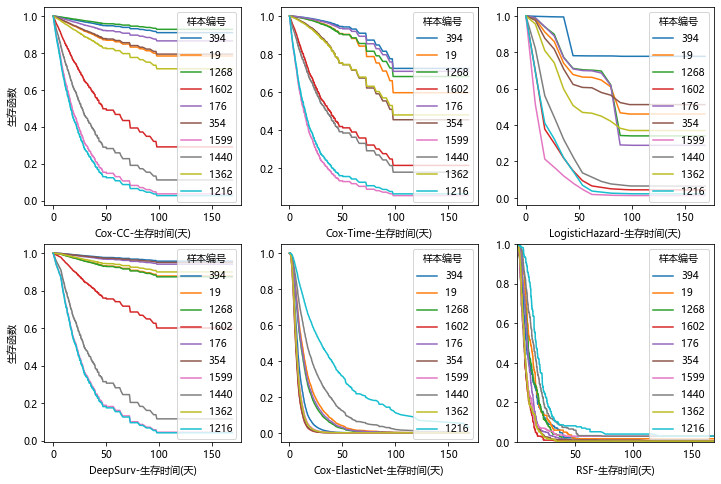

In [167]:
# 随机抽取5个样本进行绘制
def surv_func_predict_plot(modellist,n=5):
    global x_test
    
    print("预测的生存函数曲线")
    np.random.seed(RANDOM_STATE)
    samp = np.random.choice(range(len(x_test)),n,replace=False)
    log_print("抽取的样本编号：",samp)
    
    fig = plt.figure(figsize=(12,8))
    flag = 0
    for name, dat in modellist.items():
        ax = fig.add_subplot(2, 3, flag + 1)

#         res_lrfinder[c].plot(ax=ax)
        dat.iloc[:, samp].plot(ax=ax)
        
        ax.set_xlabel("{}-生存时间(天)".format(name))
        if flag in [0,3]:
            ax.set_ylabel("生存函数")
        else:
            ax.set_ylabel("")
        ax.legend(loc="upper right",title="样本编号")
        flag += 1
    ax.autoscale(tight=True)
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_predict_surv_func.svg"), dpi=600, format='svg')
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_predict_surv_func.pdf"), dpi=600)


# 绘制LR寻优图：8个模型绘制到一张图中
surv_func_predict_plot(model_surv_predict_list,n=10)

### 评估

In [147]:
model_surv_predict_list = {
    "Cox-CC":surv_coxcc,
    "Cox-Time":surv_coxtime,
    "LogisticHazard":surv_logistichazard,
    "DeepSurv":surv_deepsurv,
    "Cox-ElasticNet":surv_net,
    "RSF":surv_rsf
}

In [148]:
ev_coxcc = EvalSurv(surv_coxcc, durations_test, events_test, censor_surv='km')
ev_coxtime = EvalSurv(surv_coxtime, durations_test, events_test, censor_surv='km')
ev_logistichazard = EvalSurv(surv_logistichazard, durations_test, events_test, censor_surv='km')
ev_deepsurv = EvalSurv(surv_deepsurv, durations_test, events_test, censor_surv='km')
ev_net = EvalSurv(surv_net, durations_test, events_test, censor_surv='km')
ev_rsf = EvalSurv(surv_rsf, durations_test, events_test, censor_surv='km')

In [149]:
# 一致性指标C-index、（非比例风险模型：C^td)
model_cindex_eval_list = {
    "Cox-CC":[ev_coxcc.concordance_td()],
    "Cox-Time":[ev_coxtime.concordance_td()],
    "LogisticHazard":[ev_logistichazard.concordance_td()],
    "DeepSurv":[ev_deepsurv.concordance_td()],
    "Cox-ElasticNet":[cox_net_model.score(x_test,y_test)],
    "RSF":[cox_rsf_model.score(x_test,y_test)]
}

model_cindex_eval_df = pd.DataFrame(model_cindex_eval_list,index=["一致性指数"]).T.sort_values("一致性指数",ascending=False)
model_cindex_eval_df.to_csv(os.path.join(OUTPUT_FILE, "table_model_cindex_eval.csv"),encoding="utf_8_sig")


D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"


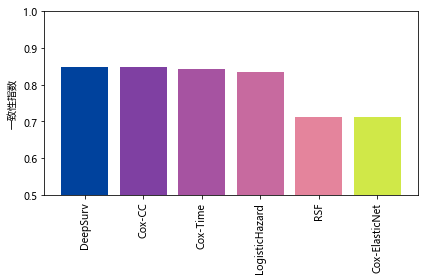

In [150]:
plt.figure(figsize=(6, 4))
colors = ['#00429d', '#7f40a2', '#a653a1', '#c76a9f', '#e4849c', '#d0e848']
plt.bar(model_cindex_eval_df.index,model_cindex_eval_df["一致性指数"],color=colors)

plt.ylabel("一致性指数")
plt.ylim(0.5, 1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FILE, "plot_model_cindex_eval_bar.svg"), dpi=600, format='svg')
plt.savefig(os.path.join(OUTPUT_FILE, "plot_model_cindex_eval_bar.pdf"), dpi=600)

In [151]:

plt.plot(va_times, cph_auc[::-1], "o-", label="CoxPH (mean AUC = {:.3f})".format(cph_mean_auc))
plt.plot(va_times, rsf_auc[::-1], "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")


NameError: name 'va_times' is not defined

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


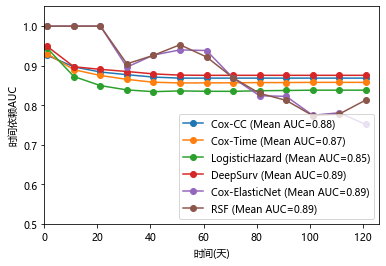

In [152]:
# 依赖时间的ROC曲线

def timeroc_plot(modellist, df_test):

    xvalue = np.arange(df_test["duration"].min()+1, df_test["duration"].max(), 10).tolist()

    fig = plt.figure()
    ax = fig.add_subplot()
    
    for name, dat in modellist.items():
        model_auc = []
        
        if name in ["RSF","Cox-ElasticNet"]:
            global x_test
            x_test = pd.DataFrame(x_test, index=df_test.index, columns=df_test.columns.drop(["duration","event"]))
            _,y_test = sksurv.datasets.get_x_y(df_test,attr_labels=["event","duration"],pos_label=0)

            va_times = np.arange(df_test["duration"].min()+1, df_test["duration"].max(), 10)
            if name == "RSF":
                rsf_chf_funcs = cox_rsf_model.predict_cumulative_hazard_function(x_test, return_array=False)
                rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
                rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
                    y_train, y_test, rsf_risk_scores, va_times
                )
                model_auc = model_auc + rsf_auc[::-1].tolist()

            if name == "Cox-ElasticNet":
                cph_risk_scores  = cox_net_model.predict(x_test)
                cph_auc, cph_mean_auc = cumulative_dynamic_auc(
                    y_train, y_test, cph_risk_scores, va_times
                )
                model_auc = model_auc + cph_auc[::-1].tolist()
            
        else:
            res_predictdf = 1 - dat.T
            for xv in xvalue:
                near_idx = find_nearest(res_predictdf.columns, xv)
                predict = list(res_predictdf[near_idx])
                label = generate_label(df_test, xv)
                fpr, tpr, thresholds = roc_curve(label, predict, pos_label=1)

                model_auc.append(auc(fpr, tpr))
        
        plt.plot(xvalue, model_auc,marker="o", label="{} (Mean AUC={:.2f})".format(name,np.mean(model_auc)))
        ax.legend(loc="lower right")

    ax.set_xlabel('时间(天)')
    ax.set_ylabel('时间依赖AUC')
    ax.set_xlim([0.0, df_test["duration"].max()])
    ax.set_ylim([0.5, 1.05])
#     ax.autoscale(tight=True)
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_model_eval_time_roc.svg"), dpi=600, format='svg')
    plt.savefig(os.path.join(OUTPUT_FILE, "plot_model_eval_time_roc.pdf"), dpi=600)


# 绘制time-roc曲线图：8个模型绘制到一张图中
timeroc_plot(model_surv_predict_list, df_test)

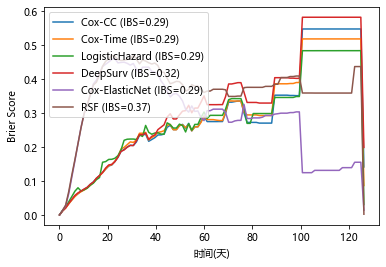

In [153]:
# BS

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
fig = plt.figure(figsize=(6,4))
ev_coxcc.brier_score(time_grid).plot(label="Cox-CC (IBS={:.2f})".format(ev_coxcc.integrated_brier_score(time_grid)))
ev_coxtime.brier_score(time_grid).plot(label="Cox-Time (IBS={:.2f})".format(ev_coxtime.integrated_brier_score(time_grid)))
ev_logistichazard.brier_score(time_grid).plot(label="LogisticHazard (IBS={:.2f})".format(ev_logistichazard.integrated_brier_score(time_grid)))
ev_deepsurv.brier_score(time_grid).plot(label="DeepSurv (IBS={:.2f})".format(ev_deepsurv.integrated_brier_score(time_grid)))
ev_net.brier_score(time_grid).plot(label="Cox-ElasticNet (IBS={:.2f})".format(ev_net.integrated_brier_score(time_grid)))
ev_rsf.brier_score(time_grid).plot(label="RSF (IBS={:.2f})".format(ev_rsf.integrated_brier_score(time_grid)))

plt.ylabel('Brier Score')
_ = plt.xlabel('时间(天)')


plt.legend(loc="upper left")

plt.savefig(os.path.join(OUTPUT_FILE, "plot_model_eval_brier_score.svg"), dpi=600, format='svg')
plt.savefig(os.path.join(OUTPUT_FILE, "plot_model_eval_brier_score.pdf"), dpi=600)



In [154]:
# 导入数据库其他相关数据
kidneyfailure_diseafreq = dataframe_from_pgsql("public", "kidneyfailure_diseafreq")

kidneyfailure_diseaseseqnum = dataframe_from_pgsql("public", "kidneyfailure_diseaseseqnum")

kidneyfailure_maindiseases = dataframe_from_pgsql("public", "kidneyfailure_maindiseases")


Opened database successfully
Opened database successfully
Opened database successfully


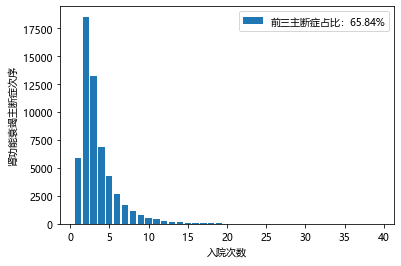

In [155]:
diseafreq_df = kidneyfailure_diseafreq.rename({"icd_code":"ICD CODE","long_title":"疾病类型描述","count_diseases":"频数"})
diseafreq_df.to_csv(os.path.join(OUTPUT_FILE, "table_dieasecount.csv"),encoding="utf_8_sig")

maindiseases = kidneyfailure_maindiseases.rename({"icd_code":"ICD CODE","long_title":"疾病类型描述","icd_version":"ICD 版本"})
maindiseases.to_csv(os.path.join(OUTPUT_FILE, "table_maindiseases_contain.csv"),encoding="utf_8_sig")



seqnum_order = kidneyfailure_diseaseseqnum.sort_values("seq_num")
perc = seqnum_order.loc[seqnum_order["seq_num"]<=3,"count_seq"].sum() / seqnum_order["count_seq"].sum()

fig, ax = plt.subplots()
ax.bar(seqnum_order["seq_num"],seqnum_order["count_seq"],label="前三主断症占比：{}%".format(round(perc*100,2)))
ax.set_xlabel("入院次数")
ax.set_ylabel("肾功能衰竭主断症次序")
ax.legend(loc='upper right')

# ax.autoscale(tight=True)
plt.savefig(os.path.join(OUTPUT_FILE, "plot_disease_seq_count.svg"), dpi=600, format='svg')
plt.savefig(os.path.join(OUTPUT_FILE, "plot_disease_seq_count.pdf"), dpi=600)


正在绘制按月的roc曲线图


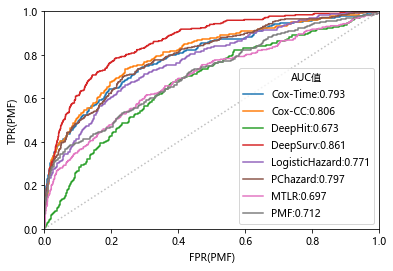

In [82]:



# def time_roc_plot(res_predictdf, modelnames, df_test, modelc, figname="TimeROC"):
#     print("正在绘制依赖时间的ROC曲线：")

#     xvalue = np.arange(0, df_test["duration"].max(), 10)



#     fig, ax = plt.subplots()

#     for c in modelnames:
#         model_auc = []
#         for xv in xvalue:
#             near_idx = find_nearest(res_predictdf[c].columns, xv)
#             predict = list(res_predictdf[c][near_idx])
#             label = generate_label(df_test, xv)
#             fpr, tpr, thresholds = roc_curve(label, predict, pos_label=1)
#             model_auc.append(auc(fpr, tpr))

#         ax.plot(xvalue, model_auc, label=modelnamedict[c])
#         ax.legend(loc="lower right")
#     ax.set_xlim([0.0, 230.0])
#     ax.set_xlim([0.0, 1.05])
#     ax.set(xlabel='时间(天)')
#     ax.set(ylabel='AUC')
#     ax.autoscale(tight=True)
#     plt.savefig(os.path.join(OUTPUT_FILE, "依赖时间的ROC曲线.svg"), dpi=600, format='svg')
#     plt.savefig(os.path.join(OUTPUT_FILE, "依赖时间的ROC曲线.pdf"), dpi=600)



# def roc_plot(predict_df, df_test, modelc):
#     print("正在绘制1月，3月，5月的ROC曲线")
    
#     near_1_idx = find_nearest(predict_df.columns, MONTH1)
#     predict_1_month = list(predict_df[near_1_idx])
#     near_3_idx = find_nearest(predict_df.columns, MONTH3)
#     predict_3_month = list(predict_df[near_3_idx])
#     near_5_idx = find_nearest(predict_df.columns, MONTH5)
#     predict_5_month = list(predict_df[near_5_idx])

#     label_1_month = generate_label(df_test, MONTH1)
#     label_3_month = generate_label(df_test, MONTH3)
#     label_5_month = generate_label(df_test, MONTH5)

#     fpr_1, tpr_1, thresholds_1 = roc_curve(label_1_month, predict_1_month, pos_label=1)
#     fpr_3, tpr_3, thresholds_3 = roc_curve(label_3_month, predict_3_month, pos_label=1)
#     fpr_5, tpr_5, thresholds_5 = roc_curve(label_5_month, predict_5_month, pos_label=1)

#     model_auc_1 = auc(fpr_1, tpr_1)
#     model_auc_3 = auc(fpr_3, tpr_3)
#     model_auc_5 = auc(fpr_5, tpr_5)


#     fig, ax = plt.subplots()

#     ax.plot(fpr_1, tpr_1, label="1个月:%.3f" % model_auc_1)
#     ax.plot(fpr_3, tpr_3, label="3个月:%.3f" % model_auc_3)
#     ax.plot(fpr_5, tpr_5, label="5个月:%.3f" % model_auc_5)
#     ax.plot([0, 1], [0, 1], color='silver', linestyle=':')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_xlim([0.0, 1.05])
#     ax.set(xlabel='FPR({})'.format(modelc))
#     ax.set(ylabel='TPR({})'.format(modelc))
#     ax.legend(title="AUC值",loc="lower right")
#     ax.autoscale(tight=True)
#     plt.savefig(os.path.join(OUTPUT_FILE, "{}_135的ROC曲线.svg".format(modelc)), dpi=600, format='svg')
#     plt.savefig(os.path.join(OUTPUT_FILE, "{}_135的ROC曲线.pdf".format(modelc)), dpi=600)


# # 绘制roc曲线图（1-3-5）：8个模型分开绘制
# for c in modelnames:
#     roc_plot(res_predictdf[c], df_test=df_test, modelc=modelnamedict[c])


# def lr_finder_plot(res_lrfinder, modelnames):
#     print("正在绘制LR寻优图")
    
#     fig = plt.figure(figsize=(12,8))
#     flag = 0
#     for c in modelnames:
#         ax = fig.add_subplot(2, 4, flag + 1)

#         res_lrfinder[c].plot(ax=ax)
        
#         ax.set_xlabel("学习率({})".format(modelnamedict[c]))
#         if flag in [0,4]:
#             ax.set_ylabel("训练损失")
#         else:
#             ax.set_ylabel("")
#         ax.get_legend().remove()
#         flag += 1
#     ax.autoscale(tight=True)
#     plt.savefig(os.path.join(OUTPUT_FILE, "模型训练LR寻优图.svg"), dpi=600, format='svg')
#     plt.savefig(os.path.join(OUTPUT_FILE, "模型训练LR寻优图.pdf"), dpi=600)


# # 绘制LR寻优图：8个模型绘制到一张图中
# lr_finder_plot(res_lrfinder, modelnames)



# def lost_plot(res_log, modelnames):
#     print("正在绘制训练损失图")
    
#     fig = plt.figure(figsize=(12,8))
#     flag = 0
#     for c in modelnames:
#         ax = fig.add_subplot(2, 4, flag + 1)
#         tempdat = res_log[c].to_pandas()

#         ax.plot(tempdat.index, tempdat["train_loss"],label="Train Loss")
#         ax.plot(tempdat.index, tempdat["val_loss"],label="Val Loss")
        
#         ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
#         ax.set_xlabel("训练批次({})".format(modelnamedict[c]))
#         if flag in [0,4]:
#             ax.set_ylabel("训练损失")
#         else:
#             ax.set_ylabel("")
            
            
#         plt.legend(loc='upper right')
#         flag += 1
#     ax.autoscale(tight=True)
#     plt.savefig(os.path.join(OUTPUT_FILE, "模型训练损失图.svg"), dpi=600, format='svg')
#     plt.savefig(os.path.join(OUTPUT_FILE, "模型训练损失图.pdf"), dpi=600)


# # 绘制训练损失图：8个模型分开绘制
# lost_plot(res_log, modelnames)


# def monthroc_plot(month, modelnames, res_predictdf, df_test):
#     print("正在绘制按月的roc曲线图")
#     fig = plt.figure()
#     ax = fig.add_subplot()

#     flag=0
#     for c in modelnames:

#         near_idx = find_nearest(res_predictdf[c].columns, month)
#         predict_month = list(res_predictdf[c][near_idx])
#         label_month = generate_label(df_test, month)
#         fpr, tpr, thresholds = roc_curve(label_month, predict_month, pos_label=1)
#         model_auc = auc(fpr, tpr)

#         ax.plot(fpr, tpr, label='{}:'.format(modelnamedict[c])+'%0.3f' % model_auc)
#         ax.legend(title="AUC值",loc="lower right")
#         flag += 1
#     ax.plot([0, 1], [0, 1], color='silver', linestyle=':')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('FPR({})'.format(modelnamedict[c]))
#     ax.set_ylabel('TPR({})'.format(modelnamedict[c]))
#     ax.autoscale(tight=True)
#     plt.savefig(os.path.join(OUTPUT_FILE, "{}的ROC曲线.svg".format(month)), dpi=600, format='svg')
#     plt.savefig(os.path.join(OUTPUT_FILE, "{}的ROC曲线.pdf".format(month)), dpi=600)

# # 绘制roc曲线图（1）：8个模型绘制到一张图中
# monthroc_plot(MONTH1, modelnames, res_predictdf, df_test)


# def monthroc_plot(month, modelnames, res_predictdf, df_test):
#     print("正在绘制按月的roc曲线图")
#     fig = plt.figure()
#     ax = fig.add_subplot()

#     flag=0
#     for c in modelnames:

#         near_idx = find_nearest(res_predictdf[c].columns, month)
#         predict_month = list(res_predictdf[c][near_idx])
#         label_month = generate_label(df_test, month)
#         fpr, tpr, thresholds = roc_curve(label_month, predict_month, pos_label=1)
#         model_auc = auc(fpr, tpr)

#         ax.plot(fpr, tpr, label='{}:'.format(modelnamedict[c])+'%0.3f' % model_auc)
#         ax.legend(title="AUC值",loc="lower right")
#         flag += 1
#     ax.plot([0, 1], [0, 1], color='silver', linestyle=':')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('FPR({})'.format(modelnamedict[c]))
#     ax.set_ylabel('TPR({})'.format(modelnamedict[c]))
#     ax.autoscale(tight=True)
#     plt.savefig(os.path.join(OUTPUT_FILE, "{}的ROC曲线.svg".format(month)), dpi=600, format='svg')
#     plt.savefig(os.path.join(OUTPUT_FILE, "{}的ROC曲线.pdf".format(month)), dpi=600)

# # 绘制roc曲线图（3）：8个模型绘制到一张图中
# monthroc_plot(MONTH3, modelnames, res_predictdf, df_test)



# def monthroc_plot(month, modelnames, res_predictdf, df_test):
#     print("正在绘制按月的roc曲线图")
#     fig = plt.figure()
#     ax = fig.add_subplot()

#     flag=0
#     for c in modelnames:

#         near_idx = find_nearest(res_predictdf[c].columns, month)
#         predict_month = list(res_predictdf[c][near_idx])
#         label_month = generate_label(df_test, month)
#         fpr, tpr, thresholds = roc_curve(label_month, predict_month, pos_label=1)
#         model_auc = auc(fpr, tpr)

#         ax.plot(fpr, tpr, label='{}:'.format(modelnamedict[c])+'%0.3f' % model_auc)
#         ax.legend(title="AUC值",loc="lower right")
#         flag += 1
#     ax.plot([0, 1], [0, 1], color='silver', linestyle=':')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('FPR({})'.format(modelnamedict[c]))
#     ax.set_ylabel('TPR({})'.format(modelnamedict[c]))
#     ax.autoscale(tight=True)
#     plt.savefig(os.path.join(OUTPUT_FILE, "{}的ROC曲线.svg".format(month)), dpi=600, format='svg')
#     plt.savefig(os.path.join(OUTPUT_FILE, "{}的ROC曲线.pdf".format(month)), dpi=600)

# # 绘制roc曲线图（5）：8个模型绘制到一张图中
# monthroc_plot(MONTH5, modelnames, res_predictdf, df_test)

D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
D:\ProgramData\Anaconda3\envs\graduate\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true

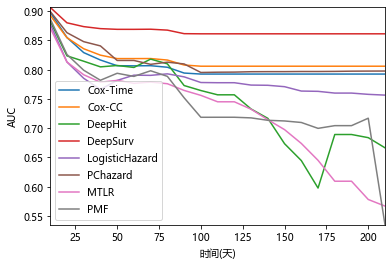

In [98]:

# def timeroc_plot(modelnames, res_predictdf, df_test):

#     xvalue = np.arange(0, df_test["duration"].max(), 10).tolist()

#     fig = plt.figure()
#     ax = fig.add_subplot()

#     for c in modelnames:
#         model_auc = []
#         for xv in xvalue:
#             near_idx = find_nearest(res_predictdf[c].columns, xv)
#             predict = list(res_predictdf[c][near_idx])
#             label = generate_label(df_test, xv)
#             fpr, tpr, thresholds = roc_curve(label, predict, pos_label=1)
            
#             model_auc.append(auc(fpr, tpr))
#         plt.plot(xvalue, model_auc, label=modelnamedict[c])
#         ax.legend(loc="lower left")

#     ax.set_xlabel('时间(天)')
#     ax.set_ylabel('AUC')
#     ax.set_xlim([0.0, 230])
#     ax.set_ylim([0.0, 1.05])
#     ax.autoscale(tight=True)
#     plt.savefig(os.path.join(OUTPUT_FILE, "依赖时间的ROC曲线.svg"), dpi=600, format='svg')
#     plt.savefig(os.path.join(OUTPUT_FILE, "依赖时间的ROC曲线.pdf"), dpi=600)


# # 绘制time-roc曲线图：8个模型绘制到一张图中
# timeroc_plot(modelnames, res_predictdf, df_test)

In [68]:

# def eval_res_table(modelnames, res_surv, df_test):
#     get_target = lambda df: (df['duration'].values, df['event'].values)
#     durations_test, events_test = get_target(df_test)

#     cindex_td = []
#     ibs = []
#     inbll = []
#     bs_1_month, bs_3_month, bs_5_month, bs_all_month = [], [], [], []
#     nbll_1_month, nbll_3_month, nbll_5_month, nbll_all_month = [], [], [], []
#     modelname = []
#     for c in modelnames:
#         time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
#         ev = EvalSurv(res_surv[c], durations_test, events_test, censor_surv='km')

#         cindex_td.append("%.3f" % ev.concordance_td('antolini'))
#         ibs.append("%.3f" % ev.integrated_brier_score(time_grid))
#         inbll.append("%.3f" % ev.integrated_nbll(time_grid))

#         bs = ev.brier_score(time_grid)

#         bs_1_month.append("%.3f" % bs[bs.index < MONTH1].mean() + "(" + "%.3f" % (
#                 bs[bs.index < MONTH1].mean() - 1.96 * bs[bs.index < MONTH1].std()) + "," + "%.3f" % (
#                                   bs[bs.index < MONTH1].mean() + 1.96 * bs[bs.index < MONTH1].std()) + ")")
#         bs_3_month.append("%.3f" % bs[bs.index < MONTH3].mean() + "(" + "%.3f" % (
#                 bs[bs.index < MONTH3].mean() - 1.96 * bs[bs.index < MONTH3].std()) + "," + "%.3f" % (
#                                   bs[bs.index < MONTH3].mean() + 1.96 * bs[bs.index < MONTH1].std()) + ")")
#         bs_5_month.append("%.3f" % bs[bs.index < MONTH5].mean() + "(" + "%.3f" % (
#                 bs[bs.index < MONTH5].mean() - 1.96 * bs[bs.index < MONTH5].std()) + "," + "%.3f" % (
#                                   bs[bs.index < MONTH5].mean() + 1.96 * bs[bs.index < MONTH1].std()) + ")")
#         bs_all_month.append("%.3f" % bs.mean() + "(" + "%.3f" % (bs.mean() - 1.96 * bs.std()) + "," + "%.3f" % (
#                 bs.mean() + 1.96 * bs.std()) + ")")

#         nbll = ev.nbll(time_grid)
#         nbll_1_month.append("%.3f" % nbll[nbll.index < MONTH1].mean() + "(" + "%.3f" % (
#                 nbll[nbll.index < MONTH1].mean() - 1.96 * nbll[nbll.index < MONTH1].std()) + "," + "%.3f" % (
#                                     nbll[nbll.index < MONTH1].mean() + 1.96 * nbll[nbll.index < MONTH1].std()) + ")")
#         nbll_3_month.append("%.3f" % nbll[nbll.index < MONTH3].mean() + "(" + "%.3f" % (
#                 nbll[nbll.index < MONTH3].mean() - 1.96 * nbll[nbll.index < MONTH3].std()) + "," + "%.3f" % (
#                                     nbll[nbll.index < MONTH3].mean() + 1.96 * nbll[nbll.index < MONTH3].std()) + ")")
#         nbll_5_month.append("%.3f" % nbll[nbll.index < MONTH5].mean() + "(" + "%.3f" % (
#                 nbll[nbll.index < MONTH5].mean() - 1.96 * nbll[nbll.index < MONTH5].std()) + "," + "%.3f" % (
#                                     nbll[nbll.index < MONTH5].mean() + 1.96 * nbll[nbll.index < MONTH5].std()) + ")")
#         nbll_all_month.append("%.3f" % nbll.mean() + "(" + "%.3f" % (nbll.mean() - 1.96 * nbll.std()) + "," + "%.3f" % (
#                 nbll.mean() + 1.96 * nbll.std()) + ")")
        
#         modelname.append(modelnamedict[c]) 
#     evalu_res = {
#         "模型": modelname,
#         "C-Index(td)": cindex_td,
#         "IBS": ibs,
#         "IBLL": inbll,

#         "BS(1个月)": bs_1_month,
#         "BS(3个月)": bs_3_month,
#         "BS(5个月)": bs_5_month,
#         "BS(全生存期)": bs_all_month,

#         "NBLL(1个月)": nbll_1_month,
#         "NBLL(3个月)": nbll_3_month,
#         "NBLL(5个月)": nbll_5_month,
#         "NBLL(全生存期)": nbll_all_month

#     }

#     evalu_res_df = pd.DataFrame(evalu_res)
#     return evalu_res_df

# # 各个指标的评价：
# evalu_res_df = eval_res_table(modelnames, res_surv, df_test)
# evalu_res_df.to_csv(os.path.join(OUTPUT_FILE, "各个模型的评价指标.csv"),encoding="utf_8_sig")

In [ ]:


# def mode_all( datparams, netparams, modelparams, trainparams):

#     # 数据处理
#     df_train = datparams["df_train"]
#     df_val = datparams["df_val"]
#     df_test = datparams["df_test"]
#     x_val = datparams["x_val"]
#     x_train = datparams["x_train"]
#     # 构建网络
#     in_features = netparams["in_features"]
#     num_nodes = netparams["num_nodes"]
#     batch_norm = netparams["batch_norm"]
#     dropout = netparams["dropout"]
#     output_bias = netparams["output_bias"]
#     # 构造模型
#     optimizer = modelparams["optimizer"]
#     tolerance = modelparams["tolerance"]
#     modelname = modelparams["modelname"]
#     alpha = modelparams["alpha"]
#     sigma = modelparams["sigma"]
#     # 训练模型
#     batch_size = trainparams["batch_size"]
#     epochs = trainparams["epochs"]
#     callbacks = trainparams["callbacks"]
#     verbose = trainparams["verbose"]

    
    
#     num_durations = 20
#     if str.lower(modelname) == "coxtime":
#         labtrans = CoxTime.label_transform()
#     elif str.lower(modelname) == "deephit":
#         labtrans = DeepHitSingle.label_transform(num_durations)
#     elif str.lower(modelname) == "logistichazard":
#         labtrans = LogisticHazard.label_transform(num_durations)
#     elif str.lower(modelname) == "pmf":
#         labtrans = PMF.label_transform(num_durations)
#     elif str.lower(modelname) == "mtlr":
#         labtrans = MTLR.label_transform(num_durations)
#     elif str.lower(modelname) == "pchazard":
#         labtrans = PCHazard.label_transform(num_durations)
#     else:
#         labtrans = None

#     # 目标变量转换
#     get_target = lambda df: (df['duration'].values, df['event'].values)
#     durations_test, events_test = get_target(df_test)

#     if labtrans:
#         y_train = labtrans.fit_transform(*get_target(df_train))
#         y_val = labtrans.transform(*get_target(df_val))
#         out_features = labtrans.out_features
#     else:
#         y_train = get_target(df_train)
#         y_val = get_target(df_val)
#         out_features = 1

#     val = tt.tuplefy(x_val, y_val)

#     if str.lower(modelname) == "coxtime":
#         net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
#         model = CoxTime(net, optimizer, labtrans=labtrans)
#     elif str.lower(modelname) == "coxcc":
#         net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
#                                       output_bias=output_bias)
#         model = CoxCC(net, optimizer)
#     elif str.lower(modelname) == "coxph" or (str.lower(modelname) =='deepsurv'):
#         net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
#                                       output_bias=output_bias)
#         model = CoxPH(net, optimizer)
#     elif str.lower(modelname) == "deephit":
#         net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
#                                       output_bias=output_bias)
#         model = DeepHitSingle(net, optimizer, alpha=alpha, sigma=sigma, duration_index=labtrans.cuts)
#     elif str.lower(modelname) == "logistichazard":
#         net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
#                                       output_bias=output_bias)
#         model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)
#     elif str.lower(modelname) == "pmf":
#         net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
#                                       output_bias=output_bias)
#         model = PMF(net, optimizer, duration_index=labtrans.cuts)
#     elif str.lower(modelname) == "mtlr":
#         net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
#                                       output_bias=output_bias)
#         model = MTLR(net, optimizer, duration_index=labtrans.cuts)
#     elif str.lower(modelname) == "pchazard":
#         net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
#                                       output_bias=output_bias)
#         model = PCHazard(net, optimizer, duration_index=labtrans.cuts)
#     else:
#         print("请输入正确模型名称")
#         net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout,
#                                       output_bias=output_bias)
#         model = PCHazard(net, optimizer, duration_index=labtrans.cuts)

#     print("模型:", model)

#     lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=tolerance)
#     model.optimizer.set_lr(lrfinder.get_best_lr())
#     model.optimizer.set_lr(0.1)
#     log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val.repeat(10).cat())

#     return model, lrfinder, log








# res_net = dict()
# res_model = dict()
# res_lrfinder = dict()
# res_log = dict()
# res_surv = dict()
# res_predictdf = dict()
# res_durations_test = dict()
# res_events_test = dict()
# modelnames = ["CoxTime", "deephit", "DeepSurv"]
# # modelnames = ["CoxTime"]
# for c in modelnames:
#     datparams = {
#         "df_train": df_train,
#         "df_val": df_val,
#         "df_test": df_test,
#         "x_val": x_val,
#         "x_train": x_train,
#     }
#     netparams = {
#         "in_features": x_train.shape[1],
#         "num_nodes": [32, 32],
#         "batch_norm": True,
#         "dropout": 0.1,
#         "output_bias": False,
#     }
#     modelparams = {
#         "optimizer": tt.optim.Adam,
#         "tolerance": 10,
#         "alpha": 0.2,
#         "sigma": 0.1,
#         "modelname": c
#     }

#     trainparams = {
#         "batch_size": 256,
#         "epochs": 512,
#         "callbacks": [tt.callbacks.EarlyStopping()],
#         "verbose": True
#     }

#     res_model[c], res_lrfinder[c], res_log[c] = mode_all(datparams, netparams, modelparams, trainparams)

#     if c in ["coxcc", "coxtime", "coxph"]:
#         print("正在计算预测结果")
#         _ = res_model[c].compute_baseline_hazards()
#         res_surv[c] = res_model[c].predict_surv_df(x_test)
#     else:
#         print("正在计算预测结果")
#         res_surv[c] = res_model[c].predict_surv_df(x_test)

#     res_predictdf[c] = 1 - res_surv[c].T

